# Initialize

In [1]:
library("dplyr")
library("magrittr")
library("igraph")
library("plyr")
library("ggplot2")
library("ggfortify")
library("pheatmap")
library("readxl")
library("SetRank")
library("tidyverse")
library("WriteXLS")
library("parallel")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

── Attaching packages ────────

In [2]:
source("R/Helper.R")
source("R/Plotting.R")

In [3]:
meta <- gdata::read.xls("../doc/meta_data.xls", check.names = F)
meta$donor <- gsub("_.*", "", meta$Specimen)
meta$treat <- sub("[a-zA-Z0-9]+_[0-9]+_", "", meta$Specimen)
meta$treat2 <- "DC"
co_idx <- grepl("plus_.+_plus", meta$treat, ignore.case = T)
meta$treat2[co_idx] <- "DC + CMV + Afu"
meta$treat2[grepl("DC_plus_Afu", meta$treat, ignore.case = T) & !co_idx] <- "DC + Afu"
meta$treat2[grepl("DC_plus_CMV", meta$treat, ignore.case = T) & !co_idx] <- "DC + CMV"
meta <- meta %>% dplyr::select(Specimen, treat, treat2, donor, everything())
head(meta)

Specimen                                  treat                          
1 Donor1_01_DC_alone                        DC_alone                       
2 Donor1_02_DC_plus_Afu_0h                  DC_plus_Afu_0h                 
3 Donor1_03_DC_plus_Afu_4h30min             DC_plus_Afu_4h30min            
4 Donor1_04_DC_plus_CMV_0h                  DC_plus_CMV_0h                 
5 Donor1_05_DC_plus_CMV_0h_plus_Afu_0h      DC_plus_CMV_0h_plus_Afu_0h     
6 Donor1_06_DC_plus_CMV_0h_plus_Afu_4h30min DC_plus_CMV_0h_plus_Afu_4h30min
  treat2         donor  Material.Type Organism     Strain.or.Line 
1 DC             Donor1 cell          Homo sapiens dendritic cells
2 DC + Afu       Donor1 cell          Homo sapiens dendritic cells
3 DC + Afu       Donor1 cell          Homo sapiens dendritic cells
4 DC + CMV       Donor1 cell          Homo sapiens dendritic cells
5 DC + CMV + Afu Donor1 cell          Homo sapiens dendritic cells
6 DC + CMV + Afu Donor1 cell          Homo sapiens dendritic cells
  Organism.Part OrganismStatus Number.of.fungal.cells ⋯
1 NA            healthy         NA                    ⋯
2 NA            healthy        0.5                    ⋯
3 NA            healthy        0.5                    ⋯
4 NA            healthy         NA                    ⋯
5 NA            healthy        0.5                    ⋯
6 NA            healthy        0.5                    ⋯
  CoInfection_CMV_first_vs_CoInfection CoInfection_Afu_first_vs_CoInfection
1 none                                 none                                
2 none                                 none                                
3 none                                 none                                
4 none                                 none                                
5 control                              control                             
6 treatment                            none                                
  Coinfection_Afu_first_vs_CoInfection_CMV_first
1 none                                          
2 none                                          
3 none                                          
4 none                                          
5 none                                          
6 control                                       
  SingleInfection_CMV_0h_vs_SingleCulture_DC
1 control                                   
2 none                                      
3 none                                      
4 treatment                                 
5 none                                      
6 none                                      
  SingleInfection_Afu_4h30min_vs_SingleCulture_DC
1 control                                        
2 none                                           
3 treatment                                      
4 none                                           
5 none                                           
6 none                                           
  SingleInfection_Afu_0h_vs_SingleCulture_DC
1 control                                   
2 treatment                                 
3 none                                      
4 none                                      
5 none                                      
6 none                                      
  SingleInfection_CMV_2h_vs_SingleCulture_DC
1 control                                   
2 none                                      
3 none                                      
4 none                                      
5 none                                      
6 none                                      
  CoInfection_CMV_first_vs_SingleCulture_DC CoInfection_vs_SingleCulture_DC
1 control                                   control                        
2 none                                      none                           
3 none                                      none                           
4 none                                      none                           
5 none                                      treatment      

In [4]:
counts_sp1 <- read.csv("../results/stats/Hsapiens_counts.csv", sep = "\t")
counts_sp2 <- read.csv("../results/stats/Afumigatus_counts.csv", sep = "\t")
counts_sp3 <- read.csv("../results/stats/CMV_counts.csv", sep = "\t")

In [5]:
counts_sp1 %>% head
counts_sp2 %>% head
counts_sp3 %>% head

Donor1_01_DC_alone Donor1_02_DC_plus_Afu_0h
ENSG00000223972 0                  0                       
ENSG00000227232 2                  0                       
ENSG00000278267 1                  0                       
ENSG00000243485 0                  0                       
ENSG00000284332 0                  0                       
ENSG00000237613 0                  0                       
                Donor1_03_DC_plus_Afu_4h30min Donor1_04_DC_plus_CMV_0h
ENSG00000223972 0                             0                       
ENSG00000227232 2                             0                       
ENSG00000278267 0                             2                       
ENSG00000243485 0                             0                       
ENSG00000284332 0                             0                       
ENSG00000237613 0                             0                       
                Donor1_05_DC_plus_CMV_0h_plus_Afu_0h
ENSG00000223972 0                                   
ENSG00000227232 1                                   
ENSG00000278267 1                                   
ENSG00000243485 0                                   
ENSG00000284332 0                                   
ENSG00000237613 0                                   
                Donor1_06_DC_plus_CMV_0h_plus_Afu_4h30min
ENSG00000223972 0                                        
ENSG00000227232 0                                        
ENSG00000278267 0                                        
ENSG00000243485 0                                        
ENSG00000284332 0                                        
ENSG00000237613 0                                        
                Donor1_07_DC_plus_Afu_0h_plus_CMV_2h Donor1_08_DC_plus_CMV_2h
ENSG00000223972 0                                    0                       
ENSG00000227232 1                                    0                       
ENSG00000278267 1                                    0                       
ENSG00000243485 0                                    0                       
ENSG00000284332 0                                    0                       
ENSG00000237613 0                                    0                       
                Donor1_09_Afu_alone_0h Donor1_10_Afu_alone_4h30min ⋯
ENSG00000223972 0                      0                           ⋯
ENSG00000227232 0                      0                           ⋯
ENSG00000278267 0                      0                           ⋯
ENSG00000243485 0                      0                           ⋯
ENSG00000284332 0                      0                           ⋯
ENSG00000237613 0                      0                           ⋯
                Donor4_01_DC_alone Donor4_02_DC_plus_Afu_0h
ENSG00000223972 1                  1                       
ENSG00000227232 0                  0                       
ENSG00000278267 0                  0                       
ENSG00000243485 0                  0                       
ENSG00000284332 0                  0                       
ENSG00000237613 0                  0                       
                Donor4_03_DC_plus_Afu_4h30min Donor4_04_DC_plus_CMV_0h
ENSG00000223972 0                             1                       
ENSG00000227232 0                             5                       
ENSG00000278267 1                             0                       
ENSG00000243485 0                             0                       
ENSG00000284332 0                             0                       
ENSG00000237613 0                             0                       
                Donor4_05_DC_plus_CMV_0h_plus_Afu_0h
ENSG00000223972 1                                   
ENSG00000227232 1                                   
ENSG00000278267 0                                   
ENSG00000243485 0                                   
ENSG00000284332 0                                   
ENSG00000237613 0                                   
     

Donor1_01_DC_alone Donor1_02_DC_plus_Afu_0h
Afu1g00100 0                  0                       
Afu1g00110 0                  0                       
Afu1g00120 0                  0                       
Afu1g00130 0                  0                       
Afu1g00140 0                  0                       
Afu1g00150 0                  0                       
           Donor1_03_DC_plus_Afu_4h30min Donor1_04_DC_plus_CMV_0h
Afu1g00100 0                             0                       
Afu1g00110 0                             0                       
Afu1g00120 0                             0                       
Afu1g00130 0                             0                       
Afu1g00140 0                             0                       
Afu1g00150 0                             0                       
           Donor1_05_DC_plus_CMV_0h_plus_Afu_0h
Afu1g00100 0                                   
Afu1g00110 0                                   
Afu1g00120 0                                   
Afu1g00130 0                                   
Afu1g00140 0                                   
Afu1g00150 0                                   
           Donor1_06_DC_plus_CMV_0h_plus_Afu_4h30min
Afu1g00100 0                                        
Afu1g00110 0                                        
Afu1g00120 0                                        
Afu1g00130 0                                        
Afu1g00140 0                                        
Afu1g00150 0                                        
           Donor1_07_DC_plus_Afu_0h_plus_CMV_2h Donor1_08_DC_plus_CMV_2h
Afu1g00100 0                                    0                       
Afu1g00110 0                                    0                       
Afu1g00120 0                                    0                       
Afu1g00130 0                                    0                       
Afu1g00140 0                                    0                       
Afu1g00150 0                                    0                       
           Donor1_09_Afu_alone_0h Donor1_10_Afu_alone_4h30min ⋯
Afu1g00100 0                      0                           ⋯
Afu1g00110 0                      0                           ⋯
Afu1g00120 0                      0                           ⋯
Afu1g00130 0                      0                           ⋯
Afu1g00140 3                      0                           ⋯
Afu1g00150 0                      0                           ⋯
           Donor4_01_DC_alone Donor4_02_DC_plus_Afu_0h
Afu1g00100 0                  0                       
Afu1g00110 0                  0                       
Afu1g00120 0                  0                       
Afu1g00130 0                  0                       
Afu1g00140 0                  0                       
Afu1g00150 0                  0                       
           Donor4_03_DC_plus_Afu_4h30min Donor4_04_DC_plus_CMV_0h
Afu1g00100 0                             0                       
Afu1g00110 0                             0                       
Afu1g00120 0                             0                       
Afu1g00130 0                             0                       
Afu1g00140 0                             0                       
Afu1g00150 0                             0                       
           Donor4_05_DC_plus_CMV_0h_plus_Afu_0h
Afu1g00100 0                                   
Afu1g00110 0                                   
Afu1g00120 0                                   
Afu1g00130 0                                   
Afu1g00140 0                                   
Afu1g00150 0                                   
           Donor4_06_DC_plus_CMV_0h_plus_Afu_4h30min
Afu1g00100 0                                        
Afu1g00110 0                                        
Afu1g00120 0                                        
Afu1g00130 0                                        
Afu1g00140 0                                      

Donor1_01_DC_alone Donor1_02_DC_plus_Afu_0h
cds-ABV71498.1 0                  0                       
cds-ABV71499.1 0                  0                       
cds-ABV71500.1 0                  0                       
cds-ABV71501.1 0                  0                       
cds-ABV71502.1 0                  0                       
cds-ABV71503.1 0                  0                       
               Donor1_03_DC_plus_Afu_4h30min Donor1_04_DC_plus_CMV_0h
cds-ABV71498.1 0                              4                      
cds-ABV71499.1 0                             50                      
cds-ABV71500.1 0                             22                      
cds-ABV71501.1 0                             13                      
cds-ABV71502.1 0                             32                      
cds-ABV71503.1 0                             28                      
               Donor1_05_DC_plus_CMV_0h_plus_Afu_0h
cds-ABV71498.1  4                                  
cds-ABV71499.1 85                                  
cds-ABV71500.1 43                                  
cds-ABV71501.1 39                                  
cds-ABV71502.1 47                                  
cds-ABV71503.1 28                                  
               Donor1_06_DC_plus_CMV_0h_plus_Afu_4h30min
cds-ABV71498.1  9                                       
cds-ABV71499.1 83                                       
cds-ABV71500.1 17                                       
cds-ABV71501.1 37                                       
cds-ABV71502.1 41                                       
cds-ABV71503.1 28                                       
               Donor1_07_DC_plus_Afu_0h_plus_CMV_2h Donor1_08_DC_plus_CMV_2h
cds-ABV71498.1  5                                    2                      
cds-ABV71499.1 45                                   56                      
cds-ABV71500.1 25                                   15                      
cds-ABV71501.1 26                                   12                      
cds-ABV71502.1 29                                   14                      
cds-ABV71503.1 18                                   12                      
               Donor1_09_Afu_alone_0h Donor1_10_Afu_alone_4h30min ⋯
cds-ABV71498.1 0                      0                           ⋯
cds-ABV71499.1 0                      0                           ⋯
cds-ABV71500.1 0                      0                           ⋯
cds-ABV71501.1 0                      0                           ⋯
cds-ABV71502.1 0                      0                           ⋯
cds-ABV71503.1 0                      0                           ⋯
               Donor4_01_DC_alone Donor4_02_DC_plus_Afu_0h
cds-ABV71498.1 0                  0                       
cds-ABV71499.1 0                  0                       
cds-ABV71500.1 0                  0                       
cds-ABV71501.1 0                  0                       
cds-ABV71502.1 0                  0                       
cds-ABV71503.1 0                  0                       
               Donor4_03_DC_plus_Afu_4h30min Donor4_04_DC_plus_CMV_0h
cds-ABV71498.1 0                              1                      
cds-ABV71499.1 0                             49                      
cds-ABV71500.1 0                             17                      
cds-ABV71501.1 0                              6                      
cds-ABV71502.1 0                             14                      
cds-ABV71503.1 0                             10                      
               Donor4_05_DC_plus_CMV_0h_plus_Afu_0h
cds-ABV71498.1  3                                  
cds-ABV71499.1 31                                  
cds-ABV71500.1 25                                  
cds-ABV71501.1  5                                  
cds-ABV71502.1  9                                  
cds-ABV71503.1  9                                  
               Donor4_06_DC_plus_CMV_0h_plus_Afu_4h30min
cds-ABV714

In [6]:
counts_sp1.mrn <- get_mrn(counts_sp1[, !grepl("Afu_alone", colnames(counts_sp1))]) %>% {. + 1} %>% log2
#counts_sp2.mrn <- get_mrn(counts_sp2) %>% {. + 1} %>% log2 %>% t
#counts_sp3.mrn <- get_mrn(counts_sp3) %>% {. + 1} %>% log2 %>% t

In [7]:
dim(counts_sp1.mrn)

[1] 58233    32

In [8]:
ensembl2symbol = createIDConverter("org.Hs.eg.db", "ENSEMBL", "SYMBOL")
symbol2ensembl = createIDConverter("org.Hs.eg.db", "SYMBOL", "ENSEMBL")

Loading required package: org.Hs.eg.db
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:igraph’:

    normalize, path, union

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.i

In [9]:
symb <- ensembl2symbol(rownames(counts_sp1.mrn), na.rm = F, drop.ambiguous = T)
symb[is.na(symb)] <- rownames(counts_sp1.mrn)[is.na(symb)]

In [10]:
rownames(counts_sp1.mrn) <- symb

# Unadjusted PCA

In [11]:
simp_samp_names <- function(s) {
    s <- sub("Donor", "D", s)
    s <- sub("_[0-9]+_", " ", s)
    s <- sub("(D[0-9]) (.+)", "\\2 - \\1", s)
    s <- sub("_alone", "", s)
    s <- gsub("_plus_", " + ", s)
    s <- sub("4h30min", "4.5h", s)
    s <- gsub("_", " ", s)
    return(s)
}

In [12]:
hm_sel_genes <- function(mat, meta, sel_genes, scale = F, cluster_cols = F, row.names = T, main = "", fontsize = 8, cell_size = NA) {
    top_gene_mat <- mat[rownames(mat) %in% sel_genes,]
    anno_df <- data.frame(Donor = meta$donor, Condition = meta$treat2)
    rownames(anno_df) <- meta$Specimen %>% simp_samp_names
    colnames(top_gene_mat) <- colnames(top_gene_mat) %>% simp_samp_names
    x <- pheatmap(top_gene_mat,
                  annotation_col = anno_df,
                  scale = ifelse(scale, "row", "none"),
                  show_rownames = row.names,
                  fontsize_row = fontsize,
                  fontsize_col = 6,
                  cluster_cols = cluster_cols,
                  main = main,
                  cellheight = cell_size,
                  cellwidth = cell_size)
    return(x)
}

In [13]:
save_pheatmap_pdf <- function(xlist, filename, width=7, height=7) {
    pdf(filename, width=width, height=height)

    if (class(xlist) != "pheatmap") {
        for(x in xlist) {
           grid::grid.newpage()
           grid::grid.draw(x$gtable)
        }
    } else {
        grid::grid.newpage()
        grid::grid.draw(xlist$gtable)
    }
    dev.off()
}


In [14]:
# count matrix with special ordering for publication
new_meta <- data.frame(colnames = colnames(counts_sp1.mrn),
           samples = simp_samp_names(colnames(counts_sp1.mrn))) %>%
    mutate(donor = sub(".+ - (D[0-9])$", "\\1", samples),
           simple = sub(" - D[0-9]$", "", samples) %>% factor(levels = c("DC", "DC + Afu 0h", "DC + Afu 4.5h", "DC + CMV 0h", "DC + CMV 2h", "DC + CMV 0h + DC + Afu 0h", "DC + CMV 0h + Afu 4.5h", "DC + Afu 0h + CMV 2h"),
                                                              labels = c("DC", "DC + Afu 0h", "DC + Afu 4.5h", "DC + CMV 0h", "DC + CMV 2h", "DC + CMV 0h + DC + Afu 0h", "DC + CMV 0h + Afu 4.5h", "DC + CMV 2h + Afu 0h"))) %>%
    arrange(simple, donor)

counts_sp1.mrn.ord <- counts_sp1.mrn
counts_sp1.mrn.ord <- counts_sp1.mrn.ord[, new_meta$colnames]

In [15]:
# AFU samples will not be present
meta <- meta[meta$Specimen %in% colnames(counts_sp1.mrn),]
stopifnot(meta$Specimen == colnames(counts_sp1.mrn))

In [16]:
filter_genes <- function(mat, ntop = 500) {
    rv <- genefilter::rowVars(mat)
    # select the 500 genes by variance
    select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]
    mat[select,]
}

In [17]:
plot_top_genes <- function(mat, meta, top_n) {
    top_gene_mat <- mat %>% filter_genes(top_n)
    pca_comp <- prcomp(top_gene_mat %>% t)
    g <- autoplot(pca_comp, data = meta,
             frame = TRUE,
             colour = 'treat2',
             shape = 'donor',
             loadings = TRUE,
             loadings.label = T,
             loadings.size = 0.01,
             loadings.label.size = 1,
             loadings.label.colour = "black") +
         ggtitle(paste("Number genes: ", top_n)) +
         theme_bw()
    return(list(g = g, genes = rownames(top_gene_mat), pca_comp = pca_comp))
}

In [18]:
plot_top_genes2 <- function(mat, meta, sel_genes) {
    top_gene_mat <- mat[rownames(mat) %in% sel_genes,]
    pca_comp <- prcomp(top_gene_mat %>% t)
    g <- autoplot(pca_comp, data = meta,
             frame = TRUE,
             colour = 'treat2',
             shape = 'donor',
             loadings = TRUE,
             loadings.label = T,
             loadings.size = 0.01,
             loadings.label.size = 1,
             loadings.label.colour = "black") +
         ggtitle(paste("Number genes: ", length(sel_genes))) +
         theme_bw()
    return(list(g = g, genes = rownames(top_gene_mat), pca_comp = pca_comp))
}

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”Warning message:
“`env_bind_fns()` is deprecated as of rlang 0.3.0.
Please use `env_bind_active()` instead.
This warning is displayed once per session.”Warning message:
“`new_overscope()` is deprecated as of rlang 0.2.0.
Please use `new_data_mask()` instead.
This warning is displayed once per session.”Warning message:
“`overscope_eval_next()` is deprecated as of rlang 0.2.0.
Please use `eval_tidy()` with a data mask instead.
This warning is displayed once per session.”Warning message:
“`overscope_clean()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”

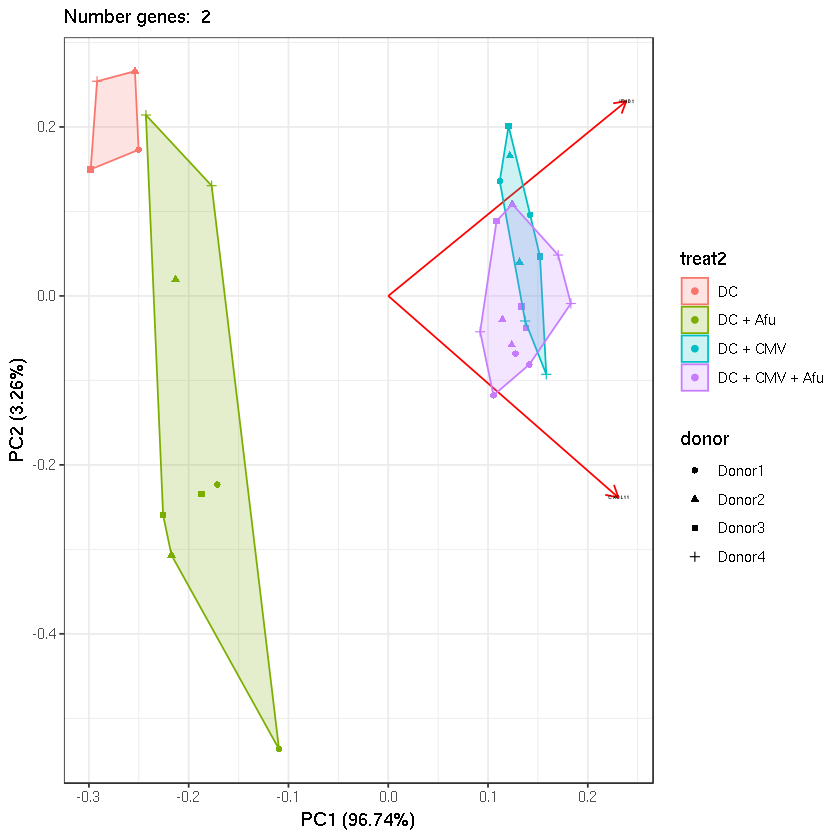

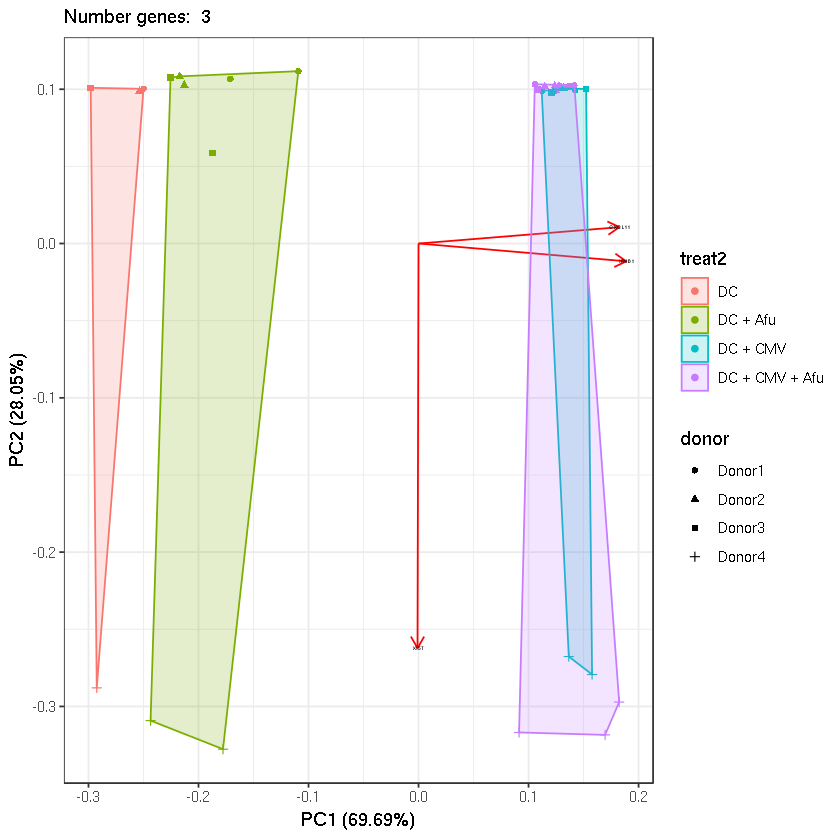

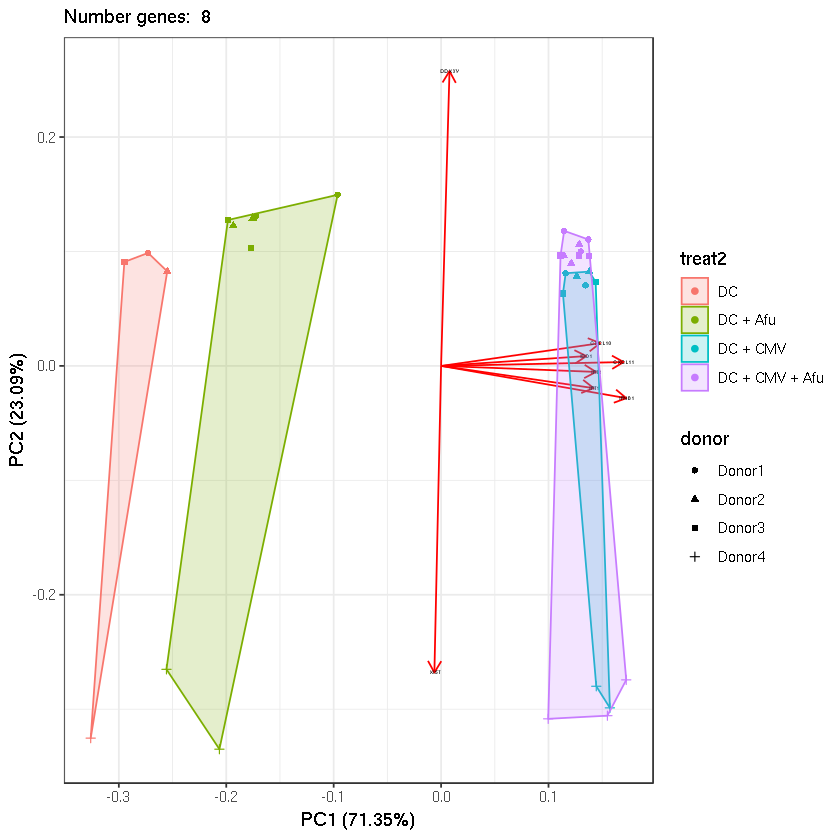

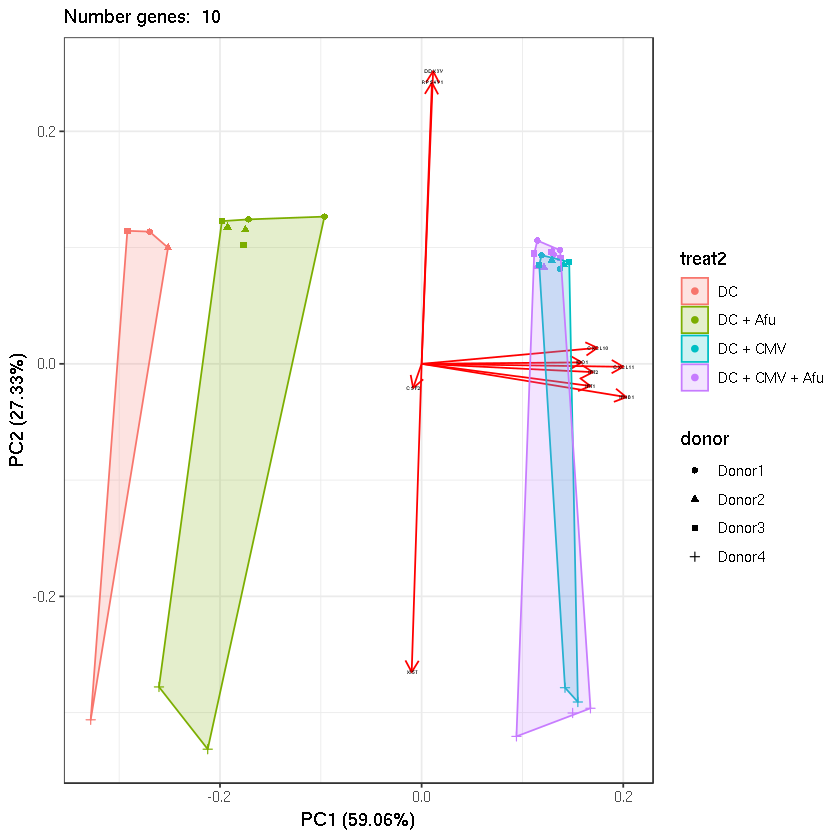

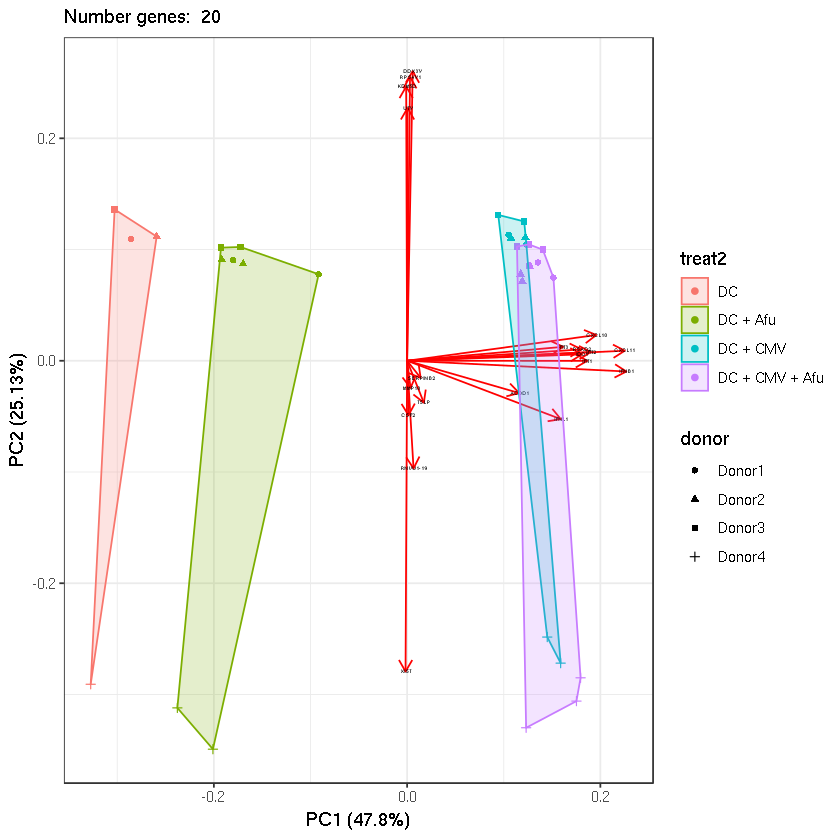

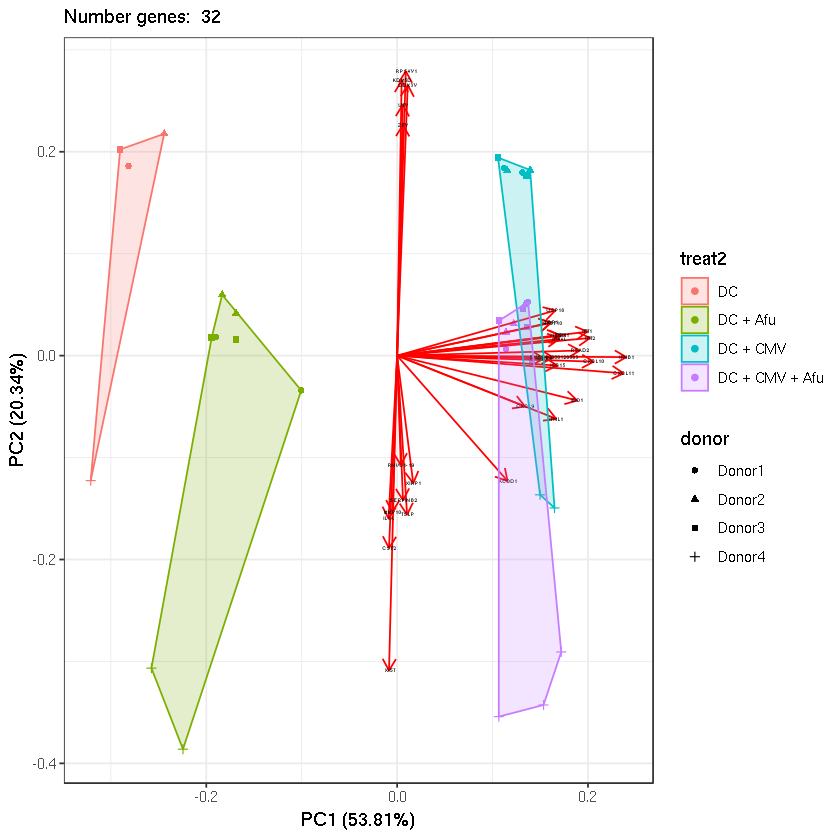

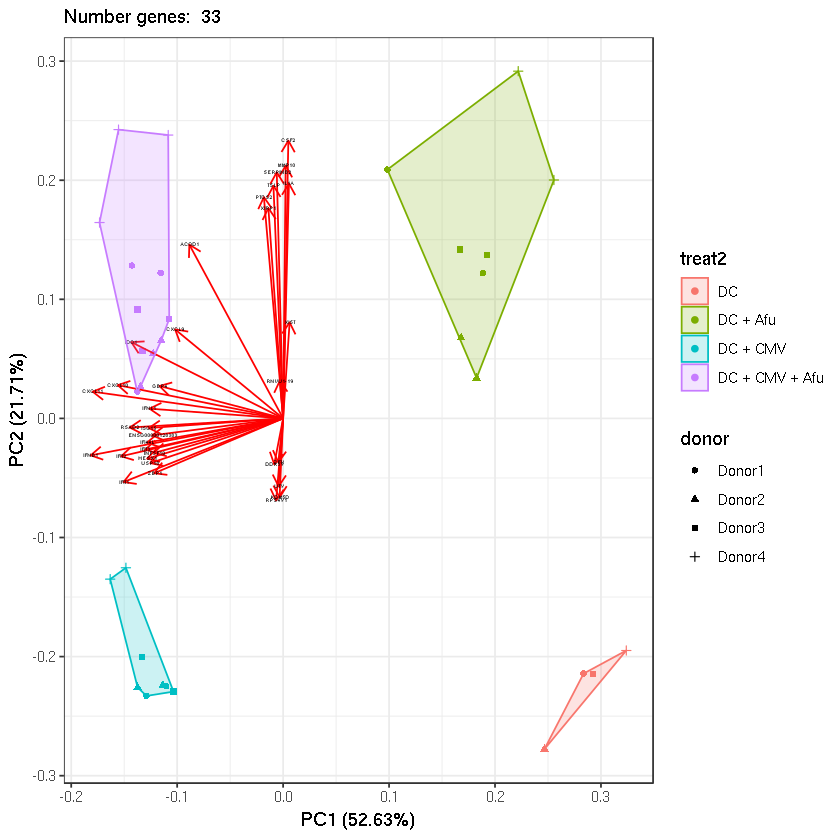

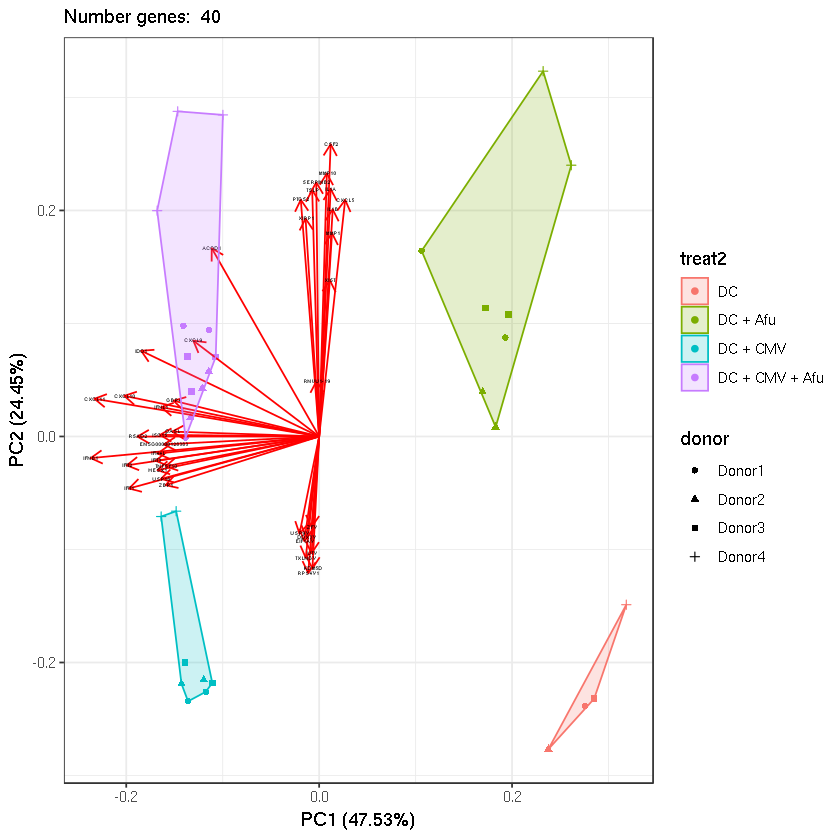

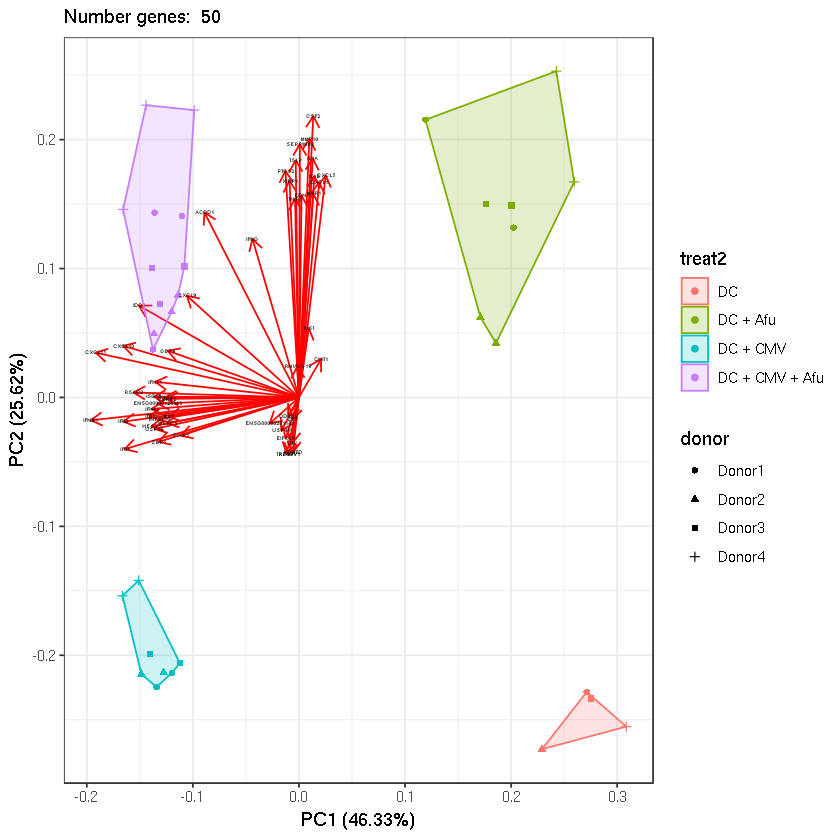

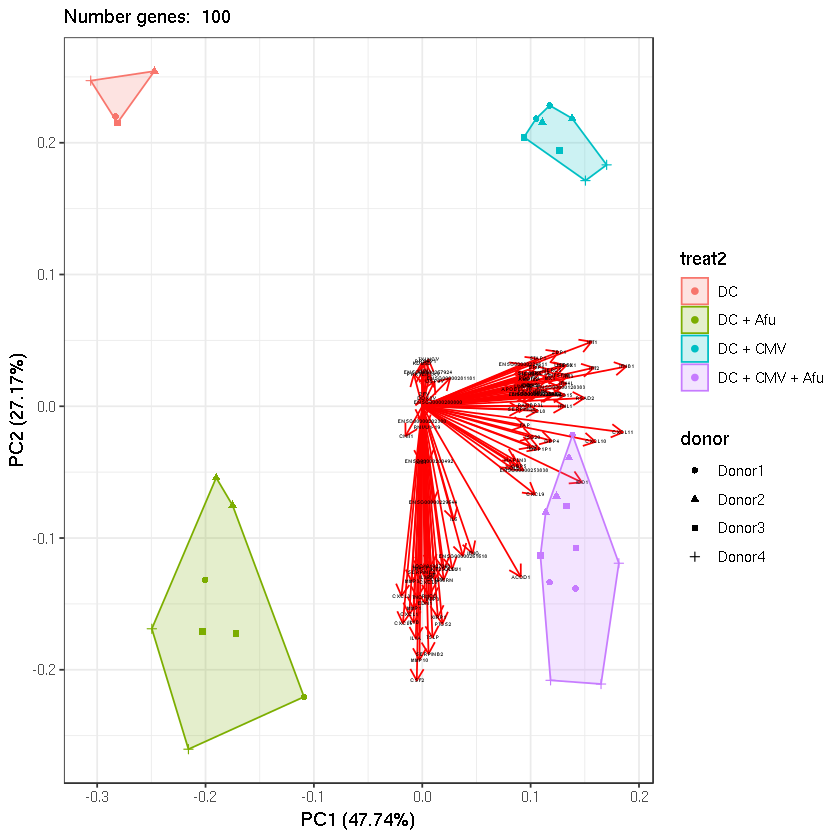

In [19]:
top_genes <- list()
pca_comps <- list()
#pdf("../results/other_plots/Hsapiens_PCA_mrn_topGenes.pdf")
test_set <- c(2,3,8,10,20,32,33,40,50,100)
for (i in test_set) {
    res <- plot_top_genes(counts_sp1.mrn, meta, i)
    top_genes <- c(top_genes, list(res$genes))
    pca_comps <- c(pca_comps, i = list(res$pca_comp))
    print(res$g)
}
names(top_genes) <- paste0("n", test_set)
names(pca_comps) <- paste0("n", test_set)
#dev.off()

Q: What changed from 32 to 33?

A: PTGS2

In [16]:
setdiff(top_genes$n33, top_genes$n32)

[1] "PTGS2"

In [17]:
symbol2ensembl("PTGS2")

[1] "ENSG00000073756"

Q: Check if that gene can be used to split up the classes in combination with the first 10, 20, etc. genes

A: no.

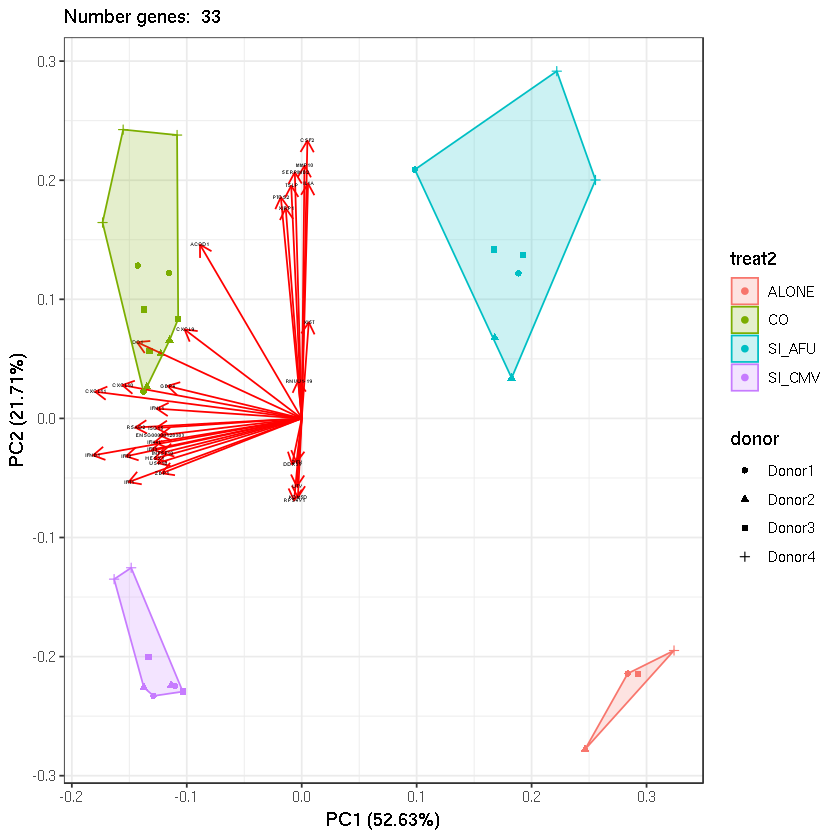

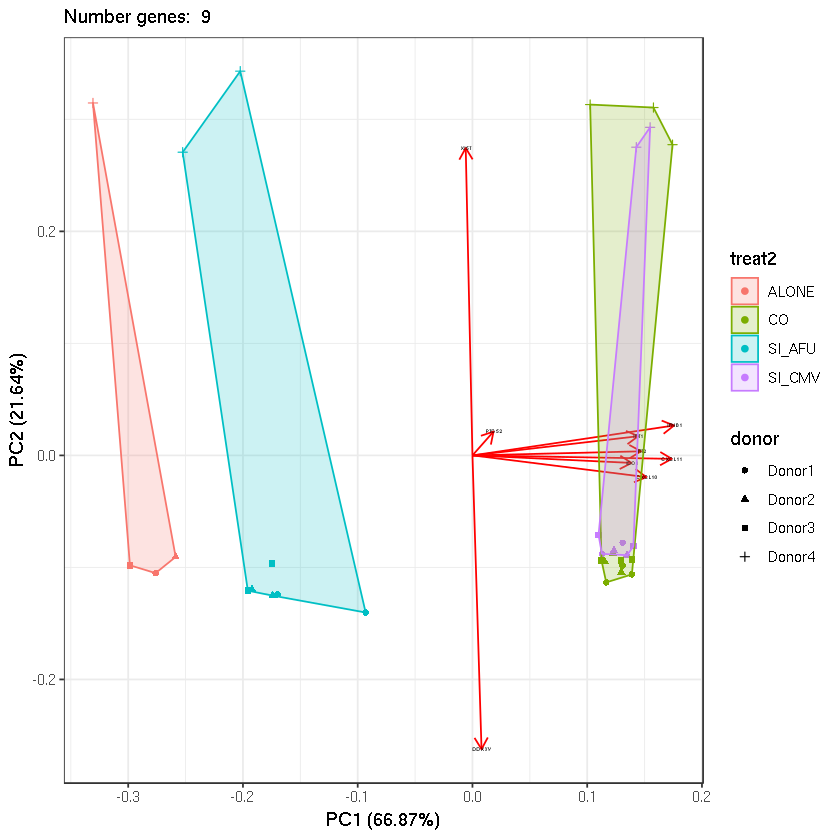

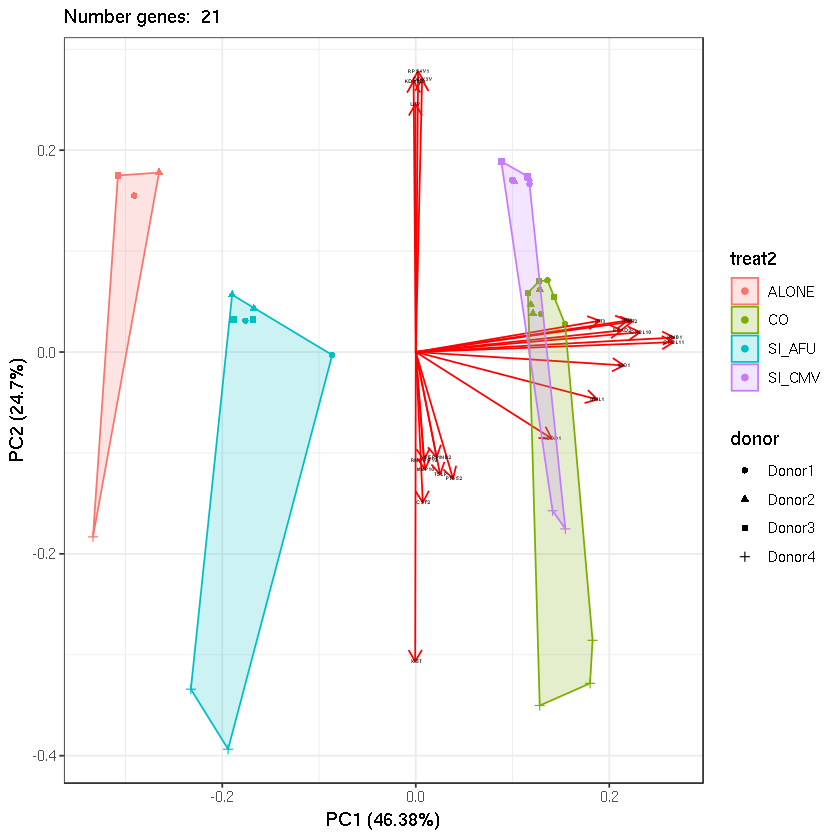

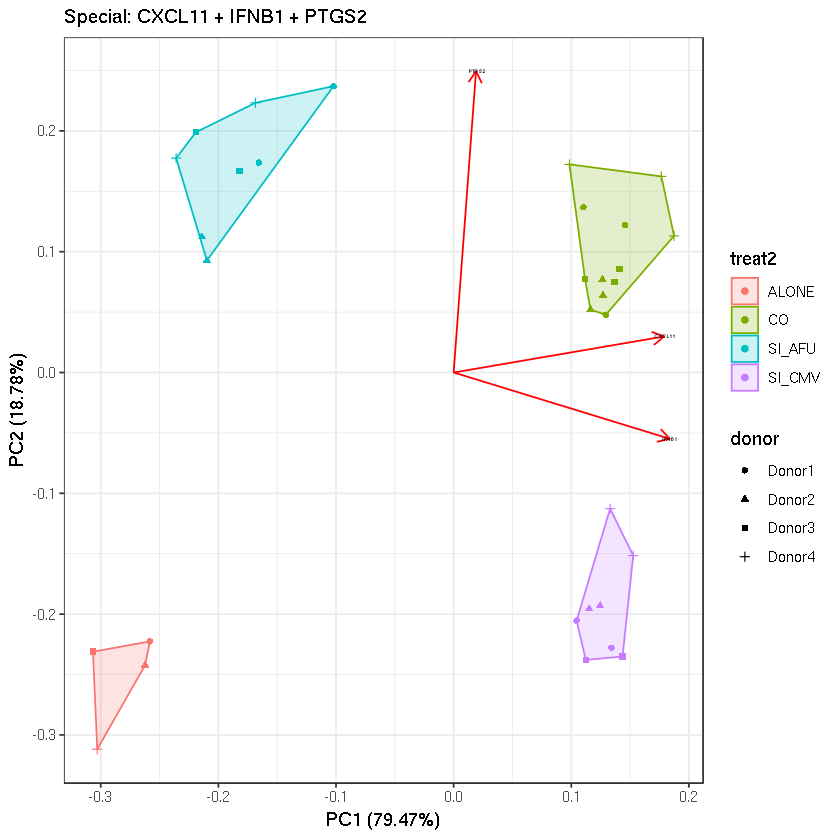

In [36]:
#pdf("../results/other_plots/Hsapiens_PCA_mrn_sel_genes.pdf")
plot_top_genes2(counts_sp1.mrn, meta, c(top_genes$n32, setdiff(top_genes$n33, top_genes$n32)))$g
plot_top_genes2(counts_sp1.mrn, meta, c(top_genes$n8, setdiff(top_genes$n33, top_genes$n32)))$g
plot_top_genes2(counts_sp1.mrn, meta, c(top_genes$n20, setdiff(top_genes$n33, top_genes$n32)))$g
plot_top_genes2(counts_sp1.mrn, meta, c(top_genes$n2, setdiff(top_genes$n33, top_genes$n32)))$g + ggtitle("Special: CXCL11 + IFNB1 + PTGS2")
#dev.off()

In [60]:
l <- list(
    hm_sel_genes(counts_sp1.mrn, meta, top_genes$n3),
    hm_sel_genes(counts_sp1.mrn, meta, top_genes$n10),
    hm_sel_genes(counts_sp1.mrn, meta, top_genes$n50),
    hm_sel_genes(counts_sp1.mrn, meta, c(top_genes$n2, setdiff(top_genes$n33, top_genes$n32))),
    hm_sel_genes(counts_sp1.mrn, meta, c(top_genes$n2, setdiff(top_genes$n33, top_genes$n32)), scale = T)
)
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_mrn_topVar.pdf")

png 
  2

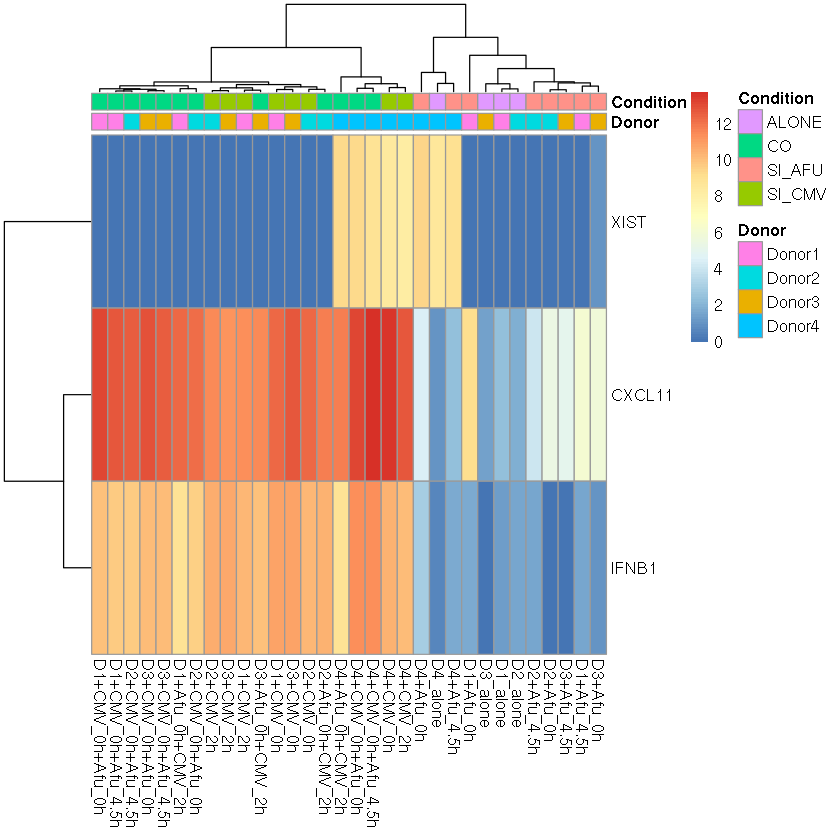

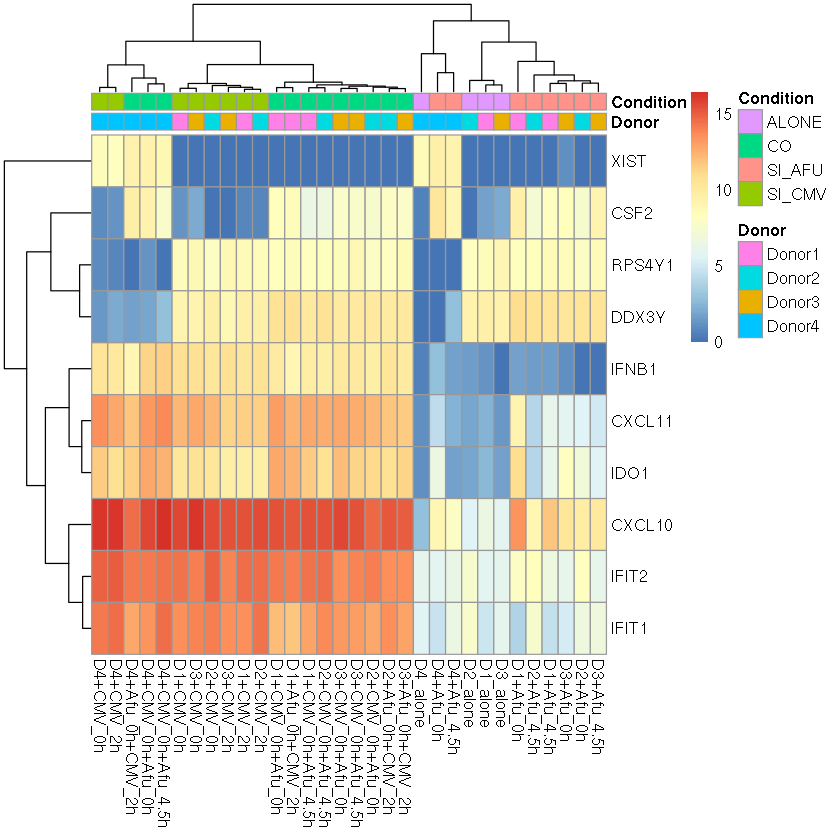

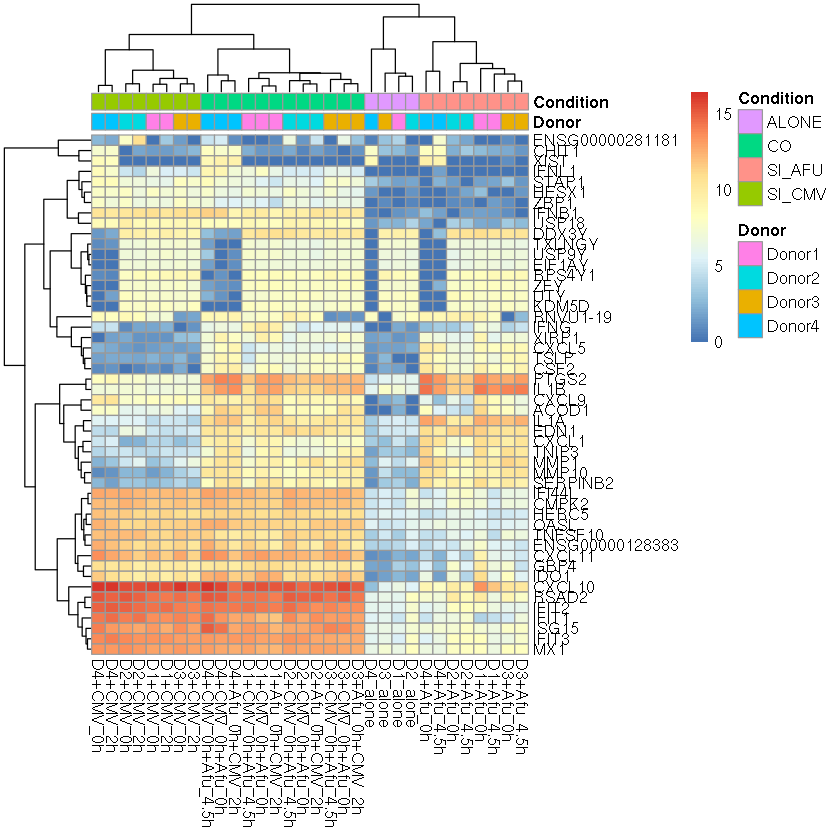

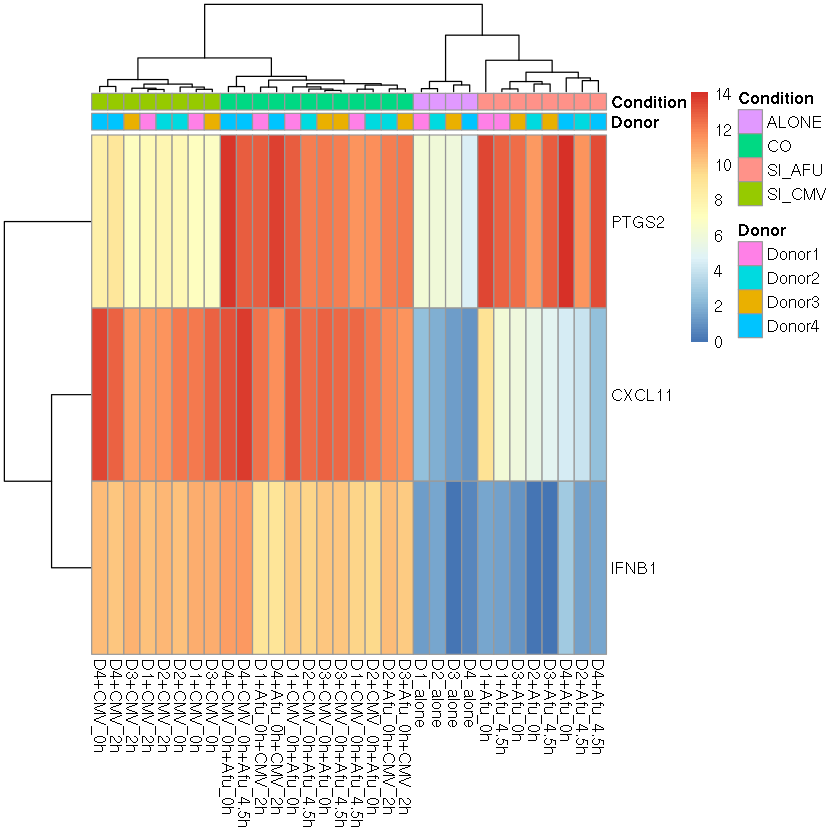

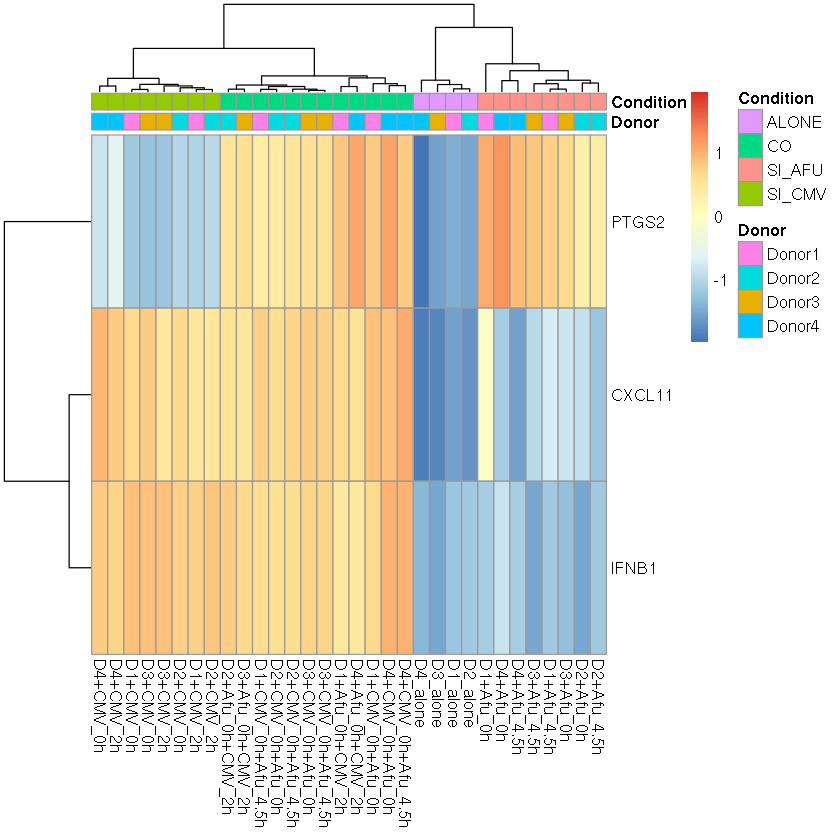

In [62]:
for(x in l) {
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
}

# Select Better Candidates

## Variance Based
* select DEG genes
* determine within-group variance for those
* order genes by lowest mean within-group variance

In [11]:
get_sign_genes_geo2 <- function(deg_res, lfc2 = 0, sigP = 0.01) {
    l <- lapply(deg_res, function(x) {
        # select tools
        tools <- grep("_adj_pval", x %>% colnames, value = T, fixed = T)
        keep1 <- x[,tools] %>% {. < sigP} %>% {rowSums(.) == length(tools)}
        keep2 <- x$log2_fc_mrn >= lfc2
        deg_genes <- rownames(x)[keep1 & keep2]

        return(deg_genes)
    })

    names(l) <- names(deg_res)
    return(l)
}

In [12]:
deg_sp1 <- readRDS("../results/DEG_overlaps/deg_res_sp1.rds")
deg_sp1_sig <- get_sign_genes_geo2(deg_sp1$DEGs)

In [13]:
candidate_genes <- Reduce(union, deg_sp1_sig)

In [14]:
symb <- ensembl2symbol(candidate_genes, na.rm = F, drop.ambiguous = T)
symb[is.na(symb)] <- candidate_genes[is.na(symb)]
candidate_genes <- symb

In [15]:
stopifnot(candidate_genes %in% rownames(counts_sp1.mrn))

In [16]:
counts_sp1.mrn.cand <- counts_sp1.mrn[candidate_genes,]

In [17]:
# remove zero abundance genes
counts_sp1.mrn.cand <- counts_sp1.mrn.cand[rowSums(counts_sp1.mrn.cand) > 0, ]

In [18]:
counts_sp1.mrn.long <- counts_sp1.mrn.cand %>% as.data.frame %>% mutate(gene = rownames(.)) %>% as.tibble %>%
    gather("Sample", "Abundance", -gene)
head(counts_sp1.mrn.long)

gene    Sample             Abundance
1 KLHL21  Donor1_01_DC_alone 7.022430 
2 MFSD2A  Donor1_01_DC_alone 7.628086 
3 HIVEP3  Donor1_01_DC_alone 6.518418 
4 ROR1    Donor1_01_DC_alone 2.786053 
5 GADD45A Donor1_01_DC_alone 4.858610 
6 GBP2    Donor1_01_DC_alone 7.756591

In [19]:
"ABHD16B" %in% counts_sp1.mrn.long$gene

[1] FALSE

In [20]:
counts_sp1.mrn.long <- left_join(counts_sp1.mrn.long, dplyr::select(meta, Specimen, treat, treat2), by = c("Sample" = "Specimen"))

Warning message:
“Column `Sample`/`Specimen` joining character vector and factor, coercing into character vector”

In [21]:
unique(meta$treat)
unique(meta$treat2)

[1] "DC_alone"                        "DC_plus_Afu_0h"                 
 [3] "DC_plus_Afu_4h30min"             "DC_plus_CMV_0h"                 
 [5] "DC_plus_CMV_0h_plus_Afu_0h"      "DC_plus_CMV_0h_plus_Afu_4h30min"
 [7] "DC_plus_Afu_0h_plus_CMV_2h"      "DC_plus_CMV_2h"                 
 [9] "Afu_alone_0h"                    "Afu_alone_4h30min"

[1] "ALONE"  "SI_AFU" "SI_CMV" "CO"

In [22]:
# Based on previous experience, there are only 4 major, separatele groups
counts_sp1.mrn.var <- counts_sp1.mrn.long %>% group_by(gene, treat2) %>% summarise(Variance = var(Abundance), MeanAbundance = mean(Abundance))

In [23]:
head(counts_sp1.mrn.var)

gene  treat2 Variance   MeanAbundance
1 AAED1 ALONE  0.02094520 7.3034905    
2 AAED1 CO     0.05203123 8.1932309    
3 AAED1 SI_AFU 0.04653355 7.5259483    
4 AAED1 SI_CMV 0.01416386 8.3084524    
5 AANAT ALONE  0.32350157 0.7004432    
6 AANAT CO     0.96659216 2.1146922

### WITHIN-VARIANCE

In [ ]:
# MINIMIZE WITHIN-VARIANCE
counts_sp1.mrn.var.mean <- ungroup(counts_sp1.mrn.var) %>% group_by(gene) %>%
    summarize(meanVar = mean(Variance), betVar = var(MeanAbundance)) %>%
    arrange(meanVar)

In [48]:
writexl::write_xlsx(counts_sp1.mrn.var.mean, "../results/PCA/homo.withinVariance.xlsx")

In [42]:
counts_sp1.mrn.var.mean <- readxl::read_excel("../results/PCA/homo.withinVariance.xlsx")

In [52]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, counts_sp1.mrn.var.mean$gene[1:50], scale = T))
l

Warning message in min(x, na.rm = T):
“no non-missing arguments to min; returning Inf”Warning message in max(x, na.rm = T):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in seq.default(-m, m, length.out = n + 1): 'from' must be a finite number


In [34]:
save_pheatmap_pdf(l, "../results/PCA/homo.withinVariance.heatmap.z.pdf")

png 
  2

[[1]]


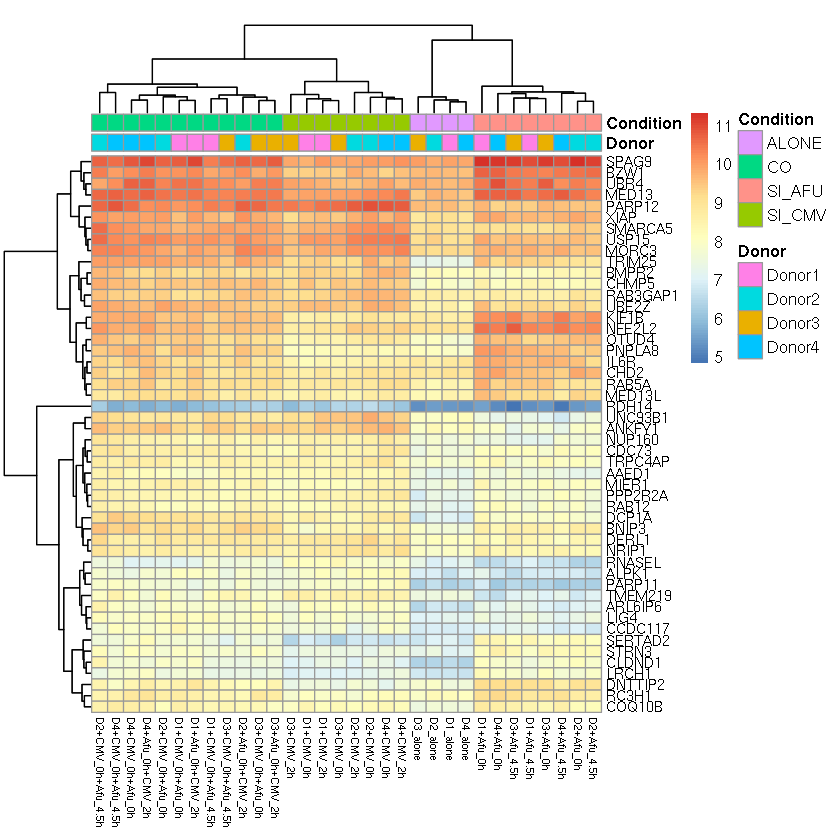

In [35]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, counts_sp1.mrn.var.mean$gene[1:50], scale = F))
l

In [36]:
save_pheatmap_pdf(l, "../results/PCA/homo.withinVariance.heatmap.pdf")

png 
  2

### BETWEEN-variance

In [25]:
# MAXIMIZE BETWEEN variance
counts_sp1.mrn.betVar <- ungroup(counts_sp1.mrn.var) %>% group_by(gene) %>%
    summarize(meanVar = mean(Variance), betVar = var(MeanAbundance)) %>%
    arrange(desc(betVar))

In [47]:
writexl::write_xlsx(counts_sp1.mrn.betVar, "../results/PCA/homo.betweenVariance.treat2.xlsx")

In [21]:
counts_sp1.mrn.betVar <- readxl::read_xlsx("../results/PCA/homo.betweenVariance.treat2.xlsx")

readxl works best with a newer version of the tibble package.
You currently have tibble v1.4.2.
Falling back to column name repair from tibble <= v1.4.2.
Message displays once per session.


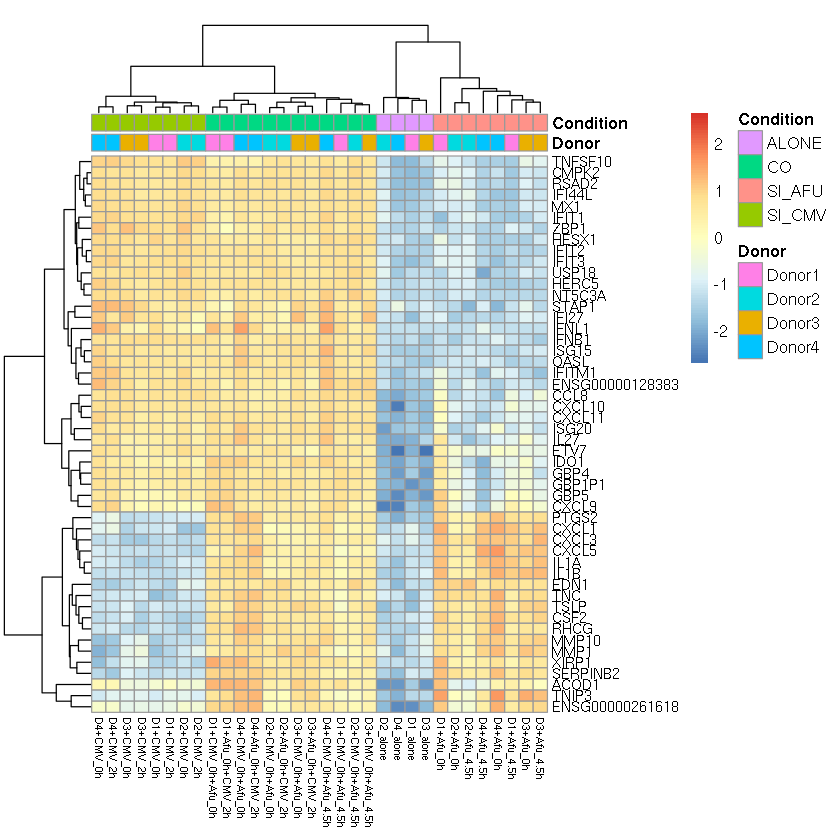

In [38]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, counts_sp1.mrn.betVar$gene[1:50], scale = T))

In [40]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.z.pdf")

png 
  2

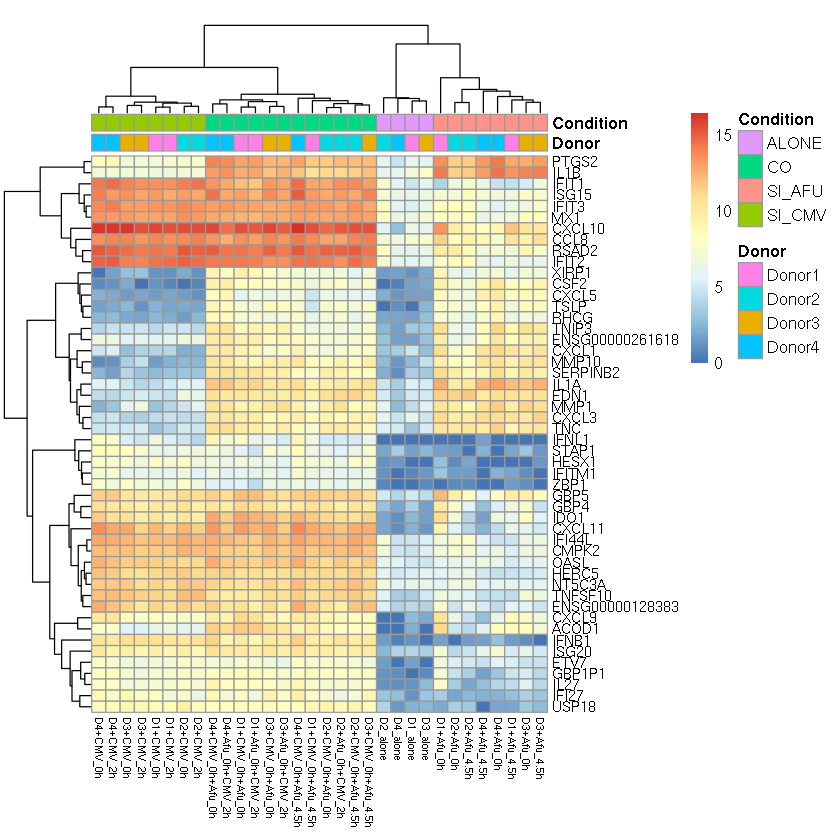

In [41]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, counts_sp1.mrn.betVar$gene[1:50], scale = F))

In [42]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.pdf")

png 
  2

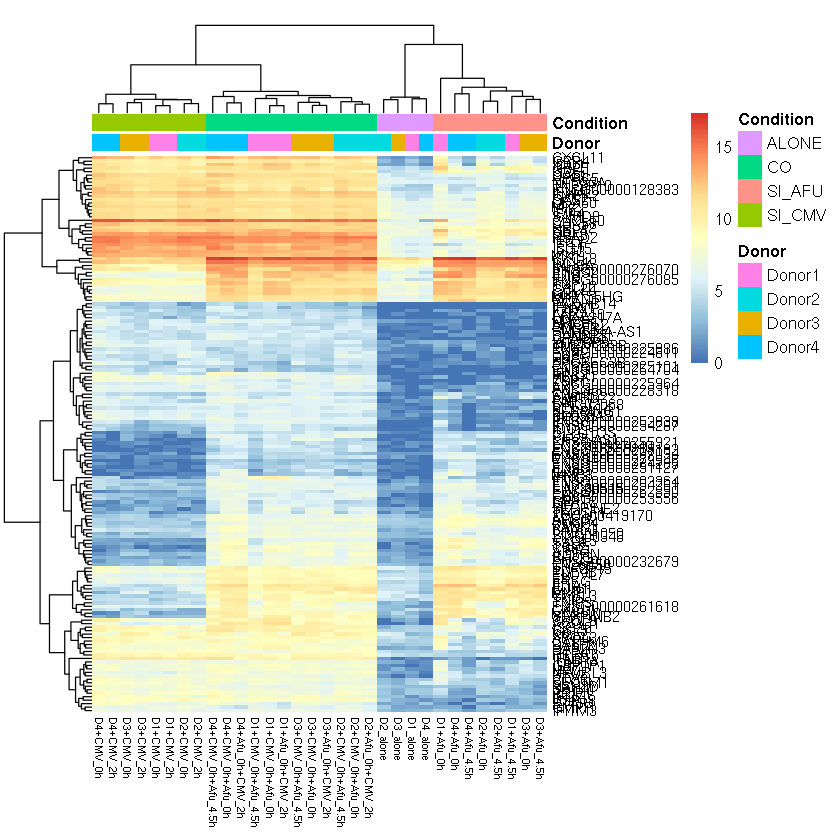

In [52]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, counts_sp1.mrn.betVar$gene[1:160], scale = F))

In [56]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.top160.pdf", height = 16, width = 8)

png 
  2

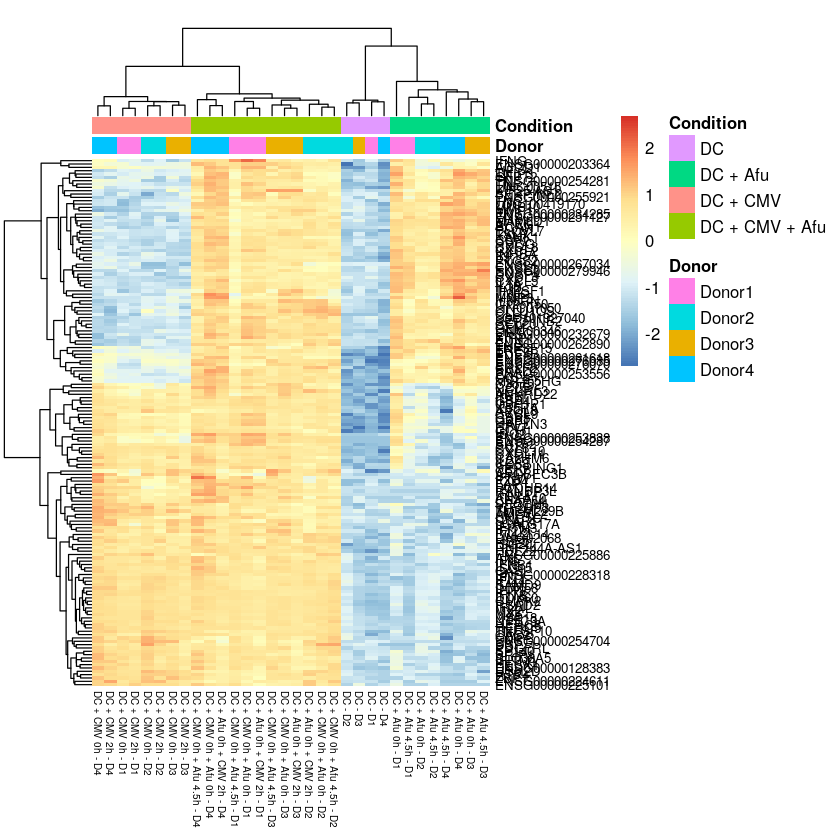

In [256]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, counts_sp1.mrn.betVar$gene[1:160], scale = T, cluster_cols = T))

In [257]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.top160.z.pdf", height = 16, width = 8)

png 
  2

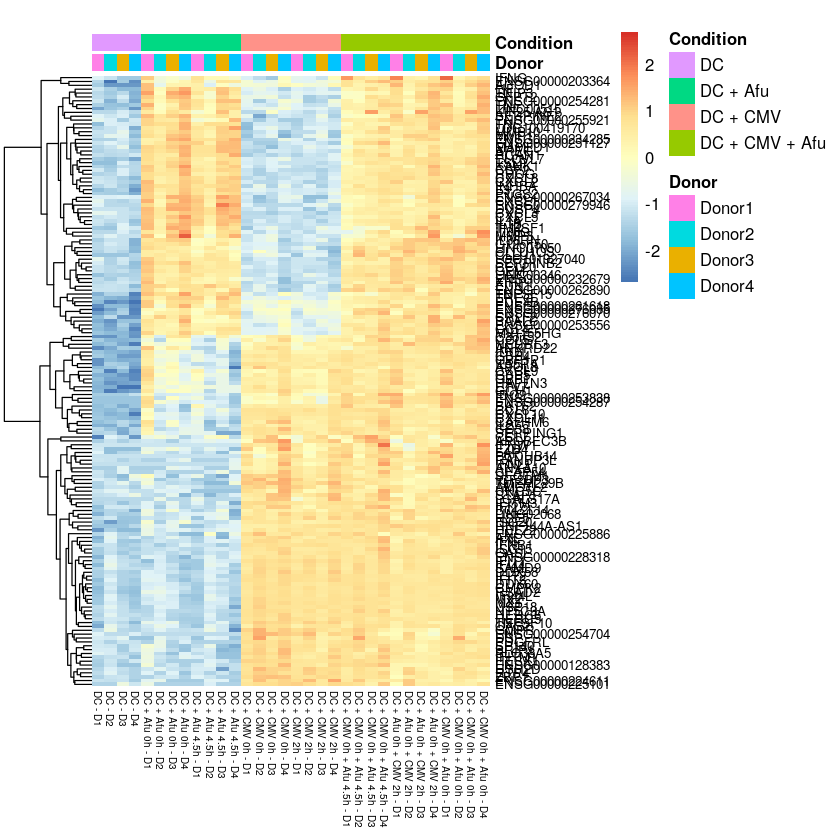

In [259]:
l <- list(hm_sel_genes(counts_sp1.mrn.ord, meta, counts_sp1.mrn.betVar$gene[1:160], scale = T))

In [260]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.top160.z.ord.pdf", height = 16, width = 8)

png 
  2

### variance vs mean

In [31]:
counts_sp1.mrn.comb <- mutate(counts_sp1.mrn.betVar, comb = meanVar * betVar)

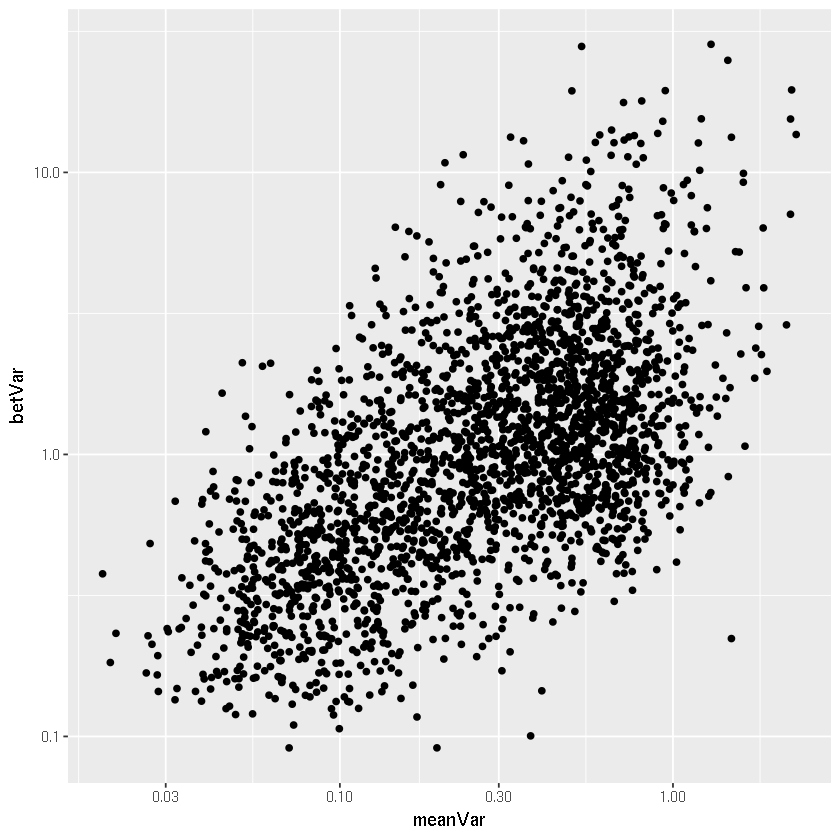

In [62]:
g <- ggplot(counts_sp1.mrn.comb, aes(x = meanVar, y = betVar, label = gene)) +
    geom_point() +
    scale_y_log10() +
    scale_x_log10()
g

In [64]:
ggsave("../results/PCA/homo.bet_vs_within_var.pdf", g, dpi = 300)

Saving 6.67 x 6.67 in image


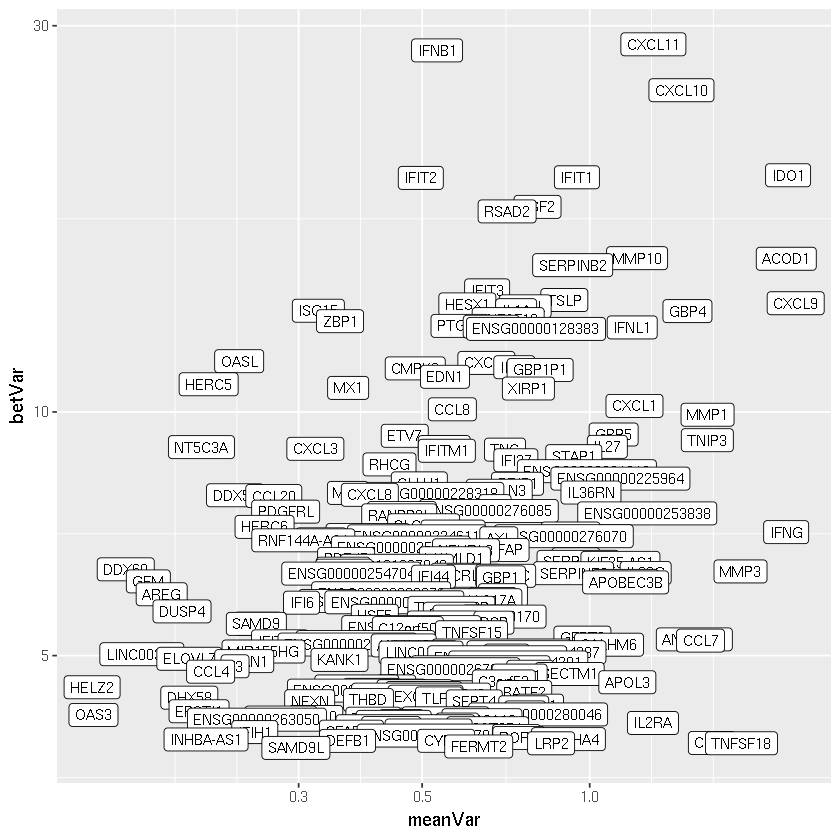

In [43]:
ggplot(counts_sp1.mrn.comb[1:200,], aes(x = meanVar, y = betVar, label = gene)) +
    geom_point() +
    scale_y_log10() +
    scale_x_log10() +
    geom_label(data = counts_sp1.mrn.comb[1:200,], size = 3)

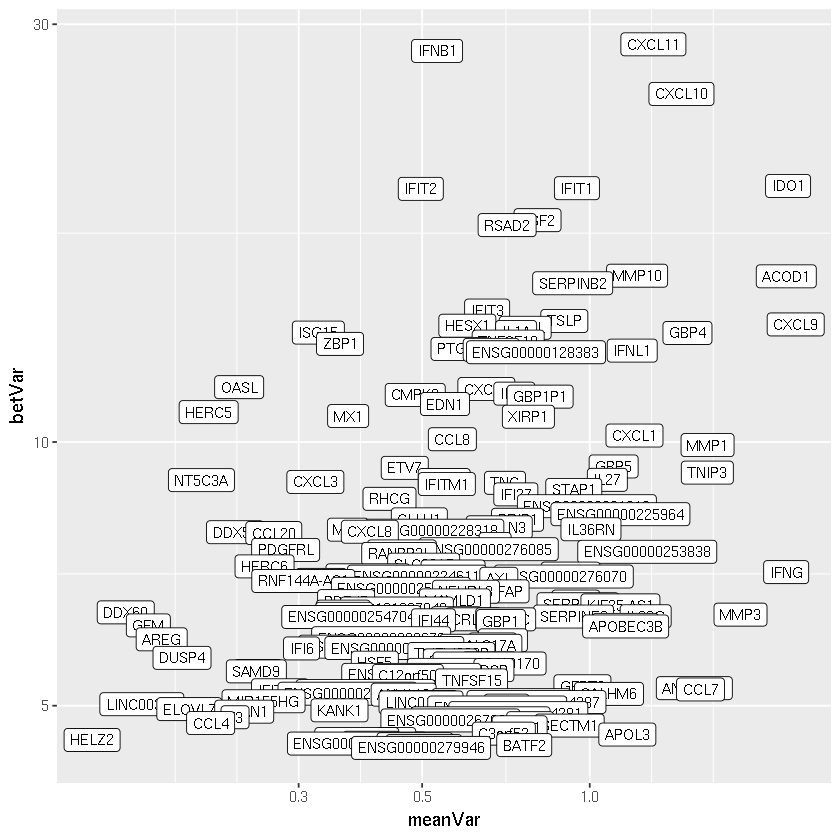

In [61]:
ggplot(counts_sp1.mrn.betVar[1:160,], aes(x = meanVar, y = betVar, label = gene)) +
    geom_point() +
    scale_y_log10() +
    scale_x_log10() +
    geom_label(data = counts_sp1.mrn.betVar[1:160,], size = 3)

### Filtered by InnateDB

In [240]:
innate_filtered <- read.csv("../results/PCA/homo.betweenVariance.treat2.innatedbFiltered.csv", sep = "")

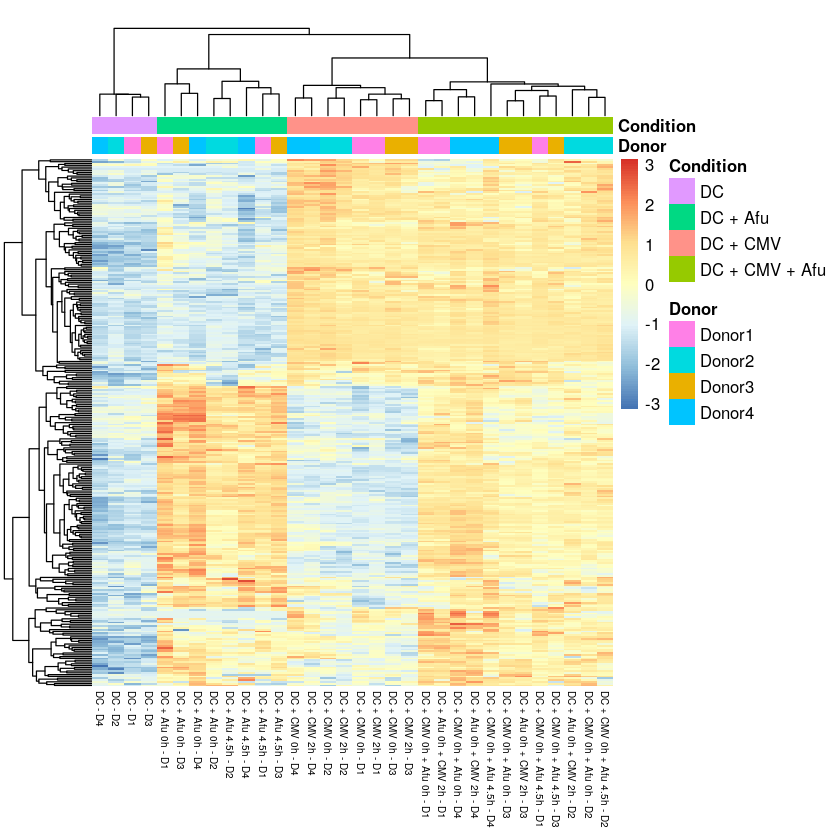

In [250]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, innate_filtered$gene, scale = T, row.names = F, cluster_cols = T))

In [251]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.innate.pdf")

png 
  2

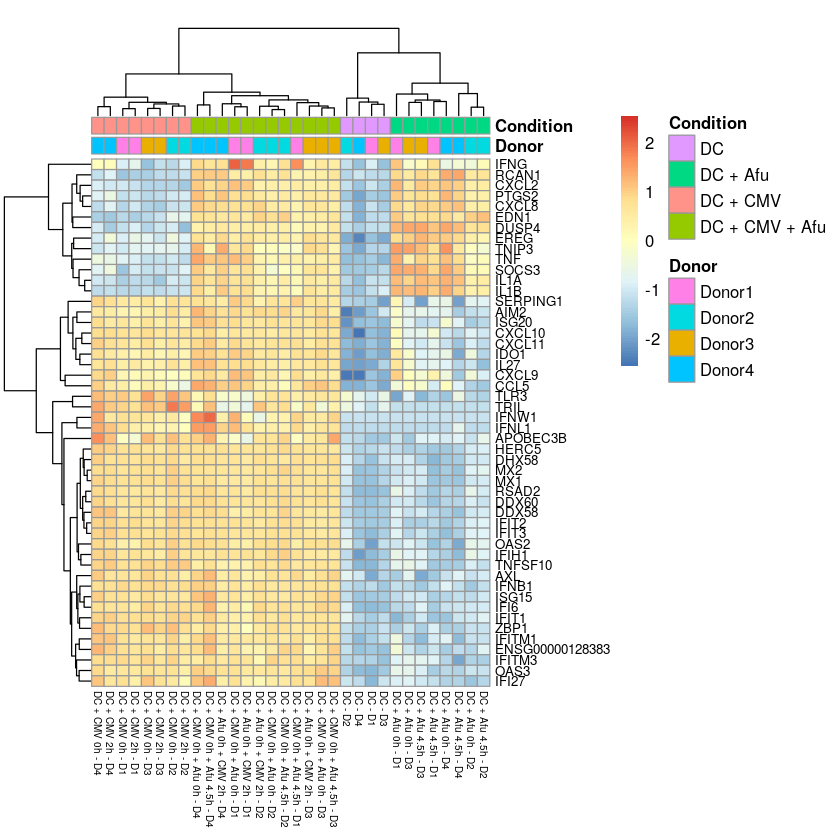

In [248]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, innate_filtered$gene[1:50], scale = T, row.names = T, cluster_cols = T))

In [249]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.innate.top50.z.pdf", height = 7)

png 
  2

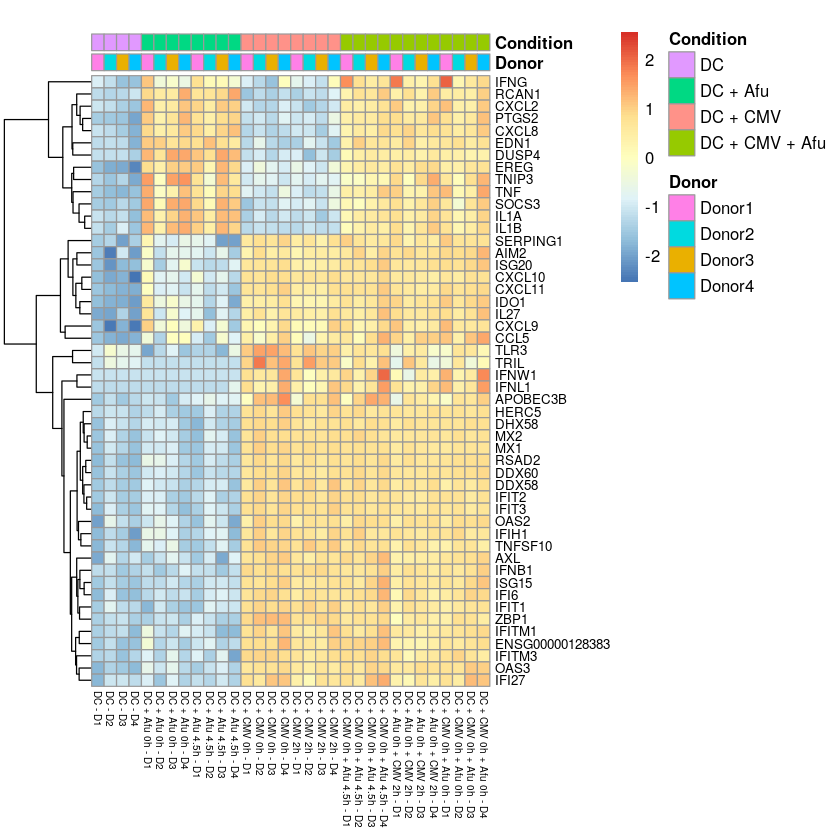

In [252]:
l <- list(hm_sel_genes(counts_sp1.mrn.ord, meta, innate_filtered$gene[1:50], scale = T, row.names = T))

In [253]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.innate.top50.z.ord.pdf", height = 7)

png 
  2

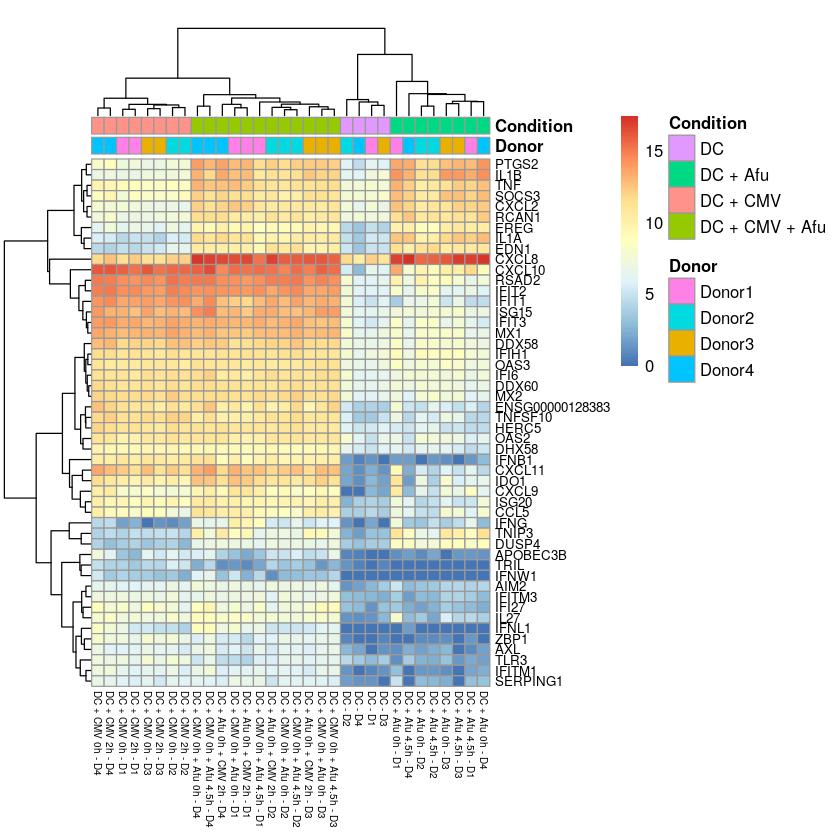

In [246]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, innate_filtered$gene[1:50], scale = F, row.names = T, cluster_cols = T))

In [247]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.innate.top50.pdf", height = 7)

png 
  2

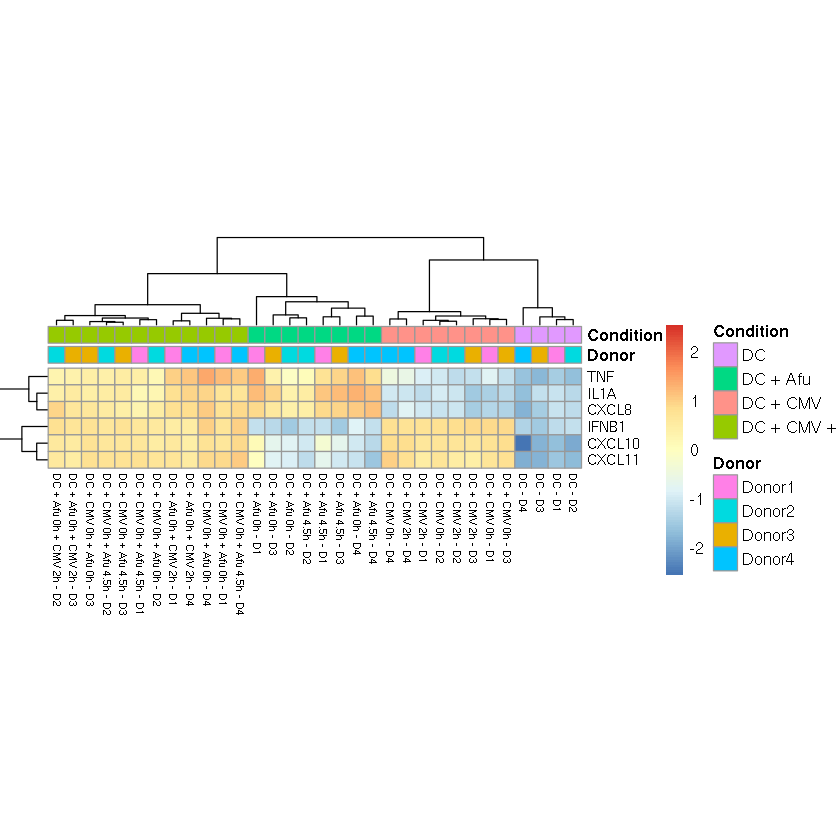

In [22]:
# now with our genes-of-interest
genes_of_interest <- c("CXCL11", "CXCL10", "IFNB1", "CXCL8", "IL1A", "TNF")
l <- list(hm_sel_genes(counts_sp1.mrn, meta, genes_of_interest, scale = T, row.names = T, cluster_cols = T, cell_size = 10))

In [23]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.innate.favored.z.pdf", height = 4)

png 
  2

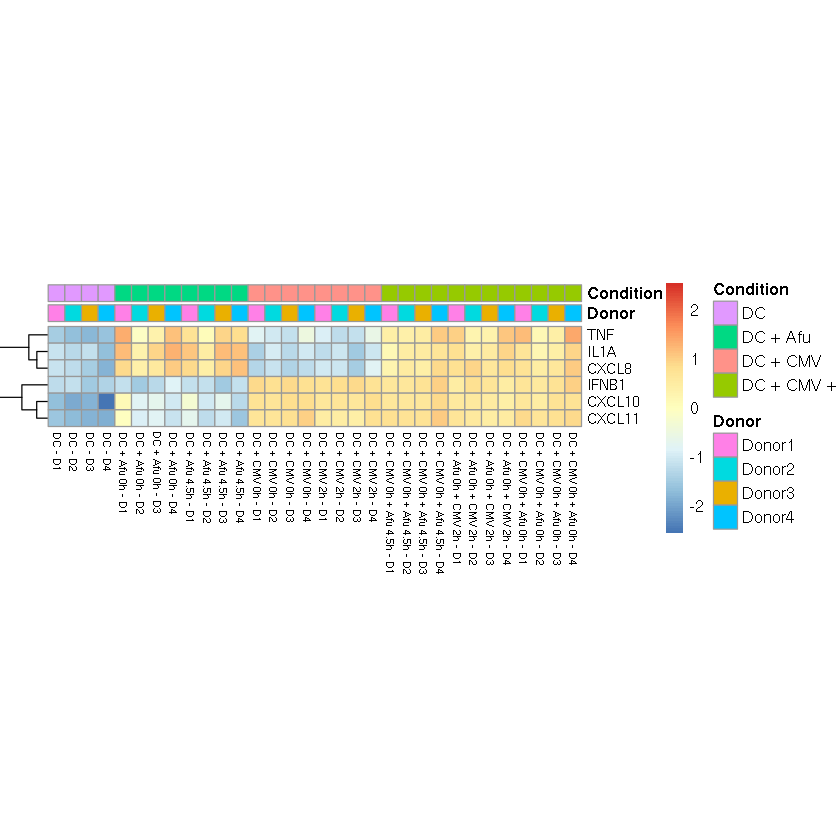

In [24]:
# now with our genes-of-interest
genes_of_interest <- c("CXCL11", "CXCL10", "IFNB1", "CXCL8", "IL1A", "TNF")
l <- list(hm_sel_genes(counts_sp1.mrn.ord, meta, genes_of_interest, scale = T, row.names = T, cluster_cols = F, cell_size = 10))

In [26]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.innate.favored.z.ord.pdf", width = 8)

png 
  2

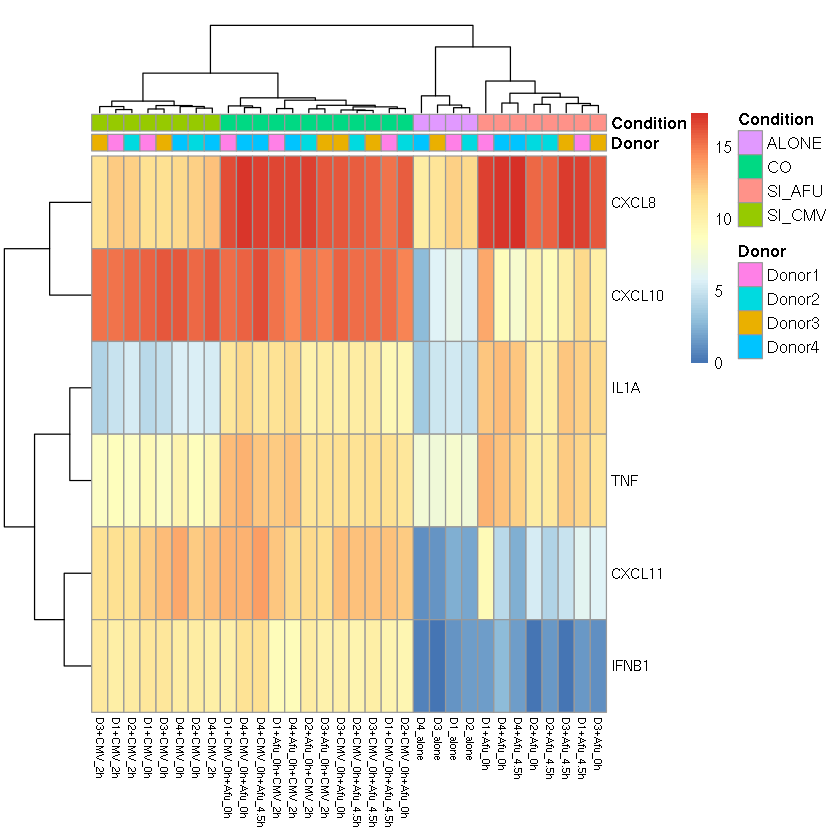

In [62]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, genes_of_interest, scale = F, row.names = T))

In [63]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.innate.favored.pdf", height = 4)

png 
  2

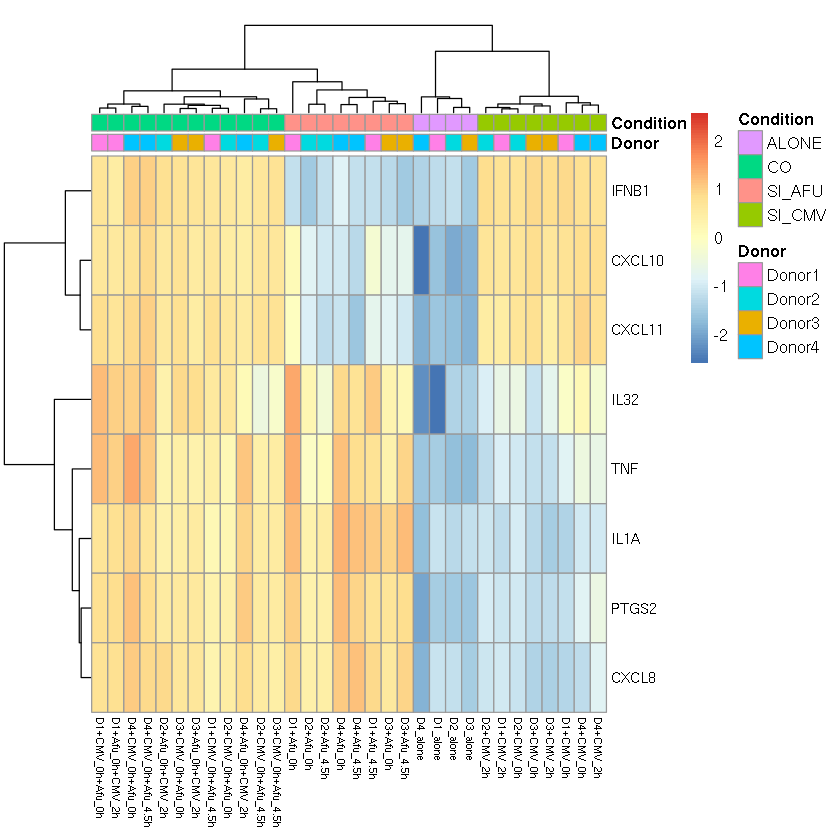

In [2236]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, c(genes_of_interest, "IL32"), scale = T, row.names = T))

In [2237]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.innate.favored.2.z.pdf", height = 4)

png 
  2

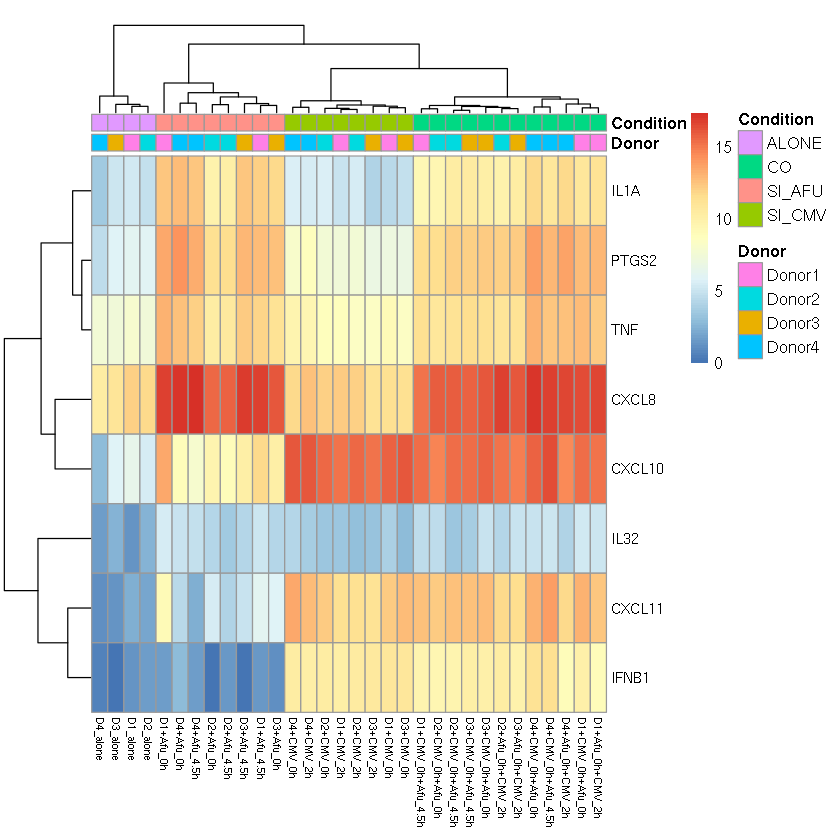

In [2234]:
l <- list(hm_sel_genes(counts_sp1.mrn, meta, c(genes_of_interest, "IL32"), scale = F, row.names = T))

In [2235]:
save_pheatmap_pdf(l, "../results/PCA/homo.betweenVariance.heatmap.innate.favored.2.pdf", height = 4)

png 
  2

## Correlation based

### PCA Candidates

Idea: we are looking for genes with similar profiles

That means, these genes should be highly correlated

In [14]:
sel_genes <- c("CXCL11", "PTGS2", "IFNB1")
prof <- counts_sp1.mrn[sel_genes, ]

In [24]:
cor(t(prof), method = "p")

CXCL11    PTGS2      IFNB1     
CXCL11 1.0000000 0.22056384 0.93480211
PTGS2  0.2205638 1.00000000 0.02101722
IFNB1  0.9348021 0.02101722 1.00000000

In [ ]:
# we learn: 
# PTGS2 and IFNB1 have relatively high linear correlation
# at least 95% pearson correlation should be required for any new candidate (or even higher!)

In [66]:
res <- cor(t(counts_sp1.mrn), t(prof))

Warning message in cor(t(counts_sp1.mrn), t(prof)):
“the standard deviation is zero”

In [67]:
res["CXCL11", ]
res["PTGS2", ]

CXCL11     PTGS2     IFNB1 
1.0000000 0.2205638 0.9348021

CXCL11      PTGS2      IFNB1 
0.22056384 1.00000000 0.02101722

In [108]:
inds <- which(res > 0.97, arr.ind = T)
inds <- cbind(inds, rho = res[inds])
inds <- inds %>% as.data.frame

In [109]:
inds[,"col"] <- sel_genes[inds[,"col"]]
inds$row <- rownames(counts_sp1.mrn)[inds$row]

In [110]:
inds <- inds %>% arrange(col, desc(rho))

In [122]:
inds

row             col    rho      
1  CXCL11          CXCL11 1.0000000
2  CXCL10          CXCL11 0.9797951
3  XRN1            CXCL11 0.9785800
4  EPSTI1          CXCL11 0.9756003
5  APOL6           CXCL11 0.9742307
6  CHMP5           CXCL11 0.9732752
7  PARP14          CXCL11 0.9718358
8  OAS3            CXCL11 0.9710822
9  DTX3L           CXCL11 0.9708885
10 STAT1           CXCL11 0.9704566
11 GBP1P1          CXCL11 0.9700295
12 IFNB1           IFNB1  1.0000000
13 OASL            IFNB1  0.9833907
14 NT5C3A          IFNB1  0.9790476
15 ISG15           IFNB1  0.9789162
16 DDX60           IFNB1  0.9743771
17 TOR1B           IFNB1  0.9716445
18 IFI6            IFNB1  0.9711384
19 IFIT2           IFNB1  0.9710496
20 TDRD7           IFNB1  0.9703033
21 PTGS2           PTGS2  1.0000000
22 NFKBIA          PTGS2  0.9875516
23 F3              PTGS2  0.9864568
24 ENSG00000226380 PTGS2  0.9841360
25 ELOVL7          PTGS2  0.9835794
26 IRAK2           PTGS2  0.9832321
27 CXCL8           PTGS2  0.9830680
28 TRAF1           PTGS2  0.9773457
29 ZC3H12C         PTGS2  0.9769719
30 IL1A            PTGS2  0.9764354
31 TNFAIP3         PTGS2  0.9749365
32 MIR155HG        PTGS2  0.9749262
33 TNF             PTGS2  0.9742103
34 DUSP2           PTGS2  0.9730559
35 INHBA           PTGS2  0.9730139
36 PNPLA8          PTGS2  0.9728659
37 ELL2            PTGS2  0.9723730
38 CXCL2           PTGS2  0.9721617

In [112]:
WriteXLS(inds, "../results/PCA/candidate_correlation_list.xls", BoldHeaderRow = T, FreezeRow = 1, row.names = F)

In [ ]:
# simple heat map :)

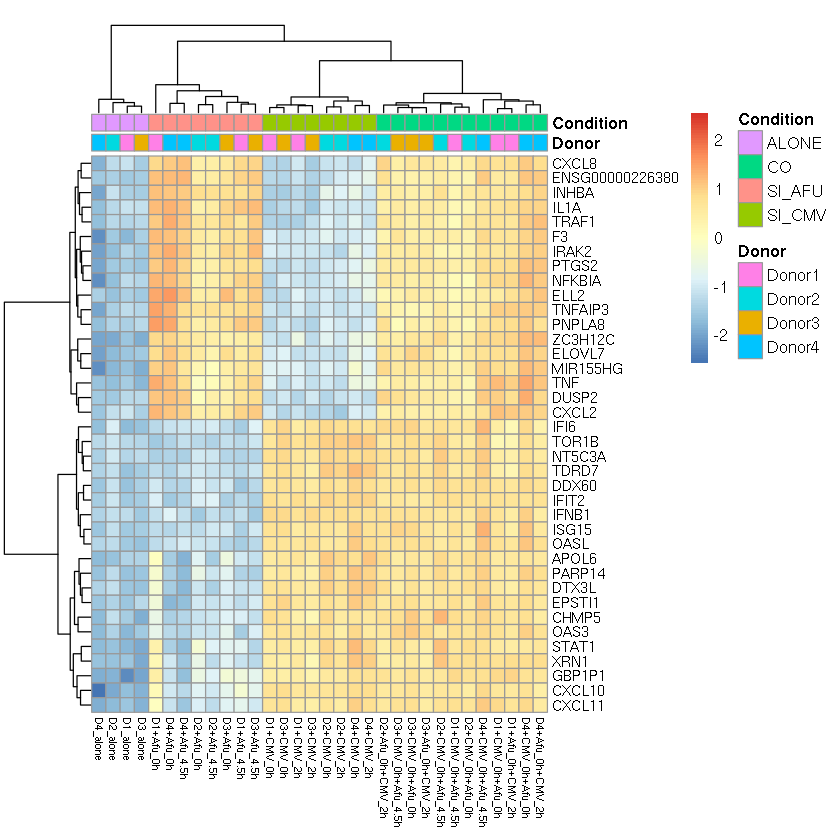

In [121]:
l <- hm_sel_genes(counts_sp1.mrn,
             meta,
             inds$row,
             row.names = T,
             scale = T)

In [124]:
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_candidate_correlation.pdf")

png 
  2

### Variance Selected Candidates

In [65]:
sel_genes <- c("CXCL11", "CXCL8")
prof <- counts_sp1.mrn[sel_genes, ]

In [66]:
cor(t(prof), method = "p")

CXCL11   CXCL8   
CXCL11 1.000000 0.120075
CXCL8  0.120075 1.000000

In [67]:
# we learn: 
# PTGS2 and IFNB1 have relatively high linear correlation
# at least 95% pearson correlation should be required for any new candidate (or even higher!)

In [79]:
res <- cor(t(counts_sp1.mrn), t(prof), method = "pearson")

Warning message in cor(t(counts_sp1.mrn), t(prof), method = "pearson"):
“the standard deviation is zero”

In [80]:
res["CXCL11", ]
res["CXCL8", ]

CXCL11    CXCL8 
1.000000 0.120075

CXCL11    CXCL8 
0.120075 1.000000

In [86]:
inds <- which(res > 0.90, arr.ind = T)
inds <- cbind(inds, rho = res[inds])
inds <- inds %>% as.data.frame

In [87]:
inds[,"col"] <- sel_genes[inds[,"col"]]
inds$row <- rownames(counts_sp1.mrn)[inds$row]

In [88]:
inds <- inds %>% arrange(col, desc(rho))

In [89]:
inds

row             col    rho      
1   CXCL11          CXCL11 1.0000000
2   CXCL10          CXCL11 0.9797951
3   XRN1            CXCL11 0.9785800
4   EPSTI1          CXCL11 0.9756003
5   APOL6           CXCL11 0.9742307
6   CHMP5           CXCL11 0.9732752
7   PARP14          CXCL11 0.9718358
8   OAS3            CXCL11 0.9710822
9   DTX3L           CXCL11 0.9708885
10  STAT1           CXCL11 0.9704566
11  GBP1P1          CXCL11 0.9700295
12  CCL8            CXCL11 0.9699833
13  NLRC5           CXCL11 0.9698171
14  CD38            CXCL11 0.9688411
15  GBP4            CXCL11 0.9688242
16  GTPBP1          CXCL11 0.9681219
17  STAT2           CXCL11 0.9675963
18  RSAD2           CXCL11 0.9673436
19  PML             CXCL11 0.9656842
20  IFIH1           CXCL11 0.9653592
21  PPM1K           CXCL11 0.9637115
22  APOL1           CXCL11 0.9633792
23  ENSG00000128383 CXCL11 0.9633444
24  IDO1            CXCL11 0.9632145
25  LINC02068       CXCL11 0.9631573
26  IFITM1          CXCL11 0.9626256
27  IL27            CXCL11 0.9618254
28  PHF11           CXCL11 0.9609087
29  IFITM3          CXCL11 0.9601885
30  HLA-F           CXCL11 0.9601551
⋮   ⋮               ⋮      ⋮        
353 ATF3            CXCL8  0.9073633
354 CD55            CXCL8  0.9071084
355 LOC101929709    CXCL8  0.9070814
356 EZH2            CXCL8  0.9062885
357 NUP188          CXCL8  0.9061573
358 ENSG00000270390 CXCL8  0.9058358
359 GADD45A         CXCL8  0.9055113
360 PHF19           CXCL8  0.9053701
361 UBTD2           CXCL8  0.9047461
362 PTGER4          CXCL8  0.9045906
363 MAPK6           CXCL8  0.9043786
364 ENSG00000269902 CXCL8  0.9042187
365 KLF5            CXCL8  0.9040413
366 ENSG00000232873 CXCL8  0.9035187
367 HILPDA          CXCL8  0.9034344
368 ENSG00000272506 CXCL8  0.9032983
369 EGR3            CXCL8  0.9032948
370 HOMER1          CXCL8  0.9032692
371 ENSG00000178104 CXCL8  0.9029017
372 CCL3            CXCL8  0.9028974
373 EGR4            CXCL8  0.9028371
374 SERPINE2        CXCL8  0.9022391
375 ENSG00000254330 CXCL8  0.9016582
376 CNKSR3          CXCL8  0.9016396
377 IER3            CXCL8  0.9013657
378 SERPINB9        CXCL8  0.9010322
379 IER2            CXCL8  0.9010198
380 ENSG00000274029 CXCL8  0.9008270
381 ENSG00000260196 CXCL8  0.9005697
382 DUSP5           CXCL8  0.9005614

In [90]:
WriteXLS(inds, "../results/PCA/candidate_correlation_list.betweenvar.xls", BoldHeaderRow = T, FreezeRow = 1, row.names = F)

### Plot selected candidates

In [23]:
cand1 <- c("PTGS2", "IFNB1")

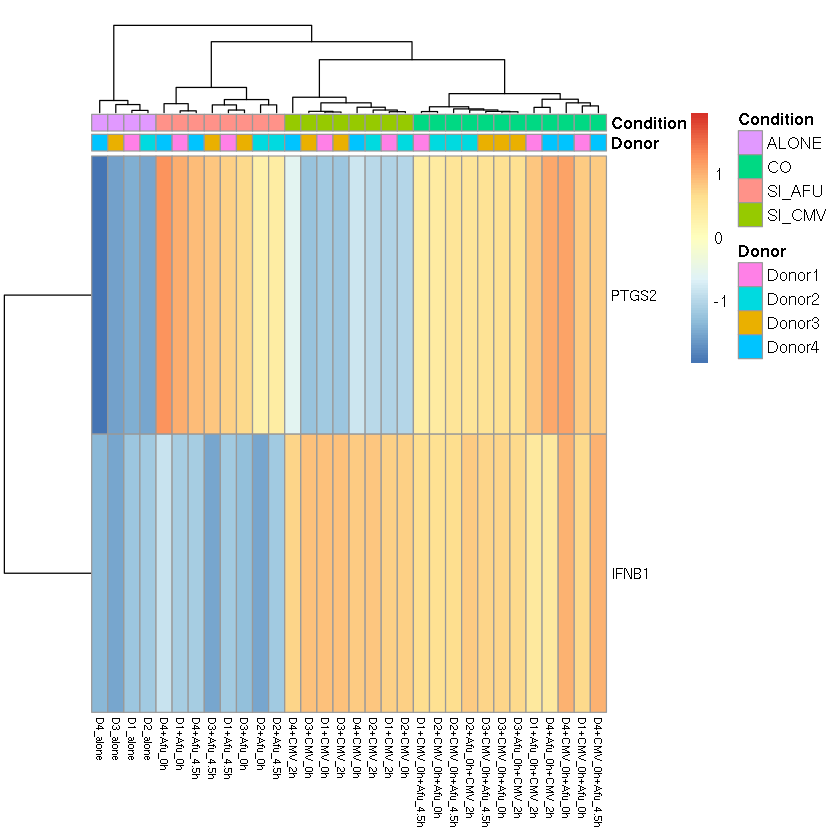

In [24]:
l <- hm_sel_genes(counts_sp1.mrn,
             meta,
             cand1,
             row.names = T,
             scale = T)

In [27]:
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_candidate_correlation.cand1.pdf")

png 
  2

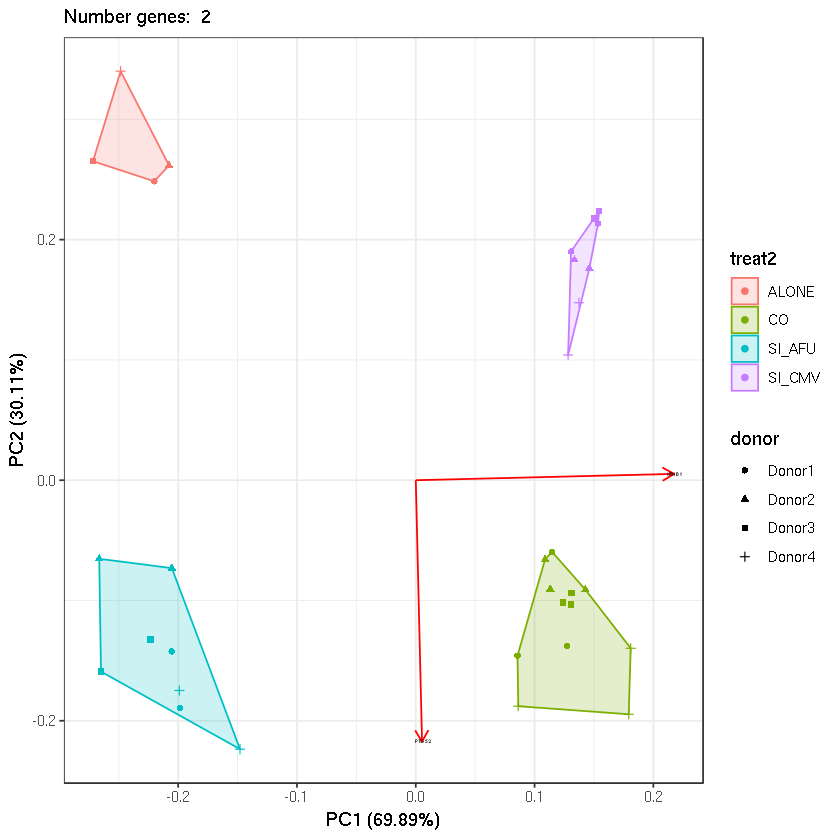

In [33]:
#pdf("../results/other_plots/Hsapiens_PCA_mrn_sel_genes.cand1.pdf")
plot_top_genes2(counts_sp1.mrn, meta, cand1)$g
#dev.off()

In [28]:
cand2 <- c("CXCL2", "IFI6")

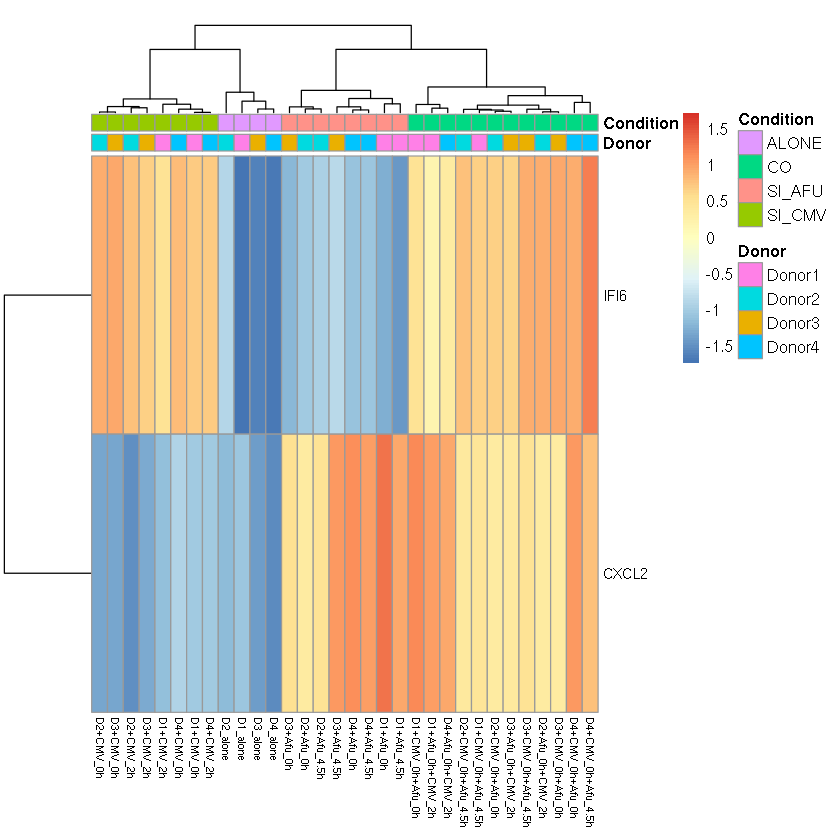

In [29]:
l <- hm_sel_genes(counts_sp1.mrn,
             meta,
             cand2,
             row.names = T,
             scale = T)

In [30]:
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_candidate_correlation.cand2.pdf")

png 
  2

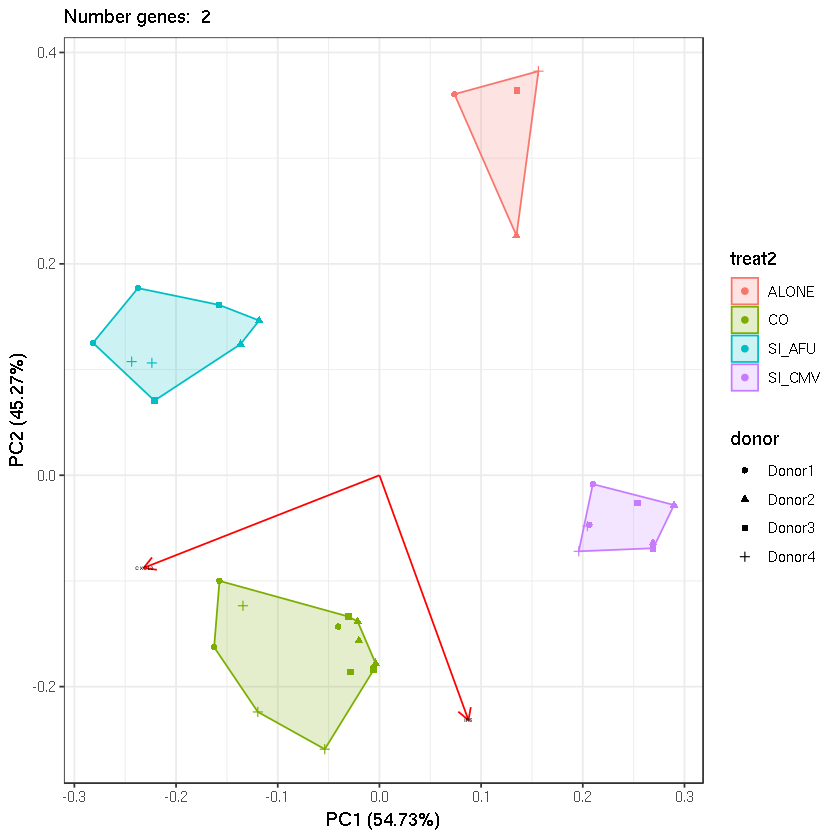

In [32]:
#pdf("../results/other_plots/Hsapiens_PCA_mrn_sel_genes.cand2.pdf")
plot_top_genes2(counts_sp1.mrn, meta, cand2)$g
#dev.off()

## Hull based
Just don't
This method could be used to select any set of 3 genes to split up the data
In this case, the hulls should be fully distinct

In [11]:
top_genes <- list()
pca_comps <- list()
#pdf("../results/other_plots/Hsapiens_PCA_mrn_topGenes.pdf")
test_set <- c(2)
sel_genes <- c("CXCL11", "IFNB1", "PTGS2")
for (i in test_set) {
    top_gene_mat <- counts_sp1.mrn[rownames(counts_sp1.mrn) %in% sel_genes,]
    pca_comp <- prcomp(top_gene_mat %>% t)
    pca_comp$x %>% select(PC1, PC2)
}

In [72]:
find_hull <- function(df) df[chull(df[,1], df[,2]), ]

In [73]:
# p : point
# mat : 2 column matrix
not_contained <- function(p, mat) {
    X <- mat[,1] + p[1] # increase X
    Y <- mat[,2] + p[2] # increase Y
    F %in% (find_hull(cbind(X, Y)) == find_hull(mat))
}

In [33]:
df <- pca_comp$x %>% 
    as.data.frame %>%
    mutate(Specimen = rownames(.)) %>%
    dplyr::select(Specimen, PC1, PC2) %>%
    left_join(meta %>% dplyr::select(Specimen, treat2))

Joining, by = "Specimen"
Warning message:
“Column `Specimen` joining character vector and factor, coercing into character vector”

In [43]:
df2 <- ddply(df, "treat2", find_hull)

In [50]:
df2 %>% filter(treat2 == "ALONE") %>% dplyr::select(PC1, PC2) ==
df2 %>% filter(treat2 == "ALONE") %>% dplyr::select(PC1, PC2) %>% find_hull()

PC1  PC2 
[1,] TRUE TRUE
[2,] TRUE TRUE
[3,] TRUE TRUE
[4,] TRUE TRUE

In [77]:
p <- df2 %>% filter(treat2 == "ALONE") %>% .[1,2:3]
mat <- df2 %>% filter(treat2 == "ALONE") %>% dplyr::select(PC1, PC2)
not_contained(df2 %>% filter(treat2 == "ALONE") %>% .[1,2:3],
              df2 %>% filter(treat2 == "ALONE") %>% dplyr::select(PC1, PC2))

ERROR: Error in Ops.data.frame(find_hull(cbind(X, Y)), find_hull(mat)): ‘==’ only defined for equally-sized data frames


In [75]:
X <- mat[,1] + p[1] # increase X
Y <- mat[,2] + p[2] # increase Y
chull(cbind(X, Y))
chull(mat)
F %in% (find_hull(cbind(X, Y)) == find_hull(mat))

[1] 1

[1] 1 2 3 4

ERROR: Error in Ops.data.frame(find_hull(cbind(X, Y)), find_hull(mat)): ‘==’ only defined for equally-sized data frames


# DEG Heatmaps

In [114]:
get_sign_genes_geo2 <- function(deg_res, with_fold = F, sigP = 0.01) {
    l <- lapply(deg_res, function(x) {
        # select tools
        tools <- grep("_adj_pval", x %>% colnames, value = T, fixed = T)
        if (!with_fold) {
            deg_genes <- x[,tools] %>% {. < sigP} %>% {rowSums(.) == length(tools)} %>% which %>% names
        } else {
            inds <- x[,tools] %>% {. < sigP} %>% {rowSums(.) == length(tools)} %>% which
            up <- x$log2_fc_mrn[inds] >= 0
            deg_genes <- paste0(rownames(x)[inds], ifelse(up, "+", "-"))
        }

        return(deg_genes)
    })

    names(l) <- names(deg_res)
    return(l)
}

In [2513]:
deg_res_sp1 <- readRDS("../results/DEG_overlaps/deg_res_sp1.rds")

In [66]:
head(deg_res_sp1$DEGs$CoInfection_Afu_first_vs_CoInfection)

id              mean_A_mrn mean_B_mrn log2_fc_mrn mean_A_tpm
ENSG00000223972 ENSG00000223972 1.000000   1.319604   -0.4001051  1.000000  
ENSG00000227232 ENSG00000227232 3.175378   2.043886    0.6356140  1.238907  
ENSG00000278267 ENSG00000278267 2.073012   1.519232    0.4483862  3.663527  
ENSG00000233750 ENSG00000233750 1.000000   1.337503   -0.4195425  1.000000  
ENSG00000269981 ENSG00000269981 1.188981   1.000000    0.2497251  1.202650  
ENSG00000241860 ENSG00000241860 2.083672   1.181729    0.8182289  1.028850  
                mean_B_tpm log2_fc_tpm mean_A_rpkm mean_B_rpkm fc_rpkm  
ENSG00000223972 1.021106   -0.03013200 1.000000    1.029696    0.9711606
ENSG00000227232 1.126711    0.13694995 1.297046    1.144770    1.1330183
ENSG00000278267 2.834489    0.37014491 4.029827    2.845670    1.4161259
ENSG00000233750 1.018901   -0.02701347 1.000000    1.021229    0.9792127
ENSG00000269981 1.000000    0.26621700 1.151682    1.000000    1.1516816
ENSG00000241860 1.008506    0.02881270 1.033067    1.007197    1.0256859
                log2_fc_rpkm DESeq DESeq_adj_pval DESeq2 DESeq2_adj_pval Limma
ENSG00000223972 -0.04221827  FALSE 1              FALSE  0.9999496       FALSE
ENSG00000227232  0.18017121  FALSE 1              FALSE  0.9999496       FALSE
ENSG00000278267  0.50194955  FALSE 1              FALSE  0.9999496       FALSE
ENSG00000233750 -0.03030578  FALSE 1              FALSE  0.9999496       FALSE
ENSG00000269981  0.20374187  FALSE 1              FALSE  0.9999496       FALSE
ENSG00000241860  0.03658897  FALSE 1              FALSE  0.9999496       FALSE
                Limma_adj_pval EdgeR EdgeR_adj_pval
ENSG00000223972 0.9493577      FALSE 1             
ENSG00000227232 0.9923786      FALSE 1             
ENSG00000278267 0.9493577      FALSE 1             
ENSG00000233750 0.9493577      FALSE 1             
ENSG00000269981 0.9544297      FALSE 1             
ENSG00000241860 0.9493577      FALSE 1

In [83]:
get_sign_genes_geo2(deg_res_sp1$DEGs, sigP = 0.05) %>% unlist %>% unique %>% length
get_sign_genes_geo2(deg_res_sp1$DEGs, sigP = 0.01) %>% unlist %>% unique %>% length
get_sign_genes_geo2(deg_res_sp1$DEGs, sigP = 0.001) %>% unlist %>% unique %>% length

[1] 5103

[1] 3403

[1] 2020

png 
  2

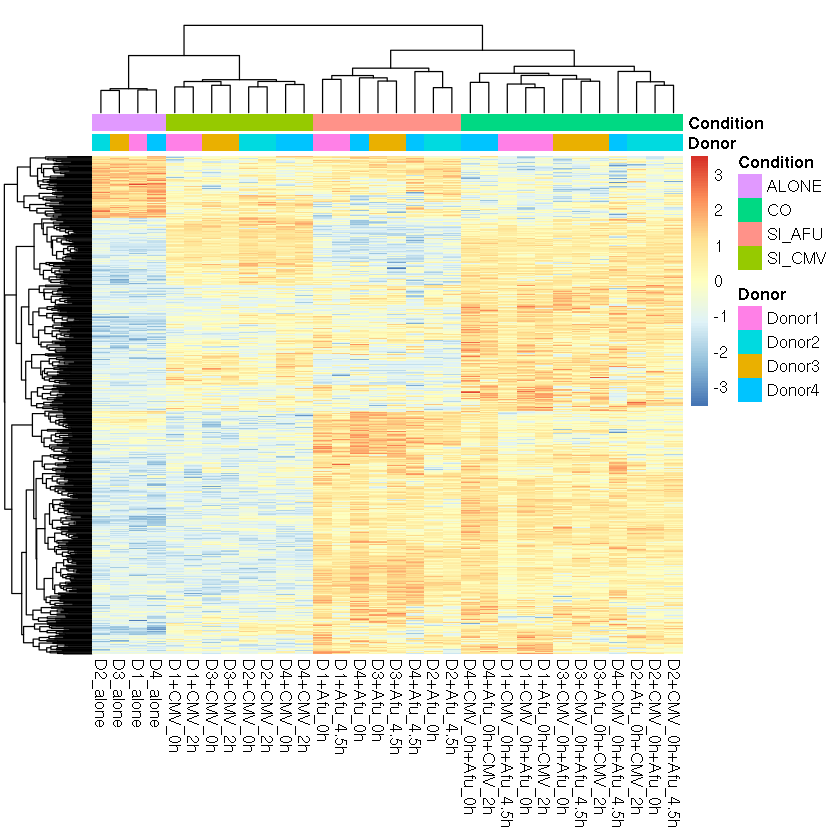

png 
  2

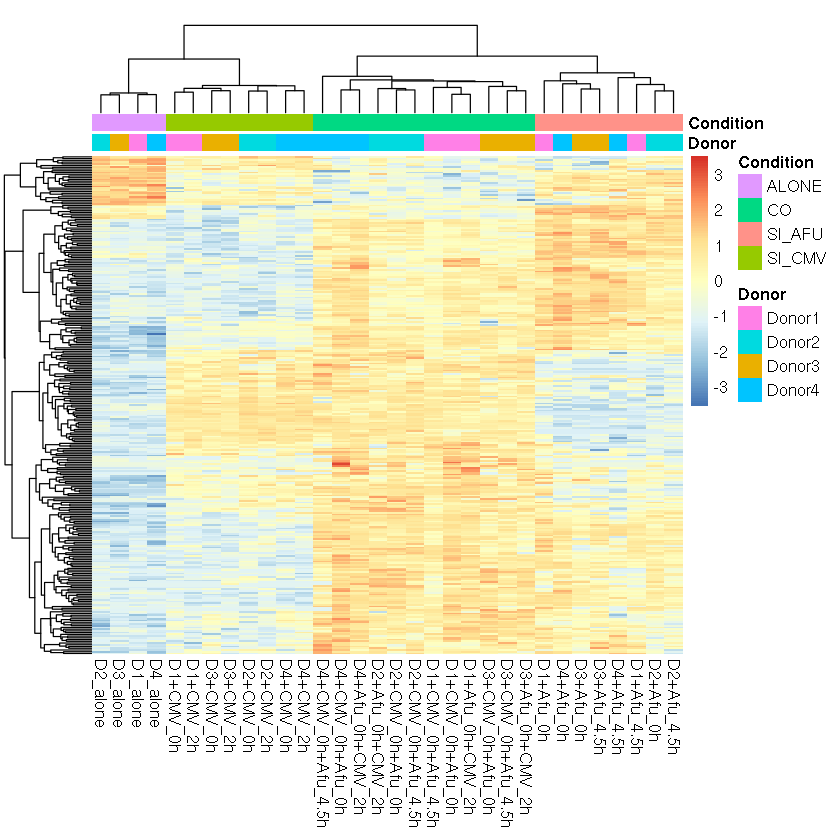

In [99]:
l <- hm_sel_genes(counts_sp1.mrn,
             meta,
             get_sign_genes_geo2(deg_res_sp1$DEGs, sigP = 0.01) %>% unlist %>% unique,
             row.names = F,
             scale = T)
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_topDEG_p0.01.pdf")
l <- hm_sel_genes(counts_sp1.mrn,
             meta,
             get_sign_genes_geo2(deg_res_sp1$DEGs, sigP = 0.001) %>% unlist %>% unique,
             row.names = F,
             scale = T)
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_topDEG_p0.001.pdf")

## CoI specific Genes

In [21]:
get_sign_genes_geo2 <- function(deg_res, lfc2 = 0, sigP = 0.01) {
    l <- lapply(deg_res, function(x) {
        # select tools
        tools <- grep("_adj_pval", x %>% colnames, value = T, fixed = T)

        inds_p <- x[,tools] %>% {. < sigP} %>% {rowSums(.) == length(tools)}
        inds_lfc <- abs(x$log2_fc_mrn) >= lfc2
        inds <- inds_p & inds_lfc
        deg_genes <- rownames(x)[inds]

        return(deg_genes)
    })

    names(l) <- names(deg_res)
    return(l)
}

get_items_per_intersection <- function(l) attr(venn(l, show.plot = F, ), "intersections")

rem_sign <- function(s) sub("[-|+]$", "", s)

In [2512]:
deg_res_sp1_3 <- readRDS("../results/DEG_overlaps/deg_res_sp1_3.rds")
deg_sp1_3 <- get_sign_genes_geo2(deg_res_sp1_3$DEGs, 1, 0.01) %>% unlist(use.names = F) %>% unique()
deg_sp1_3_sym <- to_symbol(deg_sp1_3)
deg_sp1_3_sym <- deg_sp1_3_sym[deg_sp1_3_sym != ""]

In [2563]:
meta <- meta %>% mutate(treat2 = factor(treat2, levels = c("ALONE", "SI_AFU", "SI_CMV", "CO")))

In [2564]:
# order samples by treatment type and donor
col_ord <- meta %>% arrange(treat2, donor) %>% .$Specimen
# check which samples are actually present
col_ord <- col_ord[col_ord %in% colnames(counts_sp1.mrn)]
counts_sp1.mrn.reorder <- counts_sp1.mrn[,col_ord]

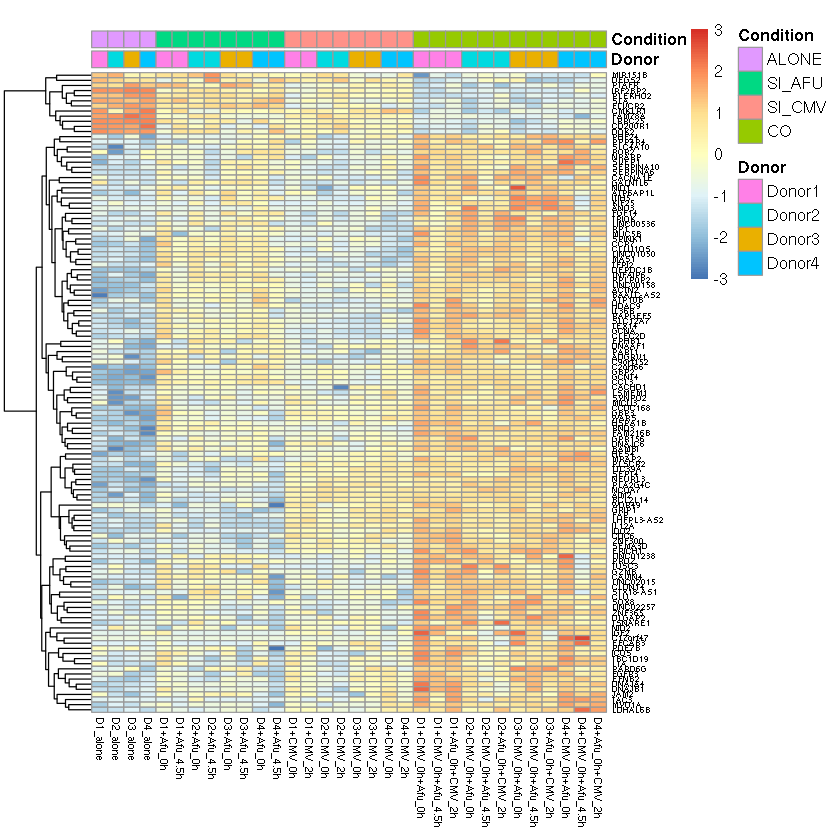

In [2565]:
l <- hm_sel_genes(counts_sp1.mrn.reorder,
             meta,
             deg_sp1_3_sym,
             row.names = T,
             fontsize = 4,
             scale = T)

In [2566]:
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_sp1_3_CoI_vs_SI.pdf")

png 
  2

In [2575]:
deg_res_sp1_4 <- readRDS("../results/DEG_overlaps/deg_res_sp1_4.rds")
deg_sp1_4 <- get_sign_genes_geo2(deg_res_sp1_4$DEGs, 1, 0.01) %>% unlist(use.names = F) %>% unique()
deg_sp1_4_sym <- to_symbol(deg_sp1_4)
deg_sp1_4_sym <- deg_sp1_4_sym[deg_sp1_4_sym != ""]

In [2578]:
counts_sp1.mrn.reorder.sub <- counts_sp1.mrn.reorder
counts_sp1.mrn.reorder.sub <- counts_sp1.mrn.reorder.sub[, !grepl("2h", colnames(counts_sp1.mrn.reorder.sub))]
counts_sp1.mrn.reorder.sub <- counts_sp1.mrn.reorder.sub[, !grepl("4h30min", colnames(counts_sp1.mrn.reorder.sub))]

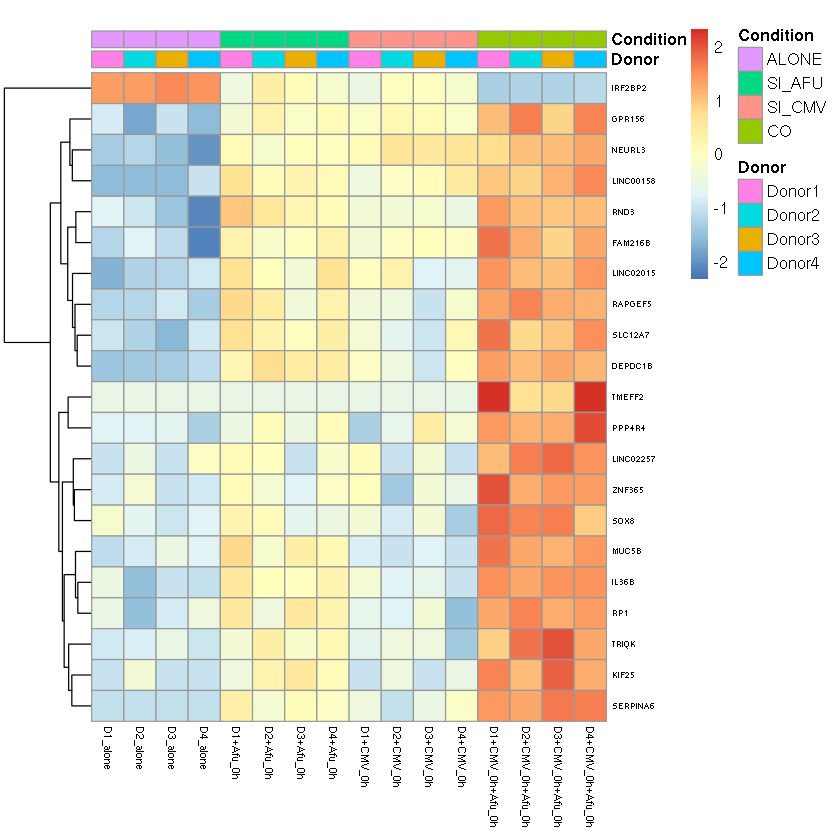

In [2580]:
l <- hm_sel_genes(counts_sp1.mrn.reorder.sub,
             meta,
             deg_sp1_4_sym,
             row.names = T,
             fontsize = 4,
             scale = T)

In [2581]:
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_sp1_4_CoI_0h_vs_SI_0h.pdf")

png 
  2

In [2582]:
CoI_specific_genes <- readxl::read_xlsx("../results/DEG_overlaps/CoI_specific_genes/CoI_specific_genes.xlsx")

In [2583]:
goi <- CoI_specific_genes$symbol %>% unique

Interesting Candidates:
* IRF2BP2 seems to be down regulated, especially in CoI
* ERICH1 to SERPINA6 are a class of CoI up-regulated genes
* CNKSR3 to VEGFA are about halve-expressed in CoI compared to SI_AFU

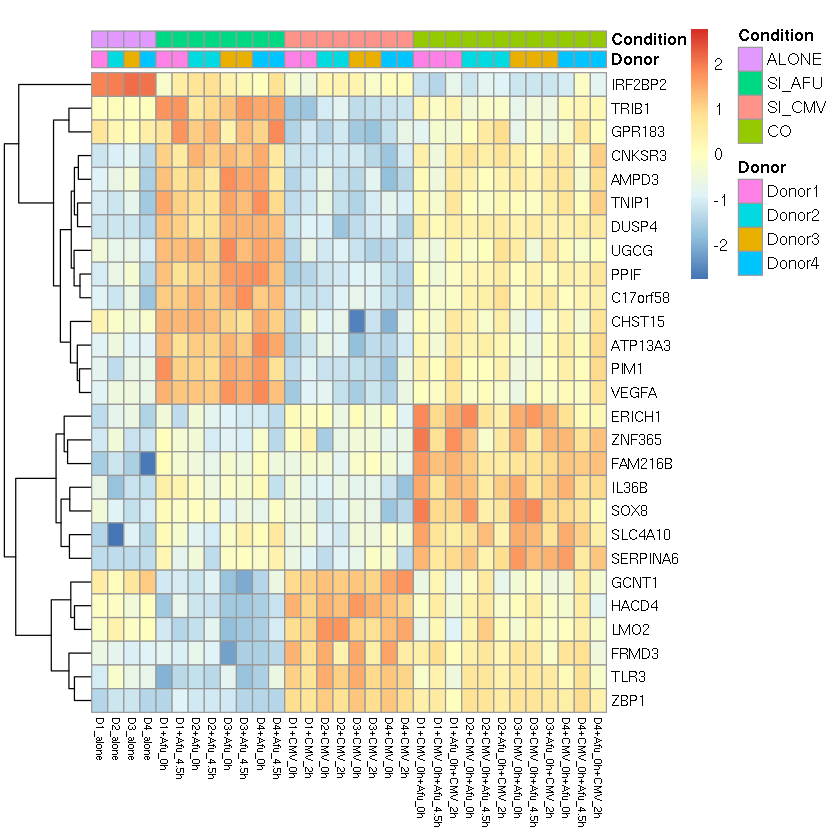

In [2569]:
l <- hm_sel_genes(counts_sp1.mrn.reorder,
             meta,
             goi,
             row.names = T,
             scale = T)

In [2570]:
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_CoI_specific_genes.pdf")

png 
  2

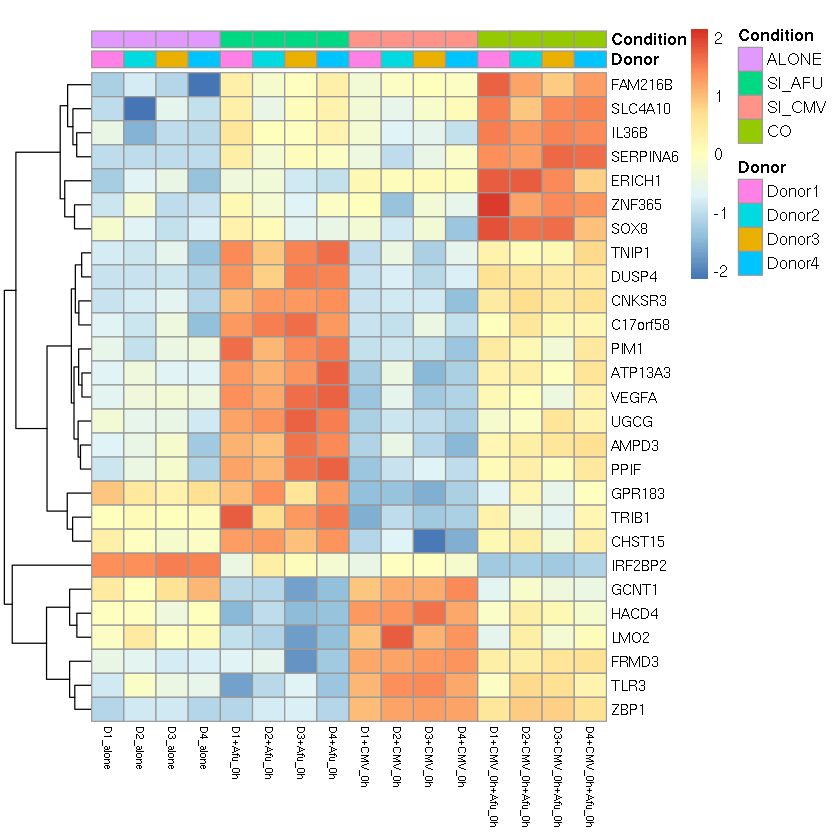

In [2584]:
# same figure, but only with 0h
counts_sp1.mrn.reorder.sub <- counts_sp1.mrn.reorder
counts_sp1.mrn.reorder.sub <- counts_sp1.mrn.reorder.sub[, !grepl("2h", colnames(counts_sp1.mrn.reorder.sub))]
counts_sp1.mrn.reorder.sub <- counts_sp1.mrn.reorder.sub[, !grepl("4h30min", colnames(counts_sp1.mrn.reorder.sub))]

l <- hm_sel_genes(counts_sp1.mrn.reorder.sub,
             meta,
             goi,
             row.names = T,
             scale = T)

In [2585]:
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_CoI_specific_genes.0h.pdf")

png 
  2

## lncRNA

In [14]:
library("tidyverse")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [7]:
linc_deg_file <- "../results/stats/Hsapiens_ncRNA/deg_lincRNA.xlsx"
sheets <- readxl::excel_sheets(linc_deg_file)
linc_deg_list <- lapply(sheets, function(s) readxl::read_xlsx(linc_deg_file, sheet = s))

In [15]:
deg_linc_names <- sapply(linc_deg_list, function(d) d$id) %>% unlist(use.names = F) %>% unique

Warning message:
“Unknown or uninitialised column: 'id'.”Warning message:
“Unknown or uninitialised column: 'id'.”Warning message:
“Unknown or uninitialised column: 'id'.”

In [31]:
length(deg_linc_names)

[1] 343

png 
  2

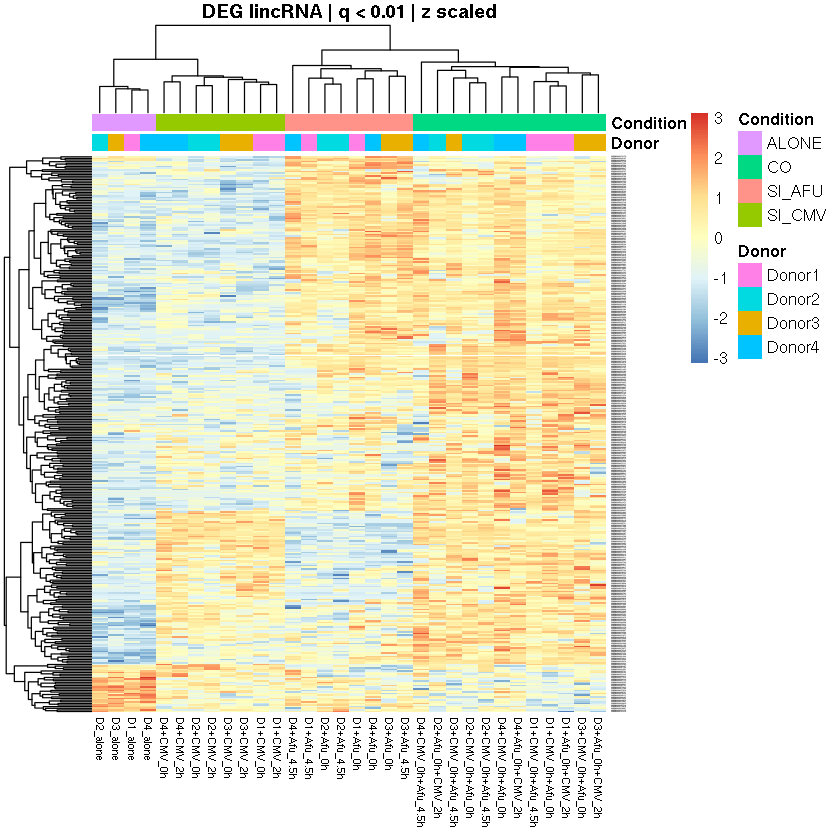

png 
  2

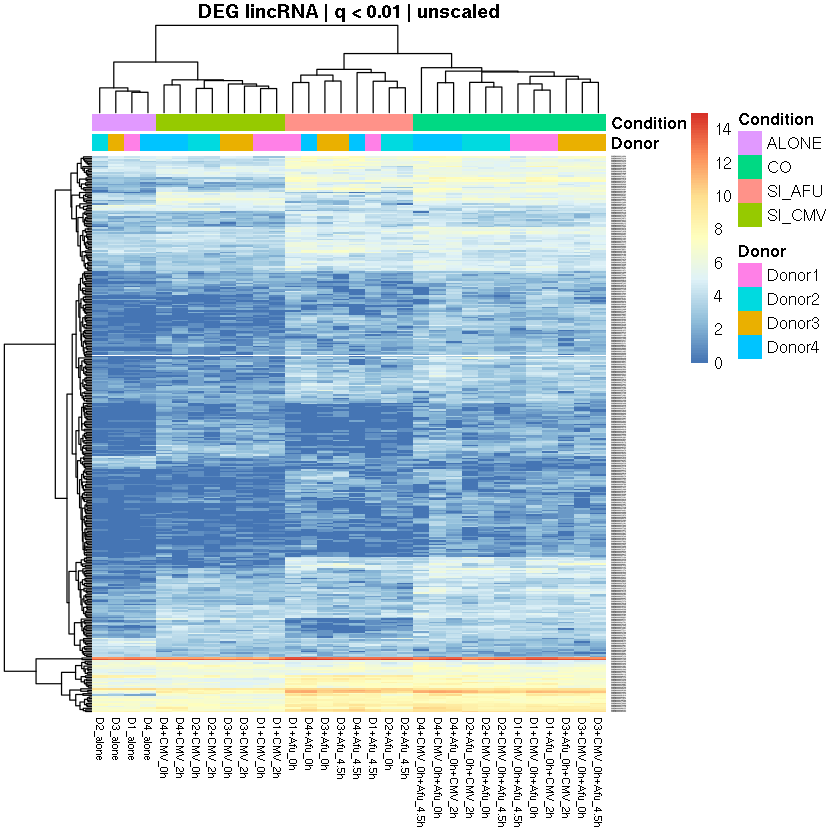

In [42]:
l <- hm_sel_genes(counts_sp1.mrn,
                  meta,
                  deg_linc_names,
                  row.names = T,
                  scale = T,
                  fontsize = 1,
                  main = "DEG lincRNA | q < 0.01 | z scaled")
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_lincRNA_topDEG_p0.01.z.pdf")

l <- hm_sel_genes(counts_sp1.mrn,
                  meta,
                  deg_linc_names,
                  row.names = T,
                  scale = F,
                  fontsize = 1,
                  main = "DEG lincRNA | q < 0.01 | unscaled")
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_lincRNA_topDEG_p0.01.pdf")

png 
  2

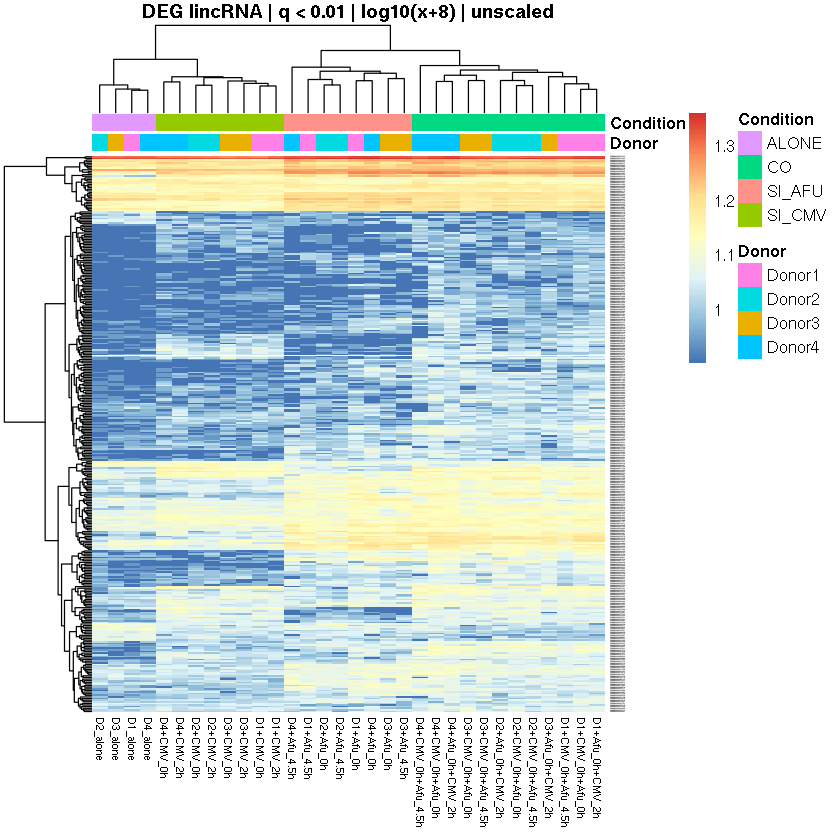

In [52]:
l <- hm_sel_genes(log10(counts_sp1.mrn + 8),
                  meta,
                  deg_linc_names,
                  row.names = T,
                  scale = F,
                  fontsize = 1,
                  main = "DEG lincRNA | q < 0.01 | log10(x+8) | unscaled")
save_pheatmap_pdf(l, "../results/other_plots/Hsapiens_heat_lincRNA_topDEG_p0.01.log10.pdf")

# Combined Correlation Analysis

## Normalize Data together

In [11]:
is_triple <- function(x) str_count(x, "_plus_") == 2
is_dual <- function(x) str_count(x, "_plus_") == 1
is_infect <- function(x) is_triple(x) || is_dual(x)

filter_zero <- function(mat) mat[rowSums(mat) > 0,]

In [12]:
# make sure the samples are in the same order
stopifnot(colnames(counts_sp1) == colnames(counts_sp2))
stopifnot(colnames(counts_sp2) == colnames(counts_sp3))

In [13]:
sp1_pref <- "ENSG"
sp2_pref <- "Afu"
sp3_pref <- "cds"

In [14]:
counts_all <- rbind(counts_sp1,
                    counts_sp2,
                    counts_sp3)

In [15]:
# filter genes with not expression
counts_all_no0 <- filter_zero(counts_all)

In [16]:
# normalize data
counts_all_no0_mrn <- get_mrn(counts_all_no0)

In [39]:
# save for later/other use
write.table(counts_all_no0_mrn, "../results/stats/all_counts.no0.mrn.tsv", sep = "\t", row.names = T, quote = F, col.names = NA)

In [17]:
# regroup genes by species
counts_list <- list(
    all = counts_all_no0_mrn,
    DC  = counts_all_no0_mrn[grepl(sp1_pref, rownames(counts_all_no0_mrn)),],
    Afu = counts_all_no0_mrn[grepl(sp2_pref, rownames(counts_all_no0_mrn)),],
    CMV = counts_all_no0_mrn[grepl(sp3_pref, rownames(counts_all_no0_mrn)),],
    # two species together
    DC_Afu  = counts_all_no0_mrn[grepl(sp1_pref, rownames(counts_all_no0_mrn)) | grepl(sp2_pref, rownames(counts_all_no0_mrn)),],
    DC_CMV  = counts_all_no0_mrn[grepl(sp1_pref, rownames(counts_all_no0_mrn)) | grepl(sp3_pref, rownames(counts_all_no0_mrn)),],
    Afu_CMV  = counts_all_no0_mrn[grepl(sp2_pref, rownames(counts_all_no0_mrn)) | grepl(sp3_pref, rownames(counts_all_no0_mrn)),]
)

In [18]:
sapply(counts_list, dim)

all   DC    Afu  CMV DC_Afu DC_CMV Afu_CMV
[1,] 53615 43853 9596 166 53449  44019  9762   
[2,]    40    40   40  40    40     40    40

In [32]:
# Save table per species for rtqPCR
write.table(counts_list$DC, "../results/stats/all_counts.no0.mrn.DC.tsv", sep = "\t", row.names = T, quote = F, col.names = NA)
write.table(counts_list$Afu, "../results/stats/all_counts.no0.mrn.Afu.tsv", sep = "\t", row.names = T, quote = F, col.names = NA)
write.table(counts_list$CMV, "../results/stats/all_counts.no0.mrn.CMV.tsv", sep = "\t", row.names = T, quote = F, col.names = NA)

In [19]:
meta_sub <- meta %>%
    dplyr::select(Specimen, donor, treat) %>%
    filter(treat %in% c("DC_alone", "DC_plus_Afu_0h", "DC_plus_CMV_0h", "DC_plus_CMV_0h_plus_Afu_0h", "Afu_alone_0h"))
head(meta_sub, 2)

Specimen                 donor  treat         
1 Donor1_01_DC_alone       Donor1 DC_alone      
2 Donor1_02_DC_plus_Afu_0h Donor1 DC_plus_Afu_0h

In [20]:
head(counts_list$Afu)

Donor1_01_DC_alone Donor1_02_DC_plus_Afu_0h
Afu1g00140 0                  0.0000000               
Afu1g00200 0                  0.0000000               
Afu1g00220 0                  0.6217331               
Afu1g00230 0                  0.0000000               
Afu1g00240 0                  0.6217331               
Afu1g00250 0                  0.0000000               
           Donor1_03_DC_plus_Afu_4h30min Donor1_04_DC_plus_CMV_0h
Afu1g00140 0.0000000                     0                       
Afu1g00200 0.0000000                     0                       
Afu1g00220 2.1293668                     0                       
Afu1g00230 0.0000000                     0                       
Afu1g00240 0.5323417                     0                       
Afu1g00250 0.0000000                     0                       
           Donor1_05_DC_plus_CMV_0h_plus_Afu_0h
Afu1g00140 0.000000                            
Afu1g00200 0.000000                            
Afu1g00220 0.000000                            
Afu1g00230 0.000000                            
Afu1g00240 1.513538                            
Afu1g00250 0.000000                            
           Donor1_06_DC_plus_CMV_0h_plus_Afu_4h30min
Afu1g00140 0.0000000                                
Afu1g00200 0.0000000                                
Afu1g00220 1.1982186                                
Afu1g00230 0.0000000                                
Afu1g00240 0.5991093                                
Afu1g00250 0.0000000                                
           Donor1_07_DC_plus_Afu_0h_plus_CMV_2h Donor1_08_DC_plus_CMV_2h
Afu1g00140 0.0000000                            0                       
Afu1g00200 0.4291772                            0                       
Afu1g00220 1.2875315                            0                       
Afu1g00230 0.4291772                            0                       
Afu1g00240 2.1458858                            0                       
Afu1g00250 0.0000000                            0                       
           Donor1_09_Afu_alone_0h Donor1_10_Afu_alone_4h30min ⋯
Afu1g00140 4.480118                0.000000                   ⋯
Afu1g00200 0.000000                9.389644                   ⋯
Afu1g00220 4.480118               42.253400                   ⋯
Afu1g00230 0.000000                0.000000                   ⋯
Afu1g00240 4.480118               79.811977                   ⋯
Afu1g00250 0.000000                0.000000                   ⋯
           Donor4_01_DC_alone Donor4_02_DC_plus_Afu_0h
Afu1g00140 0.000000           0.0000000               
Afu1g00200 0.000000           0.0000000               
Afu1g00220 1.539056           0.6212564               
Afu1g00230 0.000000           0.0000000               
Afu1g00240 1.539056           1.8637692               
Afu1g00250 0.000000           0.0000000               
           Donor4_03_DC_plus_Afu_4h30min Donor4_04_DC_plus_CMV_0h
Afu1g00140 0.0000000                     0                       
Afu1g00200 0.5286775                     0                       
Afu1g00220 0.0000000                     0                       
Afu1g00230 0.0000000                     0                       
Afu1g00240 0.0000000                     0                       
Afu1g00250 0.0000000                     0                       
           Donor4_05_DC_plus_CMV_0h_plus_Afu_0h
Afu1g00140 0.0000000                           
Afu1g00200 0.0000000                           
Afu1g00220 0.0000000                           
Afu1g00230 0.0000000                           
Afu1g00240 0.5171893                           
Afu1g00250 0.0000000                           
           Donor4_06_DC_plus_CMV_0h_plus_Afu_4h30min
Afu1g00140 0.0000000                                
Afu1g00200 0.0000000                                
Afu1g00220 0.5823559                                
Afu1g00230 0.0000000                                
Afu1g00240 1.7470677                              

In [23]:
summarise_donors <- function(mat) mat %>%
    as_data_frame(mat) %>%
    mutate(Gene = rownames(mat)) %>%
    gather("Sample", "Value", -Gene) %>%
    left_join(meta_sub, by = c("Sample" = "Specimen")) %>%
    filter(!is.na(treat)) %>%
    group_by(Gene, treat) %>%
    dplyr::summarise(Treat = treat[1],
              Value = mean(Value)) %>%
    ungroup() %>%
    dplyr::select(-one_of(colnames(meta_sub))) %>%
    spread(key = Treat, value = Value)

to_matrix <- function(df) {
    df <- as.data.frame(df)
    rownames(df) <- df$Gene
    df <- dplyr::select(df, -Gene)
    return(data.matrix(df))
}

In [24]:
counts_list_mean <- lapply(counts_list, summarise_donors)

Warning message:
“The `.name_repair` argument to `as_tibble()` takes precedence over the deprecated `validate` argument.”Warning message:
“Column `Sample`/`Specimen` joining character vector and factor, coercing into character vector”Warning message:
“Unknown columns: `Specimen`, `donor`”Warning message:
“The `.name_repair` argument to `as_tibble()` takes precedence over the deprecated `validate` argument.”Warning message:
“Column `Sample`/`Specimen` joining character vector and factor, coercing into character vector”Warning message:
“Unknown columns: `Specimen`, `donor`”Warning message:
“The `.name_repair` argument to `as_tibble()` takes precedence over the deprecated `validate` argument.”Warning message:
“Column `Sample`/`Specimen` joining character vector and factor, coercing into character vector”Warning message:
“Unknown columns: `Specimen`, `donor`”Warning message:
“The `.name_repair` argument to `as_tibble()` takes precedence over the deprecated `validate` argument.”Warning mess

In [ ]:
counts_list_mean <- lapply(counts_list_mean, to_matrix)

In [ ]:
head(counts_list_mean$Afu)

## Select DEGs

In [25]:
get_sign_genes_geo2 <- function(deg_res, lfc2 = 0, sigP = 0.01) {
    l <- lapply(deg_res, function(x) {
        # select tools
        tools <- grep("_adj_pval", x %>% colnames, value = T, fixed = T)

        inds_p <- x[,tools] %>% {. < sigP} %>% {rowSums(.) == length(tools)}
        inds_lfc <- abs(x$log2_fc_mrn) >= lfc2
        inds <- inds_p & inds_lfc
        deg_genes <- rownames(x)[inds]

        return(deg_genes)
    })

    names(l) <- names(deg_res)
    return(l)
}

get_items_per_intersection <- function(l) attr(venn(l, show.plot = F, ), "intersections")

rem_sign <- function(s) sub("[-|+]$", "", s)

In [26]:
deg_res_sp1 <- readRDS("../results/DEG_overlaps/deg_res_sp1.rds")
deg_res_sp2 <- readRDS("../results/DEG_overlaps/deg_res_sp2.rds")
deg_res_sp3 <- readRDS("../results/DEG_overlaps/deg_res_sp3.rds")
deg_res_sp1 <- deg_res_sp1$DEGs
deg_res_sp2 <- deg_res_sp2$DEGs
deg_res_sp3 <- deg_res_sp3$DEGs

In [27]:
deg_sp1 <- get_sign_genes_geo2(deg_res_sp1, 1, 0.01) %>% unlist(use.names = F) %>% unique()
deg_sp2 <- get_sign_genes_geo2(deg_res_sp2, 0, 0.05) %>% unlist(use.names = F) %>% unique()
deg_sp3 <- lapply(deg_res_sp3, function(d) {as.character(d$id)}) %>% unlist(use.names = F) %>% unique()

In [28]:
length(deg_sp1)
length(deg_sp2)
length(deg_sp3)

[1] 3288

[1] 523

[1] 166

## Correlate - Samples-wise
* to be fully honest, the dual ones are only halve as informative as one may think

In [29]:
library("corrplot")
library("RColorBrewer")

corrplot 0.84 loaded


In [308]:
dir.create("../results/correlation/all_genes/sample-wise", recursive = T)
#dir.create("../results/correlation/all_genes/gene-wise", recursive = T)
dir.create("../results/correlation/deg_genes/sample-wise", recursive = T)
dir.create("../results/correlation/deg_genes/gene-wise", recursive = T)

Warning message in dir.create("../results/correlation/all_genes/sample-wise", recursive = T):
“'../results/correlation/all_genes/sample-wise' already exists”

In [202]:
# all genes
col1 <- colorRampPalette(c("#7F0000", "red", "#FF7F00", "yellow", "white",
                           "cyan", "#007FFF", "blue", "#00007F"))

for(i in 1:length(counts_list_mean)) {
    counts <- counts_list_mean[[i]]
    pdf(paste0("../results/correlation/all_genes/sample-wise/", names(counts_list_mean)[i], ".pear.pdf"))
    corrplot(cor(counts, method = "p"), 
             type = "upper",
             addCoef.col = "white",
             is.corr = T,
             method = "square",
             number.cex = 0.5,
             tl.cex = 1,
             pch.cex = .5,
             bg = "white",
             col = col1(100))
    dev.off()
}

In [342]:
# only DEG | selected genes
col1 <- colorRampPalette(c("#7F0000", "red", "#FF7F00", "yellow", "white",
                           "cyan", "#007FFF", "blue", "#00007F"))
degs <- c(deg_sp1, deg_sp2, deg_sp3)

for(i in 1:length(counts_list_mean)) {
    counts <- counts_list_mean[[i]]
    keep <- rownames(counts) %in% degs
    counts <- counts[keep,]
    
    # keep only samples of interest
    group <- names(counts_list_mean)[[i]]
    if (group != "all") {
        group_members <- unlist(strsplit(group, split = "_"))
        if (length(group_members) == 1)
            keep <- grepl(group_members, colnames(counts))
        else
            keep <- grepl(group_members[1], colnames(counts)) & grepl(group_members[2], colnames(counts))
        
        counts <- counts[,keep]
    }
    
    if (is.matrix(counts)) {
        pdf(paste0("../results/correlation/deg_genes/sample-wise/", names(counts_list_mean)[i], ".pear.pdf"))
        corrplot(cor(counts, method = "p"), 
                 type = "upper",
                 addCoef.col = "white",
                 is.corr = T,
                 method = "square",
                 number.cex = 0.5,
                 tl.cex = 1,
                 pch.cex = .5,
                 bg = "white",
                 col = col1(100))
        dev.off()
    } else {
        # CMV vs AFU does not have two possible groups
        warning(paste("Could not correlate this group combination: ", group))
    }
}

Warning message in eval(expr, envir, enclos):
“Could not correlate this group combination:  Afu_CMV”

## Correlate - Gene-Wise

In [30]:
library("corrplot")
library("RColorBrewer")

In [31]:
# faster than 'base::cor', at least when BLAS is present
corr_fast <- function(mat) {
    # Center each variable
    mat = mat - rowMeans(mat);
    # Standardize each variable
    mat = mat / sqrt(rowSums(mat^2));
    # Calculate correlations
    cr = tcrossprod(mat);
    return(cr)
}

In [32]:
split_donors <- function(mat) { 
    l <- mat %>%
        as_data_frame(mat) %>%
        mutate(Gene = rownames(mat)) %>%
        gather("Sample", "Value", -Gene) %>%
        left_join(meta_sub, by = c("Sample" = "Specimen")) %>%
        filter(!is.na(treat)) %>%
        plyr::dlply(.variables = "treat")

    l <- lapply(l, function(x) dplyr::select(x, -one_of(colnames(meta_sub))) %>%
                              spread(key = Sample, value = Value))
    return(lapply(l, to_matrix))
}


to_matrix <- function(df) {
    df <- as.data.frame(df)
    rownames(df) <- df$Gene
    df <- dplyr::select(df, -Gene)
    return(data.matrix(df))
}

In [33]:
# this data is already filtered and normalized
dim(counts_list$all)

[1] 53615    40

In [34]:
# keep only particular conditions & split group-wise
counts_split <- split_donors(counts_list$all)

Warning message:
“The `.name_repair` argument to `as_tibble()` takes precedence over the deprecated `validate` argument.”Warning message:
“Column `Sample`/`Specimen` joining character vector and factor, coercing into character vector”Warning message:
“Unknown columns: `Specimen`”Warning message:
“Unknown columns: `Specimen`”Warning message:
“Unknown columns: `Specimen`”Warning message:
“Unknown columns: `Specimen`”Warning message:
“Unknown columns: `Specimen`”

In [35]:
# remove genes that are not measured in a particular condition (to speed things up)
counts_split$DC_alone <- counts_split$DC_alone[grepl(sp1_pref, rownames(counts_split$DC_alone)), ]
counts_split$Afu_alone_0h <- counts_split$Afu_alone_0h[grepl(sp2_pref, rownames(counts_split$Afu_alone_0h)), ]
counts_split$DC_plus_Afu_0h <- counts_split$DC_plus_Afu_0h[grepl(sp1_pref, rownames(counts_split$DC_plus_Afu_0h)) | grepl(sp2_pref, rownames(counts_split$DC_plus_Afu_0h)), ]
counts_split$DC_plus_CMV_0h <- counts_split$DC_plus_CMV_0h[grepl(sp1_pref, rownames(counts_split$DC_plus_CMV_0h)) | grepl(sp3_pref, rownames(counts_split$DC_plus_CMV_0h)), ]

In [36]:
sapply(counts_split, dim)

Afu_alone_0h DC_alone DC_plus_Afu_0h DC_plus_CMV_0h
[1,] 9596         43853    53449          44019         
[2,]    4             4        4              4         
     DC_plus_CMV_0h_plus_Afu_0h
[1,] 53615                     
[2,]     4

In [39]:
# short speed test
degs <- c(deg_sp1, deg_sp2, deg_sp3)
counts <- counts_split[[1]]
keep <- rownames(counts) %in% degs
counts <- counts[keep,]

# Start timer
tic = proc.time();

r <- corr_fast(counts)
suppressWarnings({p <- cor.mtest(t(counts))}) # takes forever

# Stop timer
toc = proc.time();
# Show the results and the time
show(cr[1:4,1:4]);
show(toc-tic)

ERROR: Error in show(cr[1:4, 1:4]): object 'cr' not found


In [40]:
dim(p$p)

[1] 523 523

In [382]:
# roughly estimated time for 4000 genes in minutes
((3920^2)/(523^2))*21 / 60

[1] 19.66241

In [ ]:
# gene-gene correlation is only feasible with a subset of genes
# therefore, this is only executed based on DEGs

In [41]:
# Start timer
# Runs ~ 15 minutes for ~4000 genes
tic = proc.time();

degs <- c(deg_sp1, deg_sp2, deg_sp3)
gene_corr_res <- mclapply(1:length(counts_split), mc.cores = length(counts_split), FUN =  function(i) {
    counts <- counts_split[[i]]
    keep <- rownames(counts) %in% degs
    counts <- counts[keep,]

    r <- corr_fast(counts) # instant
    suppressWarnings({p <- cor.mtest(t(counts))}) # takes forever
    
    return(list(r = r, p = p))
})
names(gene_corr_res) <- names(counts_split)

# Stop timer
toc = proc.time();
# Show the results and the time
#show(cr[1:4,1:4]);
show(toc-tic)

In [42]:
gene_corr_res_afu <- lapply(list(3), function(i) {
    counts <- counts_split[[i]]
    keep <- rownames(counts) %in% degs
    counts <- counts[keep,]

    r <- corr_fast(counts) # instant
    suppressWarnings({p <- cor.mtest(t(counts))}) # takes forever
    
    return(list(r = r, p = p))
})
names(gene_corr_res_afu) <- names(counts_split)[3]

In [ ]:
names(counts_split)

In [ ]:
print(length(grep("^[(EN)|(Afu)]", degs)))
print(sum(rownames(counts_split[[3]]) %in% degs))

In [458]:
# save for later use & prevent overwriting
#write_rds(gene_corr_res, "../results/correlation/deg_genes/deg_genes_corr.rds")

In [81]:
grep("^EN", degs) %>% length
grep("^Afu", degs) %>% length
grep("^cds", degs) %>% length

[1] 3288

[1] 523

[1] 166

In [406]:
merge(ldply(gene_corr_res, function(l) data.frame("NA" = sum(is.na(l$p$p)))),
      ldply(gene_corr_res, function(l) data.frame("Valid" = sum(!is.na(l$p$p)))))

.id                        NA.     Valid   
1 Afu_alone_0h                  4164   269365
2 DC_alone                   1107546  9703398
3 DC_plus_Afu_0h              506118 14017603
4 DC_plus_CMV_0h              199462 11730654
5 DC_plus_CMV_0h_plus_Afu_0h   39740 15776789

In [444]:
for (i in 1:length(gene_corr_res)) {
    label <- names(gene_corr_res)[[i]]
    tmp <- gene_corr_res[[i]]$r
    tmp[is.na(tmp)] <- 0
    pdf(paste0("../results/correlation/deg_genes/gene-wise/", label, ".sig001.pdf"), height = 12, width = 12)
    corrplot(tmp,
             p.mat = gene_corr_res[[i]]$p$p,
             sig.level = .01,
             insig = "blank",
             method = "color",
             is.corr = T,
             pch = 0,
             tl.cex = 0.001,
             type = "upper",
             order = "hclust")
    dev.off()
}

In [445]:
# same version but without p value filtering
for (i in 1:length(gene_corr_res)) {
    label <- names(gene_corr_res)[[i]]
    tmp <- gene_corr_res[[i]]$r
    tmp[is.na(tmp)] <- 0
    pdf(paste0("../results/correlation/deg_genes/gene-wise/", label, ".pdf"), height = 12, width = 12)
    corrplot(tmp,
             method = "color",
             is.corr = T,
             pch = 0,
             tl.cex = 0.001,
             type = "upper",
             order = "hclust")
    dev.off()
}

In [ ]:
saveRDS(gene_corr_res, "../results/correlation/deg_genes/deg_genes_corr.rds")

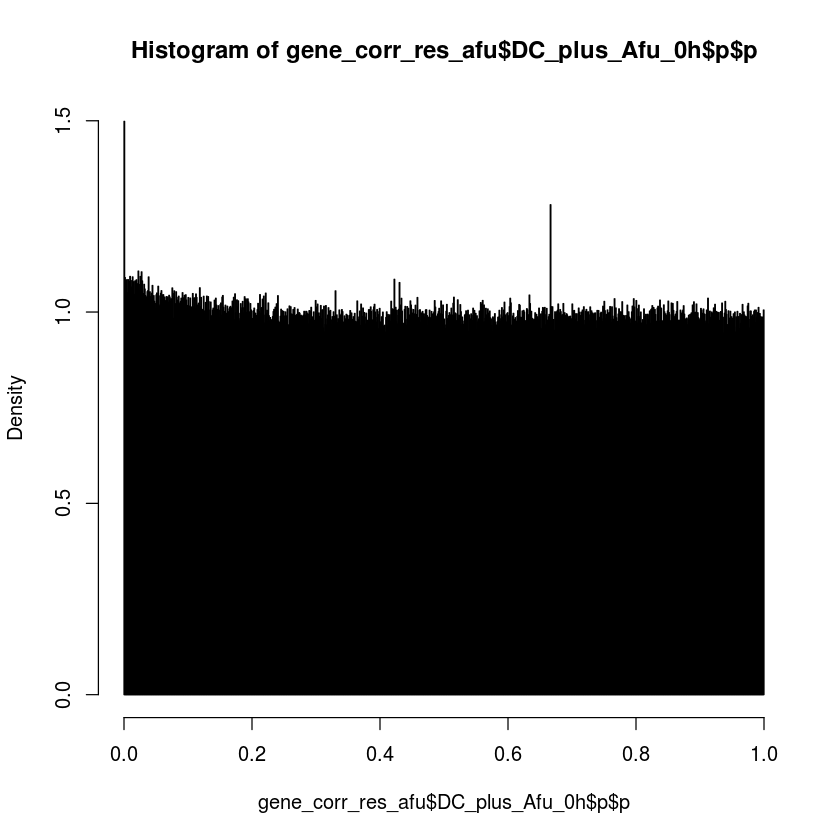

In [44]:
# If the re-run has the same distribution as the saved object, then I accept the result
hist(gene_corr_res_afu$DC_plus_Afu_0h$p$p, breaks = 1000, probability = T)

In [459]:
gene_corr_res_sig005 <- llply(gene_corr_res, function(lmat) {
    # set unsignificant rho to 0
    lmat$r[is.na(lmat$p$p) | lmat$p$p >= 0.05] <- 0.0
    lmat
})

gene_corr_res_sig001 <- llply(gene_corr_res, function(lmat) {
    # set unsignificant rho to 0
    lmat$r[is.na(lmat$p$p) | lmat$p$p >= 0.01] <- 0.0
    lmat
})

gene_corr_res_sig0001 <- llply(gene_corr_res, function(lmat) {
    # set unsignificant rho to 0
    lmat$r[is.na(lmat$p$p) | lmat$p$p >= 0.001] <- 0.0
    lmat
})

gene_corr_res_sig000 <- llply(gene_corr_res, function(lmat) {
    # set unsignificant rho to 0
    lmat$r[is.na(lmat$p$p) | lmat$p$p > 0.0] <- 0.0
    lmat
})

In [460]:
lmat <- gene_corr_res_sig000$Afu_alone_0h
sum(is.na(lmat$p$p) | lmat$p$p >= 0.01)
sum(!is.na(lmat$p$p) & lmat$p$p < 0.01)

[1] 248764

[1] 24765

In [461]:
# We learn:
#  Once the p-value filter is applied, a rho filter is not necessary anymore

# get some stats
reduce(.f = merge, .x = list(
          ldply(gene_corr_res, function(l) data.frame("r0.00" = sum(abs(l$r) > 0.00, na.rm = T))),
          ldply(gene_corr_res, function(l) data.frame("r0.25" = sum(abs(l$r) > 0.25, na.rm = T))),
          ldply(gene_corr_res, function(l) data.frame("r0.50" = sum(abs(l$r) > 0.50, na.rm = T))),
          ldply(gene_corr_res, function(l) data.frame("r0.75" = sum(abs(l$r) > 0.75, na.rm = T))),
          ldply(gene_corr_res, function(l) data.frame("r0.90" = sum(abs(l$r) > 0.90, na.rm = T))),
          ldply(gene_corr_res, function(l) data.frame("r0.95" = sum(abs(l$r) > 0.95, na.rm = T)))
      )
)

# get some stats
reduce(.f = merge, .x = list(
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.00" = sum(abs(l$r) > 0.00, na.rm = T))),
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.25" = sum(abs(l$r) > 0.25, na.rm = T))),
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.50" = sum(abs(l$r) > 0.50, na.rm = T))),
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.75" = sum(abs(l$r) > 0.75, na.rm = T))),
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.90" = sum(abs(l$r) > 0.90, na.rm = T))),
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.95" = sum(abs(l$r) > 0.95, na.rm = T)))
      )
)

# get some stats
reduce(.f = merge, .x = list(
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.00" = sum(abs(l$r) > 0.00, na.rm = T))),
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.25" = sum(abs(l$r) > 0.25, na.rm = T))),
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.50" = sum(abs(l$r) > 0.50, na.rm = T))),
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.75" = sum(abs(l$r) > 0.75, na.rm = T))),
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.90" = sum(abs(l$r) > 0.90, na.rm = T))),
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.95" = sum(abs(l$r) > 0.95, na.rm = T)))
      )
)
                
reduce(.f = merge, .x = list(
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.00" = sum(abs(l$r) > 0.00, na.rm = T))),
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.25" = sum(abs(l$r) > 0.25, na.rm = T))),
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.50" = sum(abs(l$r) > 0.50, na.rm = T))),
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.75" = sum(abs(l$r) > 0.75, na.rm = T))),
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.90" = sum(abs(l$r) > 0.90, na.rm = T))),
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.95" = sum(abs(l$r) > 0.95, na.rm = T)))
      )
)
                
# get some stats
reduce(.f = merge, .x = list(
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.00" = sum(abs(l$r) > 0.00, na.rm = T))),
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.25" = sum(abs(l$r) > 0.25, na.rm = T))),
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.50" = sum(abs(l$r) > 0.50, na.rm = T))),
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.75" = sum(abs(l$r) > 0.75, na.rm = T))),
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.90" = sum(abs(l$r) > 0.90, na.rm = T))),
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.95" = sum(abs(l$r) > 0.95, na.rm = T)))
      )
)

.id                        r0.00    r0.25    r0.50    r0.75   r0.90   r0.95  
1 Afu_alone_0h                 269361   263457   250081  212503  142691   92265
2 DC_alone                    9703225  8590087  7117989 4928119 2813105 1696517
3 DC_plus_Afu_0h             14017536 10544586  7068618 3593144 1474262  749726
4 DC_plus_CMV_0h             11730625 10804775  9580181 7445901 4648031 2910475
5 DC_plus_CMV_0h_plus_Afu_0h 15776784 13831026 11909164 9468708 6512178 4553818

.id                        r0.00   r0.25   r0.50   r0.75   r0.90   r0.95  
1 Afu_alone_0h                 92265   92265   92265   92265   92265   92265
2 DC_alone                   1696517 1696517 1696517 1696517 1696517 1696517
3 DC_plus_Afu_0h              749726  749726  749726  749726  749726  749726
4 DC_plus_CMV_0h             2910475 2910475 2910475 2910475 2910475 2910475
5 DC_plus_CMV_0h_plus_Afu_0h 4553818 4553818 4553818 4553818 4553818 4553818

.id                        r0.00   r0.25   r0.50   r0.75   r0.90   r0.95  
1 Afu_alone_0h                 24761   24761   24761   24761   24761   24761
2 DC_alone                    426157  426157  426157  426157  426157  426157
3 DC_plus_Afu_0h              156956  156956  156956  156956  156956  156956
4 DC_plus_CMV_0h              748251  748251  748251  748251  748251  748251
5 DC_plus_CMV_0h_plus_Afu_0h 1439146 1439146 1439146 1439146 1439146 1439146

.id                        r0.00  r0.25  r0.50  r0.75  r0.90  r0.95 
1 Afu_alone_0h                 3223   3223   3223   3223   3223   3223
2 DC_alone                    53519  53519  53519  53519  53519  53519
3 DC_plus_Afu_0h              20938  20938  20938  20938  20938  20938
4 DC_plus_CMV_0h              83939  83939  83939  83939  83939  83939
5 DC_plus_CMV_0h_plus_Afu_0h 174832 174832 174832 174832 174832 174832

.id                        r0.00 r0.25 r0.50 r0.75 r0.90 r0.95
1 Afu_alone_0h                521   521   521   521   521   521 
2 DC_alone                   8245  8245  8245  8245  8245  8245 
3 DC_plus_Afu_0h             5528  5528  5528  5528  5528  5528 
4 DC_plus_CMV_0h             4307  4307  4307  4307  4307  4307 
5 DC_plus_CMV_0h_plus_Afu_0h 4116  4116  4116  4116  4116  4116

[1] 92265     3

[1] 92265     3

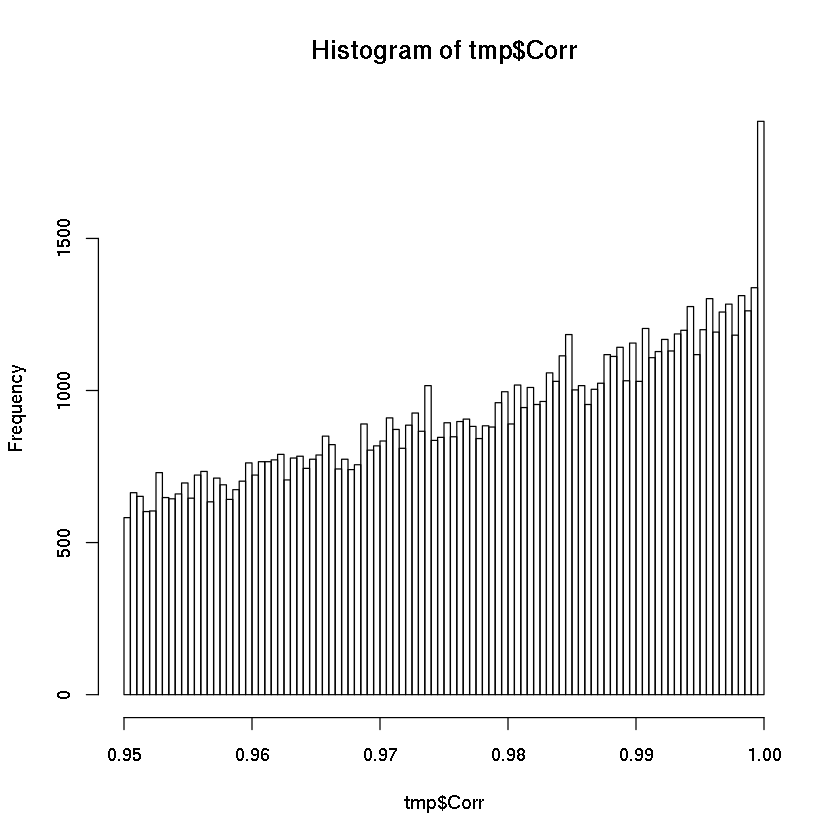

[1] 4553818       3

[1] 4553818       3

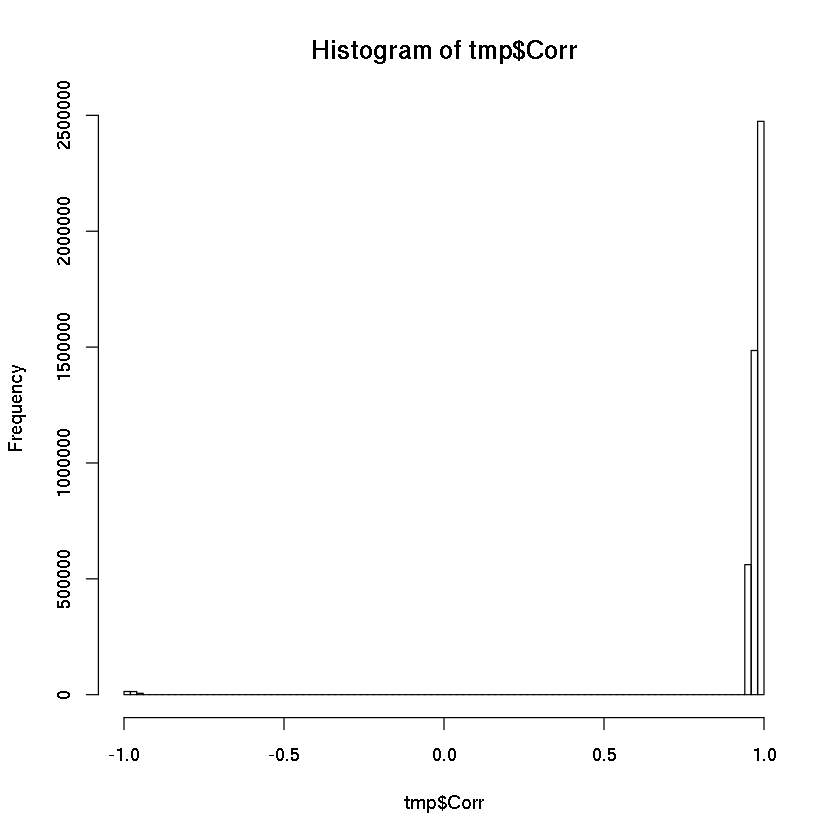

In [500]:
# now: how many significant edges can be found between
# dplyr the hell out of that
# Testing:
tmp <- gene_corr_res_sig005$Afu_alone_0h$r %>%
    data.frame(check.names = F) %>%
    mutate(Gene1 = rownames(.)) %>%
    gather("Gene2", "Corr", -Gene1) %>%
    filter(abs(Corr) > 0)

hist(tmp$Corr, breaks = 100)
dim(tmp)
dim(tmp %>% filter(abs(Corr) > 0.25))


# now: how many significant edges can be found between
# dplyr the hell out of that
# Testing:
tmp <- gene_corr_res_sig005$DC_plus_CMV_0h_plus_Afu_0h$r %>%
    data.frame(check.names = F) %>%
    mutate(Gene1 = rownames(.)) %>%
    gather("Gene2", "Corr", -Gene1) %>%
    filter(abs(Corr) > 0)

hist(tmp$Corr, breaks = 100)
dim(tmp)
dim(tmp %>% filter(abs(Corr) > 0.25))

In [531]:
lower.tri.remove <- function(mat, diag = T) {
    mat[lower.tri(mat, diag=diag)] <- NA
    mat
}

In [533]:
# select only DEG genes
deg_gene_corr_sig005_long <- ldply(gene_corr_res_sig005, .id = "Condition", function(d) {
    d$r %>%
    lower.tri.remove(diag = T) %>% # deduplicate
    data.frame(check.names = F) %>%
    mutate(Gene1 = rownames(.)) %>%
    gather("Gene2", "Corr", -Gene1) %>%
    filter(!is.na(Corr) & abs(Corr) > 0)
})

In [536]:
head(deg_gene_corr_sig005_long)
dim(deg_gene_corr_sig005_long)

Condition    Gene1      Gene2      Corr     
1 Afu_alone_0h Afu1g01540 Afu1g02120 0.9853470
2 Afu_alone_0h Afu1g01540 Afu1g02820 0.9625567
3 Afu_alone_0h Afu1g02120 Afu1g02820 0.9822653
4 Afu_alone_0h Afu1g01540 Afu1g03200 0.9922953
5 Afu_alone_0h Afu1g02120 Afu1g03200 0.9809479
6 Afu_alone_0h Afu1g02820 Afu1g03200 0.9814952

[1] 4994013       4

In [538]:
write.table(deg_gene_corr_sig005_long, "../results/correlation/deg_genes/deg_gene_corr_sig005.tsv", sep = "\t", col.names = T, row.names = F)

In [ ]:
# Full Run
deg_gene_corr_sig001_long <- ldply(gene_corr_res_sig001, .id = "Condition", function(d) {
    d$r %>%
    lower.tri.remove(diag = T) %>% # deduplicate
    data.frame(check.names = F) %>%
    mutate(Gene1 = rownames(.)) %>%
    gather("Gene2", "Corr", -Gene1) %>%
    filter(!is.na(Corr) & abs(Corr) > 0)
})

In [ ]:
head(deg_gene_corr_sig001_long)
dim(deg_gene_corr_sig001_long)

In [ ]:
write.table(deg_gene_corr_sig001_long, "../results/correlation/deg_genes/deg_gene_corr_sig001.tsv", sep = "\t", col.names = T, row.names = F)

In [ ]:
# check zero inflation

In [1095]:
all_genes <- c(deg_gene_corr_sig001_long$Gene1, deg_gene_corr_sig001_long$Gene2) %>% unique
length(all_genes)

[1] 3977

In [1102]:
for (i in 1:length(counts_list)) {
    print("")
    print(names(counts_list)[[i]])
    counts <- counts_list[[i]]
    
    counts_deg <- counts[rownames(counts) %in% all_genes,]
    print(nrow(counts_deg))
    print(sum(rowSums(counts_deg > 0) > 1))
    print(sum(rowSums(counts_deg > 0) > 2))
    print(sum(rowSums(counts_deg > 0) > 3))
}


[1] ""
[1] "all"
[1] 3977
[1] 3977
[1] 3976
[1] 3976
[1] ""
[1] "DC"
[1] 3288
[1] 3288
[1] 3288
[1] 3288
[1] ""
[1] "Afu"
[1] 523
[1] 523
[1] 523
[1] 523
[1] ""
[1] "CMV"
[1] 166
[1] 166
[1] 165
[1] 165
[1] ""
[1] "DC_Afu"
[1] 3811
[1] 3811
[1] 3811
[1] 3811
[1] ""
[1] "DC_CMV"
[1] 3454
[1] 3454
[1] 3453
[1] 3453
[1] ""
[1] "Afu_CMV"
[1] 689
[1] 689
[1] 688
[1] 688


In [1100]:
head(counts_deg)

Donor1_01_DC_alone Donor1_02_DC_plus_Afu_0h
ENSG00000228794   8.343054          15.543327              
ENSG00000272512   1.390509           4.973865              
ENSG00000188290   0.463503           8.704263              
ENSG00000187608  45.886798          87.042631              
ENSG00000224969   0.000000           0.000000              
ENSG00000188157 101.970663         178.437394              
                Donor1_03_DC_plus_Afu_4h30min Donor1_04_DC_plus_CMV_0h
ENSG00000228794   9.582150                       27.284966            
ENSG00000272512   3.194050                        5.052771            
ENSG00000188290   1.597025                       23.242748            
ENSG00000187608  56.428219                    14877.380078            
ENSG00000224969   0.000000                        9.094989            
ENSG00000188157 142.135231                      466.876076            
                Donor1_05_DC_plus_CMV_0h_plus_Afu_0h
ENSG00000228794   12.10830                          
ENSG00000272512   13.11733                          
ENSG00000188290   26.23465                          
ENSG00000187608 5191.93829                          
ENSG00000224969    4.03610                          
ENSG00000188157  274.45481                          
                Donor1_06_DC_plus_CMV_0h_plus_Afu_4h30min
ENSG00000228794   12.581295                              
ENSG00000272512   13.779514                              
ENSG00000188290   35.946558                              
ENSG00000187608 8437.256249                              
ENSG00000224969    6.590202                              
ENSG00000188157  387.623716                              
                Donor1_07_DC_plus_Afu_0h_plus_CMV_2h Donor1_08_DC_plus_CMV_2h
ENSG00000228794   10.729429                             6.485213             
ENSG00000272512    9.012720                             2.161738             
ENSG00000188290   21.029681                             9.727820             
ENSG00000187608 2520.557489                          3596.050639             
ENSG00000224969    2.145886                             4.323475             
ENSG00000188157  244.630984                           222.658982             
                Donor1_09_Afu_alone_0h Donor1_10_Afu_alone_4h30min ⋯
ENSG00000228794 0                      0                           ⋯
ENSG00000272512 0                      0                           ⋯
ENSG00000188290 0                      0                           ⋯
ENSG00000187608 0                      0                           ⋯
ENSG00000224969 0                      0                           ⋯
ENSG00000188157 0                      0                           ⋯
                Donor4_01_DC_alone Donor4_02_DC_plus_Afu_0h
ENSG00000228794  18.468668          18.016436              
ENSG00000272512   1.539056           3.727538              
ENSG00000188290   9.234334          14.910154              
ENSG00000187608 102.347202          55.291820              
ENSG00000224969   0.000000           0.000000              
ENSG00000188157 317.045468         218.682253              
                Donor4_03_DC_plus_Afu_4h30min Donor4_04_DC_plus_CMV_0h
ENSG00000228794  5.286775                        14.857962            
ENSG00000272512  2.114710                        10.612830            
ENSG00000188290  6.344131                        47.403975            
ENSG00000187608 39.122138                     14354.914218            
ENSG00000224969  0.000000                         6.367698            
ENSG00000188157 89.346505                       505.170721            
                Donor4_05_DC_plus_CMV_0h_plus_Afu_0h
ENSG00000228794   12.929732                         
ENSG00000272512   26.376654                         
ENSG00000188290   61.028337                         
ENSG00000187608 7224.100078                         
ENSG00000224969    6.723461                         
ENSG00000188157  289.108816                         
     

### Basic SetDiff Networks

In [19]:
# get some help from Igraph
library("igraph")


Attaching package: ‘igraph’

The following object is masked from ‘package:IRanges’:

    union

The following object is masked from ‘package:S4Vectors’:

    union

The following objects are masked from ‘package:BiocGenerics’:

    normalize, path, union

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [2247]:
unique(deg_gene_corr_sig001_long$Condition)

[1] Afu_alone_0h               DC_alone                  
[3] DC_plus_Afu_0h             DC_plus_CMV_0h            
[5] DC_plus_CMV_0h_plus_Afu_0h
5 Levels: Afu_alone_0h DC_alone DC_plus_Afu_0h ... DC_plus_CMV_0h_plus_Afu_0h

#### AFu

In [2248]:
DC_plus_Afu_0h <- deg_gene_corr_sig001_long %>% filter(Condition == "DC_plus_Afu_0h")
DC_plus_CMV_0h_plus_Afu_0h <- deg_gene_corr_sig001_long %>% filter(Condition == "DC_plus_CMV_0h_plus_Afu_0h")

In [923]:
saveRDS(DC_plus_Afu_0h, "../results/correlation/deg_genes/DC_plus_Afu_0h.rds")
saveRDS(DC_plus_CMV_0h_plus_Afu_0h, "../results/correlation/deg_genes/DC_plus_CMV_0h_plus_Afu_0h.rds")

In [2249]:
head(DC_plus_Afu_0h, 1)

Condition      Gene1      Gene2      Corr     
1 DC_plus_Afu_0h Afu1g03720 Afu1g04040 0.9946358

In [2250]:
T %in% grepl(sp3_pref, DC_plus_CMV_0h_plus_Afu_0h$Gene1)
T %in% grepl(sp3_pref, DC_plus_CMV_0h_plus_Afu_0h$Gene2)

[1] TRUE

[1] TRUE

In [2252]:
DC_plus_Afu_0h_g <- graph_from_data_frame(DC_plus_Afu_0h %>% dplyr::rename(from = Gene1, to = Gene2) %>% dplyr::select(-Condition), 
                                          directed = F)
DC_plus_CMV_0h_plus_Afu_0h_g <- graph_from_data_frame(DC_plus_CMV_0h_plus_Afu_0h %>% dplyr::rename(from = Gene1, to = Gene2) %>% dplyr::select(-Condition), 
                                          directed = F)

In [2253]:
DC_plus_Afu_0h_g
DC_plus_CMV_0h_plus_Afu_0h_g

IGRAPH adb436d UN-- 3744 76606 -- 
+ attr: name (v/c), Corr (e/n)
+ edges from adb436d (vertex names):
 [1] Afu1g03720--Afu1g04040 Afu1g04040--Afu1g04530 Afu1g05080--Afu1g05400
 [4] Afu1g03040--Afu1g06390 Afu1g04160--Afu1g06670 Afu1g05400--Afu1g06710
 [7] Afu1g05080--Afu1g08840 Afu1g03040--Afu1g09100 Afu1g05080--Afu1g09100
[10] Afu1g08840--Afu1g09100 Afu1g07380--Afu1g09330 Afu1g03040--Afu1g10380
[13] Afu1g06390--Afu1g10380 Afu1g04160--Afu1g10780 Afu1g05790--Afu1g10780
[16] Afu1g06710--Afu1g11800 Afu1g05080--Afu1g13450 Afu1g08840--Afu1g13450
[19] Afu1g03720--Afu1g13980 Afu1g04040--Afu1g13980 Afu1g04040--Afu1g14220
[22] Afu1g04530--Afu1g14220 Afu1g05160--Afu1g14220 Afu1g13980--Afu1g14220
+ ... omitted several edges

IGRAPH 5ec5040 UN-- 3971 717587 -- 
+ attr: name (v/c), Corr (e/n)
+ edges from 5ec5040 (vertex names):
 [1] Afu1g03040--Afu1g04530 Afu1g04530--Afu1g05080 Afu1g05080--Afu1g05160
 [4] Afu1g03040--Afu1g05400 Afu1g05390--Afu1g05400 Afu1g03040--Afu1g05990
 [7] Afu1g04530--Afu1g05990 Afu1g05400--Afu1g05990 Afu1g05080--Afu1g06390
[10] Afu1g03040--Afu1g06710 Afu1g04530--Afu1g06710 Afu1g05080--Afu1g06710
[13] Afu1g05990--Afu1g06710 Afu1g04040--Afu1g06830 Afu1g06390--Afu1g06830
[16] Afu1g04530--Afu1g07380 Afu1g05080--Afu1g07380 Afu1g05160--Afu1g07380
[19] Afu1g05990--Afu1g07380 Afu1g06710--Afu1g07380 Afu1g03380--Afu1g08840
[22] Afu1g05990--Afu1g08840 Afu1g06710--Afu1g08840 Afu1g07380--Afu1g08840
+ ... omitted several edges

In [2254]:
tic = proc.time();
DC_afu_vs_DC_afu_cmv <- graph.intersection(
    DC_plus_Afu_0h_g,
    DC_plus_CMV_0h_plus_Afu_0h_g,
    keep.all.vertices = FALSE
)
toc = proc.time();
show(toc-tic)

   user  system elapsed 
  0.830   0.253   3.739 


In [2255]:
# All changes that only exist in AFU single infection
tic = proc.time();
DC_afu_minus_DC_afu_cmv <- graph.difference(
    DC_plus_Afu_0h_g,
    DC_plus_CMV_0h_plus_Afu_0h_g
)
toc = proc.time();
show(toc-tic)

   user  system elapsed 
  0.189   0.192   1.926 


In [2257]:
# All changes that only exist in CMV single infection
tic = proc.time();
DC_cmv_minus_DC_afu_cmv <- graph.difference(
    DC_plus_CMV_0h_g,
    DC_plus_CMV_0h_plus_Afu_0h_g
)
toc = proc.time();
show(toc-tic)

   user  system elapsed 
  0.305   0.112   1.299 


In [2256]:
# Co wo SI AFU
tic = proc.time();
DC_afu_cmv_minus_DC_afu <- graph.difference(
    DC_plus_CMV_0h_plus_Afu_0h_g,
    DC_plus_Afu_0h_g
)
toc = proc.time();
show(toc-tic)

   user  system elapsed 
  0.402   0.076   1.163 


In [2261]:
# Intersect: CoI with SI AFU
DC_afu_cmv_and_DC_afu <- graph.intersection(
    DC_plus_CMV_0h_plus_Afu_0h_g,
    DC_plus_Afu_0h_g
)

In [710]:
saveRDS(DC_afu_minus_DC_afu_cmv, "../results/correlation/deg_genes/gene-wise/DC_afu_minus_DC_afu_cmv.igraph.rds")
saveRDS(DC_afu_cmv_minus_DC_afu, "../results/correlation/deg_genes/gene-wise/DC_afu_cmv_minus_DC_afu.igraph.rds")
saveRDS(DC_afu_cmv_and_DC_afu, "../results/correlation/deg_genes/gene-wise/DC_afu_cmv_and_DC_afu.igraph.rds")

In [681]:
# edges without CMV
is_connected(DC_afu_minus_DC_afu_cmv) # Fully connected
is_connected(DC_afu_cmv_minus_DC_afu) # Not fully connected

[1] TRUE

[1] FALSE

In [716]:
# try to visualize the smaller one

net <- DC_afu_minus_DC_afu_cmv
# add species information
n <- V(net)$name
V(net)$org <- ifelse(grepl(sp1_pref, n), "DC", ifelse(grepl(sp2_pref, n), "AFu", "CMV"))
# compute degree
deg <- degree(net, mode="all")
V(net)$size <- pmin(deg * 0.05, 3)
# add colors
colrs <- c("#00FF0088", "#FFFF0088", "#FF000088")
V(net)$color <- colrs[factor(V(net)$org, levels = c("DC", "AFu", "CMV"))]
E(net)$color <- ifelse(E(net)$Corr <0, "#0000FF77", "#FF000077")

png("../results/correlation/deg_genes/gene-wise/si_afu_wo_CoI.network.png", height = 2048, width = 2048)
l <- layout_with_fr(net)
plot(net,
     vertex.label = V(net)$name,
     vertex.label.cex = 0.01,
     #vertex.size = 2,
     vertex.frame.color = NULL,
     edge.width = 0.2,
     #edge.color = "#00000077",
     layout = l)
dev.off()

png 
  2

In [790]:
# try to visualize the bigger one
net_tmp <- DC_afu_cmv_minus_DC_afu
net_subs <- decompose(net_tmp, min.vertices = 10)
length(net_subs)

# add species information
i <- 1
for (net in net_subs) {
    n <- V(net)$name
    V(net)$org <- ifelse(grepl(sp1_pref, n), "DC", ifelse(grepl(sp2_pref, n), "AFu", "CMV"))
    # compute degree
    deg <- degree(net, mode="all")
    V(net)$size <- pmin(deg * 0.05, 3)
    # add colors
    colrs <- c("#00FF0088", "#FFFF0088", "#FF000088")
    V(net)$color <- colrs[factor(V(net)$org, levels = c("DC", "AFu", "CMV"))]
    E(net)$color <- ifelse(E(net)$Corr <0, "#0000FF77", "#FF000077")

    png(paste0("../results/correlation/deg_genes/gene-wise/co_afu_uniqu.network_", i, ".png"), height = 2048, width = 2048)
    l <- layout_with_fr(net)
    plot(net,
         vertex.label = V(net)$name,
         vertex.label.cex = 0.01,
         #vertex.size = 2,
         vertex.frame.color = NULL,
         edge.width = 0.2,
         edge.color = "#00000077",
         layout = l)
    dev.off()
    i <- i + 1
}

[1] 2

In [791]:
# without CMV

# try to visualize the bigger one
net_tmp <- DC_afu_cmv_minus_DC_afu
# remove CMV edges
edge_df <- ends(net_tmp, es=E(net_tmp), names=T)
net_tmp <- net_tmp - E(net_tmp)[grepl(sp3_pref, edge_df[,1]) | grepl(sp3_pref, edge_df[,2])]


net_subs <- decompose(net_tmp, min.vertices = 10)
length(net_subs)

# add species information
i <- 1
for (net in net_subs) {
    n <- V(net)$name
    V(net)$org <- ifelse(grepl(sp1_pref, n), "DC", ifelse(grepl(sp2_pref, n), "AFu", "CMV"))
    # compute degree
    deg <- degree(net, mode="all")
    V(net)$size <- pmin(deg * 0.05, 3)
    # add colors
    colrs <- c("#00FF0088", "#FFFF0088", "#FF000088")
    V(net)$color <- colrs[factor(V(net)$org, levels = c("DC", "AFu", "CMV"))]
    E(net)$color <- ifelse(E(net)$Corr <0, "#0000FF77", "#FF000077")

    png(paste0("../results/correlation/deg_genes/gene-wise/co_afu_uniqu.no_CMV.network_", i, ".png"), height = 2048, width = 2048)
    l <- layout_with_fr(net)
    plot(net,
         vertex.label = V(net)$name,
         vertex.label.cex = 0.01,
         #vertex.size = 2,
         vertex.frame.color = NULL,
         edge.width = 0.2,
         edge.color = "#00000077",
         layout = l)
    dev.off()
    i <- i + 1
}

[1] 2

In [ ]:
# with clusters

net <- net_subs[[1]] # the biggest is always first - the other ones are super small anyways
n <- V(net)$name
V(net)$org <- ifelse(grepl(sp1_pref, n), "DC", ifelse(grepl(sp2_pref, n), "AFu", "CMV"))
# compute degree
deg <- degree(net, mode="all")
V(net)$size <- pmin(deg * 0.05, 3)
# add colors
colrs <- c("#00FF0088", "#FFFF0088", "#FF000088")
V(net)$color <- colrs[factor(V(net)$org, levels = c("DC", "AFu", "CMV"))]
E(net)$color <- ifelse(E(net)$Corr <0, "#0000FF77", "#FF000077")

# cluster everything
#clp <- cluster_edge_betweenness(net)
# keep only clusters with at least 20 nodes
com <- communities(clp)
com_20 <- grp[sapply(com, length) >= 20]

V(net)$color[!(V(net)$name %in% unlist(com_20))] <- "#000000FF" # blacken unclustered nodes

png(paste0("../results/correlation/deg_genes/gene-wise/co_afu_uniqu.no_CMV.clusters.network_", i, ".png"), height = 2048, width = 2048)
plot(clp,
     sub_net,
     col = NULL,
     mark.groups = com_20,
     vertex.label = V(net)$name,
     vertex.label.cex = 0.01,
     #vertex.size = 2,
     vertex.frame.color = NULL,
     edge.width = 0.2,
     edge.color = "#00000077")
dev.off()

#### CMV

In [1057]:
DC_plus_CMV_0h <- deg_gene_corr_sig001_long %>% filter(Condition == "DC_plus_CMV_0h")
DC_plus_CMV_0h_plus_Afu_0h <- deg_gene_corr_sig001_long %>% filter(Condition == "DC_plus_CMV_0h_plus_Afu_0h")

In [1067]:
saveRDS(DC_plus_CMV_0h, "../results/correlation/deg_genes/DC_plus_CMV_0h.rds")

In [1068]:
head(DC_plus_CMV_0h, 1)

Condition      Gene1          Gene2          Corr     
1 DC_plus_CMV_0h cds-ABV71499.1 cds-ABV71500.1 0.9913828

In [770]:
DC_plus_CMV_0h_g <- graph_from_data_frame(DC_plus_CMV_0h %>% dplyr::rename(from = Gene1, to = Gene2) %>% dplyr::select(-Condition), 
                                          directed = F)
DC_plus_CMV_0h_plus_Afu_0h_g <- graph_from_data_frame(DC_plus_CMV_0h_plus_Afu_0h %>% dplyr::rename(from = Gene1, to = Gene2) %>% dplyr::select(-Condition), 
                                          directed = F)

In [771]:
DC_plus_CMV_0h_g
DC_plus_CMV_0h_plus_Afu_0h_g

IGRAPH 37424ea UN-- 3422 372413 -- 
+ attr: name (v/c), Corr (e/n)
+ edges from 37424ea (vertex names):
 [1] cds-ABV71499.1--cds-ABV71500.1 cds-ABV71501.1--cds-ABV71502.1
 [3] cds-ABV71501.1--cds-ABV71503.1 cds-ABV71501.1--cds-ABV71505.1
 [5] cds-ABV71502.1--cds-ABV71505.1 cds-ABV71502.1--cds-ABV71507.1
 [7] cds-ABV71505.1--cds-ABV71507.1 cds-ABV71502.1--cds-ABV71508.1
 [9] cds-ABV71505.1--cds-ABV71508.1 cds-ABV71507.1--cds-ABV71508.1
[11] cds-ABV71501.1--cds-ABV71509.1 cds-ABV71502.1--cds-ABV71509.1
[13] cds-ABV71505.1--cds-ABV71509.1 cds-ABV71501.1--cds-ABV71510.1
[15] cds-ABV71502.1--cds-ABV71510.1 cds-ABV71505.1--cds-ABV71510.1
+ ... omitted several edges

IGRAPH c0bd86d UN-- 3971 717587 -- 
+ attr: name (v/c), Corr (e/n)
+ edges from c0bd86d (vertex names):
 [1] Afu1g03040--Afu1g04530 Afu1g04530--Afu1g05080 Afu1g05080--Afu1g05160
 [4] Afu1g03040--Afu1g05400 Afu1g05390--Afu1g05400 Afu1g03040--Afu1g05990
 [7] Afu1g04530--Afu1g05990 Afu1g05400--Afu1g05990 Afu1g05080--Afu1g06390
[10] Afu1g03040--Afu1g06710 Afu1g04530--Afu1g06710 Afu1g05080--Afu1g06710
[13] Afu1g05990--Afu1g06710 Afu1g04040--Afu1g06830 Afu1g06390--Afu1g06830
[16] Afu1g04530--Afu1g07380 Afu1g05080--Afu1g07380 Afu1g05160--Afu1g07380
[19] Afu1g05990--Afu1g07380 Afu1g06710--Afu1g07380 Afu1g03380--Afu1g08840
[22] Afu1g05990--Afu1g08840 Afu1g06710--Afu1g08840 Afu1g07380--Afu1g08840
+ ... omitted several edges

In [772]:
tic = proc.time();
DC_cmv_vs_DC_afu_cmv <- graph.intersection(
    DC_plus_CMV_0h_g,
    DC_plus_CMV_0h_plus_Afu_0h_g,
    keep.all.vertices = FALSE
)
toc = proc.time();
show(toc-tic)

   user  system elapsed 
  0.902   0.000   0.901 


In [773]:
# All changes that only exist in the single infection
tic = proc.time();
DC_cmv_minus_DC_afu_cmv <- graph.difference(
    DC_plus_CMV_0h_g,
    DC_plus_CMV_0h_plus_Afu_0h_g
)
toc = proc.time();
show(toc-tic)

   user  system elapsed 
  0.185   0.000   0.185 


In [2258]:
# Co wo SI CMV
tic = proc.time();
DC_afu_cmv_minus_DC_cmv <- graph.difference(
    DC_plus_CMV_0h_plus_Afu_0h_g,
    DC_plus_CMV_0h_g
)
toc = proc.time();
show(toc-tic)

   user  system elapsed 
  0.425   0.149   1.751 


In [2262]:
# Intersect: CoI with SI CMV
DC_afu_cmv_and_DC_cmv <- graph.intersection(
    DC_plus_CMV_0h_plus_Afu_0h_g,
    DC_plus_CMV_0h_g
)

In [775]:
saveRDS(DC_cmv_minus_DC_afu_cmv, "../results/correlation/deg_genes/gene-wise/DC_cmv_minus_DC_afu_cmv.igraph.rds")
saveRDS(DC_afu_cmv_minus_DC_cmv, "../results/correlation/deg_genes/gene-wise/DC_afu_cmv_minus_DC_cmv.igraph.rds")
saveRDS(DC_afu_cmv_and_DC_cmv, "../results/correlation/deg_genes/gene-wise/DC_afu_cmv_and_DC_cmv.igraph.rds")

In [776]:
# edges without CMV
is_connected(DC_cmv_minus_DC_afu_cmv) # Fully connected
is_connected(DC_afu_cmv_minus_DC_cmv) # Not fully connected

[1] FALSE

[1] FALSE

In [780]:
DC_cmv_minus_DC_afu_cmv

IGRAPH 6b32ac7 UN-- 3422 311359 -- 
+ attr: name (v/c), Corr (e/n)
+ edges from 6b32ac7 (vertex names):
 [1] cds-ABV71499.1--ENSG00000229436 cds-ABV71499.1--ENSG00000155792
 [3] cds-ABV71499.1--ENSG00000283208 cds-ABV71499.1--ENSG00000279369
 [5] cds-ABV71499.1--ENSG00000272468 cds-ABV71499.1--ENSG00000271032
 [7] cds-ABV71499.1--ENSG00000261504 cds-ABV71499.1--ENSG00000233816
 [9] cds-ABV71499.1--ENSG00000283118 cds-ABV71499.1--ENSG00000280248
[11] cds-ABV71499.1--ENSG00000277895 cds-ABV71499.1--ENSG00000258609
[13] cds-ABV71499.1--ENSG00000276651 cds-ABV71499.1--ENSG00000266173
[15] cds-ABV71499.1--ENSG00000199347 cds-ABV71499.1--ENSG00000167874
+ ... omitted several edges

In [801]:
# try to visualize the smaller one

net_tmp <- DC_cmv_minus_DC_afu_cmv
net_subs <- decompose(net_tmp, min.vertices = 10, max.comps = 10)
length(net_subs)

# add species information
i <- 1
for (net in net_subs) {
    n <- V(net)$name
    V(net)$org <- ifelse(grepl(sp1_pref, n), "DC", ifelse(grepl(sp2_pref, n), "AFu", "CMV"))
    # compute degree
    deg <- degree(net, mode="all")
    V(net)$size <- pmin(deg * 0.05, 3)
    # add colors
    colrs <- c("#00FF0011", "#FFFF0088", "#0000FF88")
    V(net)$color <- colrs[factor(V(net)$org, levels = c("DC", "AFu", "CMV"))]
    E(net)$color <- ifelse(E(net)$Corr <0, "#0000FF77", "#FF000077")

    png(paste0("../results/correlation/deg_genes/gene-wise/si_cmv_uniqu.network_", i, ".png"), height = 2048, width = 2048)
    l <- layout_with_fr(net)
    plot(net,
         vertex.label = V(net)$name,
         vertex.label.cex = 0.01,
         #vertex.size = 2,
         vertex.frame.color = NULL,
         edge.width = 0.2,
         layout = l)
    dev.off()
    i <- i + 1
}

[1] 2

In [812]:
# only DC-CMV edges

net_tmp <- DC_cmv_minus_DC_afu_cmv
edge_df <- ends(net_tmp, es=E(net_tmp), names=T)
net_tmp <- net_tmp - E(net_tmp)[!xor(grepl(sp3_pref, edge_df[,1]), grepl(sp3_pref, edge_df[,2]))]

net_subs <- decompose(net_tmp, min.vertices = 10, max.comps = 10)
length(net_subs)

# add species information
i <- 1
for (net in net_subs) {
    n <- V(net)$name
    V(net)$org <- ifelse(grepl(sp1_pref, n), "DC", ifelse(grepl(sp2_pref, n), "AFu", "CMV"))
    # compute degree
    deg <- degree(net, mode="all")
    V(net)$size <- pmin(deg * 0.05, 3)
    # add colors
    colrs <- c("#00FF0011", "#FFFF0011", "#0000FF30")
    V(net)$color <- colrs[factor(V(net)$org, levels = c("DC", "AFu", "CMV"))]
    E(net)$color <- ifelse(E(net)$Corr <0, "#0000FF77", "#FF000077")

    png(paste0("../results/correlation/deg_genes/gene-wise/si_cmv_uniqu.only_dc_cmv.network_", i, ".png"), height = 2048, width = 2048)
    l <- layout_with_fr(net)
    plot(net,
         vertex.label = V(net)$name,
         vertex.label.cex = 0.01,
         #vertex.size = 2,
         vertex.frame.color = NULL,
         edge.width = 0.2,
         layout = l)
    dev.off()
    i <- i + 1
}

[1] 2

In [815]:
# try to visualize the bigger one
net_tmp <- DC_afu_cmv_minus_DC_cmv
net_subs <- decompose(net_tmp, min.vertices = 10)
length(net_subs)

# add species information
i <- 1
for (net in net_subs) {
    n <- V(net)$name
    V(net)$org <- ifelse(grepl(sp1_pref, n), "DC", ifelse(grepl(sp2_pref, n), "AFu", "CMV"))
    # compute degree
    deg <- degree(net, mode="all")
    V(net)$size <- pmin(deg * 0.05, 3)
    # add colors
    colrs <- c("#00FF0011", "#FFFF0011", "#0000FF30")
    V(net)$color <- colrs[factor(V(net)$org, levels = c("DC", "AFu", "CMV"))]
    E(net)$color <- ifelse(E(net)$Corr <0, "#0000FF77", "#FF000077")

    png(paste0("../results/correlation/deg_genes/gene-wise/co_cmv_uniqu.network_", i, ".png"), height = 2048, width = 2048)
    l <- layout_with_fr(net)
    plot(net,
         vertex.label = V(net)$name,
         vertex.label.cex = 0.01,
         #vertex.size = 2,
         vertex.frame.color = NULL,
         edge.width = 0.2,
         edge.color = "#00000077",
         layout = l)
    dev.off()
    i <- i + 1
}

[1] 2

In [814]:
# without AFu

# try to visualize the bigger one
net_tmp <- DC_afu_cmv_minus_DC_afu
# remove CMV edges
edge_df <- ends(net_tmp, es=E(net_tmp), names=T)
net_tmp <- net_tmp - E(net_tmp)[grepl(sp2_pref, edge_df[,1]) | grepl(sp2_pref, edge_df[,2])]


net_subs <- decompose(net_tmp, min.vertices = 10)
length(net_subs)

# add species information
i <- 1
for (net in net_subs) {
    n <- V(net)$name
    V(net)$org <- ifelse(grepl(sp1_pref, n), "DC", ifelse(grepl(sp2_pref, n), "AFu", "CMV"))
    # compute degree
    deg <- degree(net, mode="all")
    V(net)$size <- pmin(deg * 0.05, 3)
    # add colors
    colrs <- c("#00FF0011", "#FFFF0011", "#0000FF30")
    V(net)$color <- colrs[factor(V(net)$org, levels = c("DC", "AFu", "CMV"))]

    png(paste0("../results/correlation/deg_genes/gene-wise/co_cmv_uniqu.no_AFu.network_", i, ".png"), height = 2048, width = 2048)
    l <- layout_with_fr(net)
    plot(net,
         vertex.label = V(net)$name,
         vertex.label.cex = 0.01,
         #vertex.size = 2,
         vertex.frame.color = NULL,
         edge.width = 0.2,
         edge.color = "#00000077",
         layout = l)
    dev.off()
    i <- i + 1
}

[1] 3

In [817]:
# without AFu - only DC-CMV

# try to visualize the bigger one
net_tmp <- DC_afu_cmv_minus_DC_afu
# remove CMV edges
edge_df <- ends(net_tmp, es=E(net_tmp), names=T)
net_tmp <- net_tmp - E(net_tmp)[grepl(sp2_pref, edge_df[,1]) | grepl(sp2_pref, edge_df[,2])]
edge_df <- ends(net_tmp, es=E(net_tmp), names=T)
net_tmp <- net_tmp - E(net_tmp)[!xor(grepl(sp3_pref, edge_df[,1]), grepl(sp3_pref, edge_df[,2]))]


net_subs <- decompose(net_tmp, min.vertices = 10)
length(net_subs)

# add species information
i <- 1
for (net in net_subs) {
    n <- V(net)$name
    V(net)$org <- ifelse(grepl(sp1_pref, n), "DC", ifelse(grepl(sp2_pref, n), "AFu", "CMV"))
    # compute degree
    deg <- degree(net, mode="all")
    V(net)$size <- pmin(deg * 0.05, 3)
    # add colors
    colrs <- c("#00FF0011", "#FFFF0011", "#0000FF30")
    V(net)$color <- colrs[factor(V(net)$org, levels = c("DC", "AFu", "CMV"))]

    png(paste0("../results/correlation/deg_genes/gene-wise/co_cmv_uniqu.no_AFu.only_dc_cmv.network_", i, ".png"), height = 2048, width = 2048)
    l <- layout_with_fr(net)
    plot(net,
         vertex.label = V(net)$name,
         vertex.label.cex = 0.01,
         #vertex.size = 2,
         vertex.frame.color = NULL,
         edge.width = 0.2,
         edge.color = "#00000077",
         layout = l)
    dev.off()
    i <- i + 1
}

[1] 4

In [56]:
make_and_plot_cluster_network <- function(net, main_dir, file_name, no_cluster = F, min_cluster_size = 10) {

    # create output directories
    dir.create(file.path(main_dir, "cluster"), recursive = T, showWarnings = F)
    
    # remove disconnected edges
    net <- net - V(net)[degree(net) == 0]

    # add species information
    n <- V(net)$name
    V(net)$org <- ifelse(grepl(sp1_pref, n), "DC", ifelse(grepl(sp2_pref, n), "AFu", "CMV"))
    # compute degree
    deg <- degree(net, mode="all")
    V(net)$size <- pmin(2 + deg * 0.05, 7)
    # add colors
    colrs <- c("#00FF0088", "#FFFF0088", "#FF000088")
    V(net)$color <- colrs[factor(V(net)$org, levels = c("DC", "AFu", "CMV"))]
    
    # Edge colors
    # If intersection network, we have 'Corr_1 and Corr_2 instead of Corr'
    if ("Corr" %in% edge_attr_names(net)) {
        E(net)$color <- ifelse(E(net)$Corr <0, "#0000FF77", "#FF000077")
    } else if ("Corr_1" %in% edge_attr_names(net)) {
        E(net)$color <- ifelse(E(net)$Corr_1 * E(net)$Corr_2 > 0, # have same correlation direction?
                               ifelse(E(net)$Corr_1 < 0,
                                      "#0000FF77", # blue
                                      "#FF000077"), # red
                               "#000000FF" # black
                              )
    } else {
        stop("Cannot find correlations")
    }

    #png(paste0(main_dir, "/", file_name, ".network.png"), height = 2048, width = 2048)
    pdf(paste0(main_dir, "/", file_name, ".network.pdf"), height = 16, width = 16)
    l <- layout_with_fr(net)
    plot(net,
         vertex.label = V(net)$name,
         vertex.label.cex = 0.01,
         vertex.frame.color = NULL,
         edge.width = 1.5,
         layout = l)
    dev.off()

    if (!no_cluster) {

        # cluster data
        comp <- decompose(net)
        names(comp) <- paste0("Cluster_", 1:length(comp))
        cluster_df <- ldply(comp, .id = "cluster", function(co) {
            df <- as_data_frame(co, what = "edges")
            # at least 10 edges
            if (nrow(df) < min_cluster_size) {
                return(data.frame())
            } else {
                df$num_nodes <- nrow(df)
                df
            }
        })

        if (nrow(cluster_df) >= 1) {
            cluster_df <- mutate(cluster_df,
                                 from_symbol = to_symbol(from, F),
                                 to_symbol_ = to_symbol(to, F))
            cluster_df <- cluster_df %>% dplyr::select(cluster, from, from_symbol, to, to_symbol_, everything())
            writexl::write_xlsx(cluster_df, paste0(main_dir, "/cluster/", file_name, ".clusters.xlsx"))


            hub_df <- calc_hubs_from_cluster(cluster_df, net)
            writexl::write_xlsx(hub_df, paste0(main_dir, "/cluster/", file_name, ".hubs.xlsx"))


            # for plotting, clusters must be gene lists
            at_least_10 <- cluster_df %>% group_by(cluster) %>% summarise(n = n()) %>% filter(n >= 10)
            grps <- dlply(cluster_df %>% filter(cluster %in% at_least_10$cluster),
                          "cluster",
                          function(df) unique(c(df$from, df$to)))


            # color clusters in plot
            png(paste0(main_dir, "/", file_name, ".clusters.network.png"), height = 2048, width = 2048)
            l <- layout_with_fr(net)
            plot(net,
                 mark.groups = grps,
                 vertex.label = V(net)$name,
                 vertex.label.cex = 0.01,
                 vertex.frame.color = NULL,
                 edge.width = 1.5,
                 layout = l)
            dev.off()
        }

        invisible(list(cl = cluster_df, net = net))
    }
}

### INNATE DB SWITCH

In [25]:
with_innate <- T
if (with_innate) {
    main_output_dir <- "../results/correlation/innateDB_deg/gene-wise/"
    rds_dir <- "../results/correlation/innateDB_deg/"
} else {
    main_output_dir <- "../results/correlation/deg_genes/gene-wise/"
    rds_dir <- "../results/correlation/deg_genes/"
}

betw_species_out_dir <- file.path(main_output_dir, "BetweenSpecies")

In [26]:
# Load InnateDB gene list
innate_df <- readxl::read_xls("../other_data/innatedb_curated_genes_2019-04-11.xls")
innate_genes <- unique(innate_df$`Gene Symbol`)
head(innate_genes)
length(innate_genes)

readxl works best with a newer version of the tibble package.
You currently have tibble v1.4.2.
Falling back to column name repair from tibble <= v1.4.2.
Message displays once per session.


[1] "Id2"    "Iltifb" "PRKRA"  "DDX3X"  "DDX58"  "MIR136"

[1] 1697

In [27]:
# Load existing network files
DC_afu_minus_DC_afu_cmv <- readRDS(paste0("../results/correlation/deg_genes/gene-wise/", "/", "DC_afu_minus_DC_afu_cmv.igraph.rds"))
DC_afu_cmv_minus_DC_afu <- readRDS(paste0("../results/correlation/deg_genes/gene-wise/", "/", "DC_afu_cmv_minus_DC_afu.igraph.rds"))

In [23]:
filter_net_innatedb <- function(net) {
    # Annotate human ENS genes
    if (is_igraph(net)) {
        edges <- as_data_frame(net, what = "edges")
    } else {
        # edge data frame
        edges <- net %>% dplyr::select(Gene1, Gene2, Corr, Condition)
        edges <- edges %>% dplyr::rename(from = Gene1, to = Gene2)
    }
    edges <- mutate(edges, from_is_DC = grepl(sp1_pref, from), to_is_DC = grepl(sp1_pref, to))
    edges <- mutate(edges, from_sym =  <-(from, drop_unmapped = F), to_sym = to_symbol(to, drop_unmapped = F))

    # filter:
    # if both DC, keep it only if one of them is part of innatedb
    # if both pathogen, keep it
    # if DC with pathogen, keep it only if the DC genes if part of innatedb
    edges <- filter(edges, (from_is_DC == F & to_is_DC == F) | (from_sym %in% innate_genes) | (to_sym %in% innate_genes))

    # replace NA values
    edges$from_sym[is.na(edges$from_sym)] <- ""
    edges$to_sym[is.na(edges$to_sym)] <- ""

    innate_net <- graph_from_data_frame(edges, directed = F)
    return(innate_net)
}

ERROR: Error in parse(text = x, srcfile = src): <text>:11:40: unexpected assignment
10:     edges <- mutate(edges, from_is_DC = grepl(sp1_pref, from), to_is_DC = grepl(sp1_pref, to))
11:     edges <- mutate(edges, from_sym =  <-
                                           ^


In [ ]:
res <- filter_net_innatedb(DC_afu_minus_DC_afu_cmv)
saveRDS(res, "../results/correlation/innateDB_deg/gene-wise/DC_afu_minus_DC_afu_cmv.igraph.rds")

In [1652]:
res <- filter_net_innatedb(DC_afu_cmv_minus_DC_afu)
saveRDS(res, "../results/correlation/innateDB_deg/gene-wise/DC_afu_cmv_minus_DC_afu.igraph.rds")

In [ ]:
DC_plus_CMV_0h <- readRDS(paste0(rds_dir, "/", "DC_plus_CMV_0h.rds"))
DC_plus_CMV_0h_plus_Afu_0h <- readRDS(paste0(rds_dir, "/", "DC_plus_CMV_0h_plus_Afu_0h.rds"))

[1] TRUE

In [ ]:
# filter edge files

In [1670]:
files <- c("DC_plus_Afu_0h.rds", "DC_plus_CMV_0h.rds", "DC_plus_CMV_0h_plus_Afu_0h.rds")
for (f in files) {
    edges <- readRDS(paste0("../results/correlation/deg_genes/", f))
    net <- filter_net_innatedb(edges)
    edges <- as_data_frame(net, what = "edges")
    saveRDS(edges, paste0("../results/correlation/innateDB_deg/", f))
}

In [1677]:
# sanity checks
fp <- file.path("../results/correlation/innateDB_deg/", files)
print(file.exists(fp))
for (f in fp) {
    rd <- readRDS(f)
    stopifnot(rd$from_is_DC == grepl(sp1_pref, rd$from))
    stopifnot(rd$to_is_DC == grepl(sp1_pref, rd$to))
}

[1] TRUE TRUE TRUE


In [1679]:
main_output_dir
rds_dir

[1] "../results/correlation/innateDB_deg/gene-wise/"

[1] "../results/correlation/innateDB_deg/"

### Gene enrichment of network genes

In [19]:
library("enrichR")

In [20]:
source("lib_annotate.R")

In [21]:
to_symbol <- function (l, drop_unmapped = T) 
{
    df <- data.frame(id = l)

    # get symbol data
    ids <- df$id
    res <- tryCatch({
        query <- getBM(attributes = c("ensembl_gene_id", "hgnc_symbol"),
                     filters = "ensembl_gene_id", 
                     values = unique(ids),
                     mart = ensembl)
        # make dictionary
        query <- filter(query, !duplicated(ensembl_gene_id))
        dic <- query$hgnc_symbol
        names(dic) <- query$ensembl_gene_id

        # apply
        res <- dic[df$id]
        return(res)
    }, error = function(e) {
        warning("Unable to call BiomaRt. Maybe your query did not contain any human gene?")
        
        if (drop_unmapped)
            return(vector(mode = "character"))
        else
            return(rep("", n = length(ids)))
    })
    
    # sanity check
    # Each ENS should have exactly 1 symbol
    df <- mutate(df, sym = res)
    df <- df %>% group_by(id) %>% summarise(n = length(unique(sym)))
    stopifnot(!(T %in% (df$n != 1)))
    
    if (drop_unmapped)
        res <- res[!(is.na(res) | res == "")]
    
    return(res)
}

extract_sig <- function(x, q_cutoff = 0.05) ldply(x, .id = "database", function(d) d %>% filter(Adjusted.P.value < q_cutoff))

In [1266]:
# Now: select edges which
# (1) in si & co, select all DC genes
# (2) in co, select only AFu bound genes

In [1642]:
# Load networks
DC_afu_minus_DC_afu_cmv <- readRDS(paste0(main_output_dir, "/", "DC_afu_minus_DC_afu_cmv.igraph.rds"))
DC_afu_cmv_minus_DC_afu <- readRDS(paste0(main_output_dir, "/", "DC_afu_cmv_minus_DC_afu.igraph.rds"))

In [1643]:
si_afu_wo_co <- as_data_frame(DC_afu_minus_DC_afu_cmv, what="edges")
co_afu_wo_si <- as_data_frame(DC_afu_cmv_minus_DC_afu, what="edges")

In [1644]:
si_afu_wo_co_edges_dc <- c(grep(sp1_pref, si_afu_wo_co$from, value = T), grep(sp1_pref, si_afu_wo_co$to, value = T)) %>% unique()
co_afu_wo_si_edges_dc <- c(grep(sp1_pref, co_afu_wo_si$from, value = T), grep(sp1_pref, co_afu_wo_si$to, value = T)) %>% unique()

In [1645]:
si_afu_wo_co_edges_dc_sym <- to_symbol(si_afu_wo_co_edges_dc)
co_afu_wo_si_edges_dc_sym <- to_symbol(co_afu_wo_si_edges_dc)

Warning message in value[[3L]](cond):
“Unable to call BiomaRt. Maybe your query did not contain any human gene?”

ERROR: Error in mutate_impl(.data, dots): Column `sym` is of unsupported class data.frame


In [1253]:
# show only some of them
grep("(KEGG)|(GO)|(Wiki)|(Reactome)|(Drug)", enrichR::listEnrichrDbs()$libraryName, value = T)

[1] "Drug_Perturbations_from_GEO_2014"                 
 [2] "Reactome_2013"                                    
 [3] "WikiPathways_2013"                                
 [4] "KEGG_2013"                                        
 [5] "GO_Molecular_Function_2015"                       
 [6] "GO_Cellular_Component_2015"                       
 [7] "GO_Biological_Process_2015"                       
 [8] "GO_Biological_Process_2013"                       
 [9] "GO_Cellular_Component_2013"                       
[10] "GO_Molecular_Function_2013"                       
[11] "KEGG_2015"                                        
[12] "WikiPathways_2015"                                
[13] "Reactome_2015"                                    
[14] "Drug_Perturbations_from_GEO_down"                 
[15] "Drug_Perturbations_from_GEO_up"                   
[16] "Reactome_2016"                                    
[17] "KEGG_2016"                                        
[18] "WikiPathways_2016"                                
[19] "DrugMatrix"                                       
[20] "RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO"
[21] "GO_Cellular_Component_2017"                       
[22] "GO_Molecular_Function_2017"                       
[23] "GO_Biological_Process_2017"                       
[24] "GO_Cellular_Component_2017b"                      
[25] "GO_Molecular_Function_2017b"                      
[26] "GO_Biological_Process_2017b"                      
[27] "GO_Biological_Process_2018"                       
[28] "GO_Cellular_Component_2018"                       
[29] "GO_Molecular_Function_2018"                       
[30] "WikiPathways_2019_Human"                          
[31] "WikiPathways_2019_Mouse"

In [ ]:
dir.create(paste0(main_output_dir, "/", "enrichment"))

In [ ]:
# we only filter edges - nodes could still be shared
length(si_afu_wo_co_edges_dc_sym)
length(co_afu_wo_si_edges_dc_sym)
length(intersect(si_afu_wo_co_edges_dc_sym, co_afu_wo_si_edges_dc_sym))
length(setdiff(si_afu_wo_co_edges_dc_sym, co_afu_wo_si_edges_dc_sym))
length(setdiff(co_afu_wo_si_edges_dc_sym, si_afu_wo_co_edges_dc_sym))

Note: this was not useful! Check Intersection stats above!

Setdiff of edges

In [ ]:
# all SI_AFU genes (after removing edges also included in CO)
dbs <- c("GO_Molecular_Function_2018", "GO_Biological_Process_2018", "WikiPathways_2019_Human", "KEGG_2016", "DrugMatrix", "Reactome_2016")
si_afu_wo_co_edges_dc_enrich <- enrichR::enrichr(si_afu_wo_co_edges_dc_sym, databases = dbs)
si_afu_wo_co_edges_dc_enrich_sig <- extract_sig(si_afu_wo_co_edges_dc_enrich)
writexl::write_xlsx(si_afu_wo_co_edges_dc_enrich_sig, paste0(main_output_dir, "/", "enrichment/si_afu_wo_co_edges_dc_enrich_sig.q005.xlsx"))

In [ ]:
# All CO genes (after removing edges also included in SI_AFU)
co_afu_wo_si_edges_dc_enrich <- enrichR::enrichr(co_afu_wo_si_edges_dc_sym, databases = dbs)
co_afu_wo_si_edges_dc_enrich_sig <- extract_sig(co_afu_wo_si_edges_dc_enrich)
writexl::write_xlsx(co_afu_wo_si_edges_dc_enrich_sig, paste0(main_output_dir, "/", "enrichment/co_afu_wo_si_edges_dc_enrich_sig.q005.xlsx"))

In [ ]:
# setdiff of remaining nodes
si_afu_wo_Co <- setdiff(si_afu_wo_co_edges_dc_sym, co_afu_wo_si_edges_dc_sym)
co_afu_wo_si <- setdiff(co_afu_wo_si_edges_dc_sym, si_afu_wo_co_edges_dc_sym)
length(si_afu_wo_Co)
length(co_afu_wo_si)

In [ ]:
# Checking AFU is pointless
# CO could be interesting, though!
si_afu_without_Co_enrich <- enrichR::enrichr(si_afu_wo_Co, databases = dbs)
si_afu_without_Co_enrich_sig <- extract_sig(si_afu_without_Co_enrich)
co_afu_without_si_enrich <- enrichR::enrichr(co_afu_wo_si, databases = dbs)
co_afu_without_si_enrich_sig <- extract_sig(co_afu_without_si_enrich)
writexl::write_xlsx(si_afu_without_Co_enrich_sig, paste0(main_output_dir, "/", "enrichment/si_afu_wo_Co_edges_genes_enrich_sig.q005.xlsx"))
writexl::write_xlsx(co_afu_without_si_enrich_sig, paste0(main_output_dir, "/", "co_afu_wo_si_edges_genes_enrich_sig.q005.xlsx"))

### CO without SI

In [2645]:
DC_plus_Afu_0h <- readRDS(paste0(rds_dir, "/", "DC_plus_Afu_0h.rds"))
DC_plus_CMV_0h <- readRDS(paste0(rds_dir, "/", "DC_plus_CMV_0h.rds"))
DC_plus_CMV_0h_plus_Afu_0h <- readRDS(paste0(rds_dir, "/", "DC_plus_CMV_0h_plus_Afu_0h.rds"))

In [2646]:
if (!with_innate) {
    si_afu <- DC_plus_Afu_0h %>% dplyr::rename(from = Gene1, to = Gene2)
    si_cmv <- DC_plus_CMV_0h %>% dplyr::rename(from = Gene1, to = Gene2)
    coi <- DC_plus_CMV_0h_plus_Afu_0h %>% dplyr::rename(from = Gene1, to = Gene2)
} else {
    si_afu <- DC_plus_Afu_0h
    si_cmv <- DC_plus_CMV_0h
    coi <- DC_plus_CMV_0h_plus_Afu_0h
}

In [2647]:
# between species - only DC related edges
co_dc_cross <- filter(coi, xor(grepl(sp1_pref, from), grepl(sp1_pref, to)))

# all pathogen related edges
co_patho_cross <- filter(coi, xor(grepl(sp1_pref, from), grepl(sp1_pref, to)) | xor(grepl(sp2_pref, from), grepl(sp2_pref, to)))

In [2648]:
dim(co_dc_cross)
dim(co_patho_cross)

[1] 3074    8

[1] 6052    8

In [2649]:
# make network
si_afu_net <- graph_from_data_frame(si_afu %>% dplyr::select(-Condition), directed = F)
si_cmv_net <- graph_from_data_frame(si_cmv %>% dplyr::select(-Condition), directed = F)
co_dc_cross_net <- graph_from_data_frame(co_dc_cross %>% dplyr::select(-Condition), directed = F)
co_patho_cross_net <- graph_from_data_frame(co_patho_cross %>% dplyr::select(-Condition), directed = F)

In [2650]:
# remove single infection edges

In [2651]:
co_cross_wo_both_si_only_dc_net <- igraph::difference(co_dc_cross_net, si_afu_net)
co_cross_wo_both_si_only_dc_net <- igraph::difference(co_cross_wo_both_si_only_dc_net, si_cmv_net)

co_cross_wo_both_si_all_net <- igraph::difference(co_patho_cross_net, si_afu_net)
co_cross_wo_both_si_all_net <- igraph::difference(co_cross_wo_both_si_all_net, si_cmv_net)

co_cross_wo_both_si_only_dc_net
co_cross_wo_both_si_all_net

IGRAPH 764a735 UN-- 742 2954 -- 
+ attr: name (v/c), Corr (e/n), from_is_DC (e/l), to_is_DC (e/l),
| from_sym (e/c), to_sym (e/c)
+ edges from 764a735 (vertex names):
 [1] cds-ABV71499.1--ENSG00000171049 cds-ABV71501.1--ENSG00000159403
 [3] cds-ABV71501.1--ENSG00000138755 cds-ABV71507.1--ENSG00000204389
 [5] cds-ABV71507.1--ENSG00000182326 cds-ABV71508.1--ENSG00000173039
 [7] cds-ABV71508.1--ENSG00000171132 cds-ABV71508.1--ENSG00000169245
 [9] cds-ABV71508.1--ENSG00000153208 cds-ABV71508.1--ENSG00000149131
[11] cds-ABV71508.1--ENSG00000145365 cds-ABV71508.1--ENSG00000132170
[13] cds-ABV71508.1--ENSG00000126353 cds-ABV71508.1--ENSG00000106366
+ ... omitted several edges

IGRAPH 67deae1 UN-- 758 5932 -- 
+ attr: name (v/c), Corr (e/n), from_is_DC (e/l), to_is_DC (e/l),
| from_sym (e/c), to_sym (e/c)
+ edges from 67deae1 (vertex names):
 [1] Afu7g00340    --cds-ABV71499.1  Afu4g00290    --cds-ABV71499.1 
 [3] Afu3g03010    --cds-ABV71499.1  Afu2g08740    --cds-ABV71499.1 
 [5] Afu2g04230    --cds-ABV71499.1  cds-ABV71499.1--ENSG00000171049
 [7] Afu8g06760    --cds-ABV71501.1  Afu8g01410    --cds-ABV71501.1 
 [9] Afu7g06750    --cds-ABV71501.1  Afu7g01040    --cds-ABV71501.1 
[11] Afu5g11310    --cds-ABV71501.1  Afu5g10510    --cds-ABV71501.1 
[13] Afu4g12870    --cds-ABV71501.1  Afu4g06060    --cds-ABV71501.1 
+ ... omitted several edges

In [2300]:
saveRDS(co_cross_wo_both_si_only_dc_net, file.path(main_output_dir, "co_cross_wo_both_si_only_dc_net.igraph.rds"))
saveRDS(co_cross_wo_both_si_all_net, file.path(main_output_dir, "co_cross_wo_both_si_all_net.igraph.rds"))

In [2699]:
make_and_plot_cluster_network(net = co_cross_wo_both_si_only_dc_net,
                              main_dir = betw_species_out_dir,
                              file_name = "co_cross_wo_both_si_only_dc")

In [2700]:
make_and_plot_cluster_network(net = co_cross_wo_both_si_all_net,
                              main_dir = betw_species_out_dir,
                              file_name = "co_cross_wo_both_si_all")

### Only DC-AFU Edges & SetDiff

In [46]:
library("igraph")


Attaching package: ‘igraph’

The following object is masked from ‘package:IRanges’:

    union

The following object is masked from ‘package:S4Vectors’:

    union

The following objects are masked from ‘package:BiocGenerics’:

    normalize, path, union

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [39]:
# Load data in necessary
# These are data.frames!
DC_plus_Afu_0h <- readRDS(paste0(rds_dir, "/", "DC_plus_Afu_0h.rds"))
DC_plus_CMV_0h_plus_Afu_0h <- readRDS(paste0(rds_dir, "/", "DC_plus_CMV_0h_plus_Afu_0h.rds"))

In [40]:
if (!with_innate) {
    si_afu <- DC_plus_Afu_0h %>% dplyr::rename(from = Gene1, to = Gene2)
    coi <- DC_plus_CMV_0h_plus_Afu_0h %>% dplyr::rename(from = Gene1, to = Gene2)
} else {
    si_afu <- DC_plus_Afu_0h
    coi <- DC_plus_CMV_0h_plus_Afu_0h
}

In [41]:
# select only edges between a DC node and a AFU node
# only 'cross' organism edges
si_afu_cross <- filter(si_afu, xor(grepl(sp2_pref, from), grepl(sp2_pref, to)))
coi_only_cross <- filter(coi, xor(grepl(sp2_pref, from), grepl(sp2_pref, to)))

In [42]:
# extract unique genes & keep only DC
si_afu_cross_uniq <- si_afu_cross %>% c(.$from, .$to) %>% unlist %>% unique %>% grep(sp1_pref, ., value = T)
coi_only_cross_uniq <- coi_only_cross %>% c(.$from, .$to) %>% unlist %>% unique %>% grep(sp1_pref, ., value = T)

#### Network

In [43]:
calc_hubs_from_cluster <- function(cl_df, net) {
    # since the clusters are based on complete disconnect, a node can only appear in one cluster
    # we can use that
    cluster_nodes <- rbind(cl_df %>% dplyr::select(cluster, from, from_symbol) %>% dplyr::rename(node = from, symbol = from_symbol),
                           cl_df %>% dplyr::select(cluster, to, to_symbol_) %>% dplyr::rename(node = to, symbol = to_symbol_))
    cluster_nodes <- filter(cluster_nodes, !duplicated(node))
    
    cluster_nodes$degree <- degree(net)[cluster_nodes$node]
    cluster_nodes$betweenness <- betweenness(net)[cluster_nodes$node]
    cluster_nodes$hub_score <- hub_score(net)$vector[cluster_nodes$node]
    cluster_nodes <- arrange(cluster_nodes, cluster, desc(betweenness), desc(degree))

    cluster_nodes
}

calc_hubs <- function(cl_df, net) {
    # since the clusters are based on complete disconnect, a node can only appear in one cluster
    # we can use that
    cluster_nodes <- rbind(cl_df %>% dplyr::select(from, from_symbol) %>% dplyr::rename(node = from, symbol = from_symbol),
                           cl_df %>% dplyr::select(to, to_symbol_) %>% dplyr::rename(node = to, symbol = to_symbol_))
    cluster_nodes <- filter(cluster_nodes, !duplicated(node))
    
    cluster_nodes$degree <- degree(net)[cluster_nodes$node]
    cluster_nodes$betweenness <- betweenness(net)[cluster_nodes$node]
    cluster_nodes$hub_score <- hub_score(net)$vector[cluster_nodes$node]
    cluster_nodes <- arrange(cluster_nodes, cluster, desc(betweenness), desc(degree))

    cluster_nodes
}

In [44]:
si_afu_cross_wo_coi <- setdiff(si_afu_cross_uniq, coi_only_cross_uniq)
coi_cross_wo_si_afu <- setdiff(coi_only_cross_uniq, si_afu_cross_uniq)

In [47]:
si_afu_cross_wo_coi_net <- graph_from_data_frame(filter(si_afu_cross, from %in% si_afu_cross_wo_coi | to %in% si_afu_cross_wo_coi) %>% dplyr::select(-Condition), 
                                                 directed = F)
coi_cross_wo_si_afu_net <- graph_from_data_frame(filter(coi_only_cross, from %in% coi_cross_wo_si_afu | to %in% coi_cross_wo_si_afu) %>% dplyr::select(-Condition), 
                                                 directed = F)
afu_cross_intersect_net <- intersection(graph_from_data_frame(si_afu_cross %>% dplyr::select(-Condition), directed = F),
                                           graph_from_data_frame(coi_only_cross %>% dplyr::select(-Condition), directed = F),
                                           keep.all.vertices = F)

In [48]:
si_afu_cross_wo_coi_net
coi_cross_wo_si_afu_net
afu_cross_intersect_net

IGRAPH fef4ffa UN-- 55 47 -- 
+ attr: name (v/c), Corr (e/n), from_is_DC (e/l), to_is_DC (e/l),
| from_sym (e/c), to_sym (e/c)
+ edges from fef4ffa (vertex names):
 [1] Afu1g06830--ENSG00000073756 Afu2g11290--ENSG00000073756
 [3] Afu2g15740--ENSG00000073756 Afu2g16880--ENSG00000073756
 [5] Afu3g02830--ENSG00000073756 Afu3g13400--ENSG00000073756
 [7] Afu4g10800--ENSG00000073756 Afu4g12170--ENSG00000073756
 [9] Afu5g01580--ENSG00000073756 Afu6g06430--ENSG00000073756
[11] Afu7g08260--ENSG00000073756 Afu2g01320--ENSG00000079385
[13] Afu2g05115--ENSG00000079385 Afu2g10240--ENSG00000079385
+ ... omitted several edges

IGRAPH 0ae2808 UN-- 87 197 -- 
+ attr: name (v/c), Corr (e/n), from_is_DC (e/l), to_is_DC (e/l),
| from_sym (e/c), to_sym (e/c)
+ edges from 0ae2808 (vertex names):
 [1] Afu1g14540--ENSG00000026950 Afu1g14550--ENSG00000026950
 [3] Afu3g07990--ENSG00000026950 Afu3g12330--ENSG00000026950
 [5] Afu4g00400--ENSG00000026950 Afu4g13520--ENSG00000026950
 [7] Afu5g01430--ENSG00000026950 Afu5g12170--ENSG00000026950
 [9] Afu6g00430--ENSG00000026950 Afu6g06670--ENSG00000026950
[11] Afu6g08020--ENSG00000026950 Afu7g06120--ENSG00000026950
[13] Afu1g15520--ENSG00000102908 Afu2g00450--ENSG00000102908
+ ... omitted several edges

IGRAPH 4a79350 UN-- 544 37 -- 
+ attr: name (v/c), Corr_1 (e/n), Corr_2 (e/n), from_is_DC_1 (e/l),
| from_is_DC_2 (e/l), to_is_DC_1 (e/l), to_is_DC_2 (e/l), from_sym_1
| (e/c), from_sym_2 (e/c), to_sym_1 (e/c), to_sym_2 (e/c)
+ edges from 4a79350 (vertex names):
 [1] Afu2g04210--ENSG00000149131 Afu2g05810--ENSG00000232810
 [3] Afu5g01160--ENSG00000168310 Afu8g06760--ENSG00000138755
 [5] Afu2g13620--ENSG00000197405 Afu1g14550--ENSG00000114737
 [7] Afu1g17370--ENSG00000115267 Afu5g01600--ENSG00000110330
 [9] Afu5g02330--ENSG00000164136 Afu5g02330--ENSG00000121060
[11] Afu2g12630--ENSG00000166949 Afu2g12630--ENSG00000128383
+ ... omitted several edges

In [49]:
saveRDS(si_afu_cross_wo_coi_net, file.path(main_output_dir, "si_afu_cross_wo_coi_net.igraph.rds"))
saveRDS(coi_cross_wo_si_afu_net, file.path(main_output_dir, "coi_cross_wo_si_afu_net.igraph.rds"))
saveRDS(afu_cross_intersect_net, file.path(main_output_dir, "afu_cross_intersect_net.igraph.rds"))

In [53]:
# All for SI_AFU
net <- si_afu_cross_wo_coi_net
make_and_plot_cluster_network(net = si_afu_cross_wo_coi_net,
                              main_dir = betw_species_out_dir,
                              file_name = "si_afu_cross_wo_CoI")

In [57]:
# All for intersect of SI_AFU & CO_AFU

res <- make_and_plot_cluster_network(
    net = afu_cross_intersect_net,
    main_dir = betw_species_out_dir,
    file_name = "afu_cross_intersect",
    min_cluster_size = 1
)

In [2693]:
# # All for CoI with AFU

res <- make_and_plot_cluster_network(
    net = coi_cross_wo_si_afu_net,
    main_dir = betw_species_out_dir,
    file_name = "coi_cross_wo_si_afu"
)

#### Enrichment

##### combined

In [1772]:
# convert to hgnc symbol
si_afu_cross_uniq_sym <- to_symbol(si_afu_cross_uniq)
coi_only_cross_uniq_sym <- to_symbol(coi_only_cross_uniq)

In [1773]:
si_afu_cross_wo_coi <- setdiff(si_afu_cross_uniq_sym, coi_only_cross_uniq_sym)
coi_cross_wo_si_afu <- setdiff(coi_only_cross_uniq_sym, si_afu_cross_uniq_sym)

In [1774]:
length(si_afu_cross_uniq_sym)
length(coi_only_cross_uniq_sym)
length(intersect(si_afu_cross_uniq_sym, coi_only_cross_uniq_sym))
length(si_afu_cross_wo_coi)
length(coi_cross_wo_si_afu)

[1] 267

[1] 284

[1] 259

[1] 8

[1] 25

In [1775]:
si_afu_cross_wo_coi_enrich <- enrichR::enrichr(si_afu_cross_wo_coi, databases = dbs)
si_afu_cross_wo_coi_enrich_sig <- extract_sig(si_afu_cross_wo_coi_enrich)

coi_cross_wo_si_afu_enrich <- enrichR::enrichr(coi_cross_wo_si_afu, databases = dbs)
coi_cross_wo_si_afu_enrich_sig <- extract_sig(coi_cross_wo_si_afu_enrich)

writexl::write_xlsx(si_afu_cross_wo_coi_enrich_sig, paste0(betw_species_out_dir, "/", "enrichment/si_afu_cross_org_wo_CoI_enrich_sig.q005.xlsx"))
writexl::write_xlsx(coi_cross_wo_si_afu_enrich_sig, paste0(betw_species_out_dir, "/", "enrichment/coi_cross_org_wo_si_afu_enrich_sig.q005.xlsx"))

Uploading data to Enrichr... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying WikiPathways_2019_Human... Done.
  Querying KEGG_2016... Done.
  Querying DrugMatrix... Done.
  Querying Reactome_2016... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying WikiPathways_2019_Human... Done.
  Querying KEGG_2016... Done.
  Querying DrugMatrix... Done.
  Querying Reactome_2016... Done.
Parsing results... Done.


##### within clusters

In [1776]:
at_least_10 <- . %>% group_by(cluster) %>% summarise(n = n()) %>% filter(n >= 10) %>% arrange(n)

In [1777]:
si_afu_cross_wo_coi_clusters <- readxl::read_xlsx(paste0(betw_species_out_dir, "/", "cluster/si_afu_cross_wo_CoI.clusters.xlsx"))
si_afu_cross_wo_coi_clusters <- filter(si_afu_cross_wo_coi_clusters, cluster %in% at_least_10(si_afu_cross_wo_coi_clusters)$cluster)

In [1778]:
head(si_afu_cross_wo_coi_clusters)

cluster   from       from_symbol to              to_symbol_ Corr     
1 Cluster_1 Afu1g06830 NA          ENSG00000073756 PTGS2      0.9936908
2 Cluster_1 Afu2g11290 NA          ENSG00000073756 PTGS2      0.9943987
3 Cluster_1 Afu2g15740 NA          ENSG00000073756 PTGS2      0.9906329
4 Cluster_1 Afu2g16880 NA          ENSG00000073756 PTGS2      0.9966751
5 Cluster_1 Afu3g02830 NA          ENSG00000073756 PTGS2      0.9964217
6 Cluster_1 Afu3g13400 NA          ENSG00000073756 PTGS2      0.9909702
  from_is_DC to_is_DC from_sym to_sym color     num_nodes
1 FALSE      TRUE     NA       PTGS2  #FF000077 11       
2 FALSE      TRUE     NA       PTGS2  #FF000077 11       
3 FALSE      TRUE     NA       PTGS2  #FF000077 11       
4 FALSE      TRUE     NA       PTGS2  #FF000077 11       
5 FALSE      TRUE     NA       PTGS2  #FF000077 11       
6 FALSE      TRUE     NA       PTGS2  #FF000077 11

In [1779]:
si_afu_cross_wo_coi_clusters_enrich <- dlply(si_afu_cross_wo_coi_clusters, "cluster", function(df) {
    genes <- c(df$from_symbol, df$to_symbol_) %>% unique
    df_enrich <- enrichR::enrichr(genes, databases = dbs)
    df_enrich_sig <- extract_sig(df_enrich)
    df_enrich_sig
})

path <- paste0(betw_species_out_dir, "/", "/cluster/enrichment/")
writexl::write_xlsx(si_afu_cross_wo_coi_clusters_enrich,
                    paste0(path, "si_afu_cross_org_wo_CoI_enrich.clusters.sig.q005.xlsx"))

Uploading data to Enrichr... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying WikiPathways_2019_Human... Done.
  Querying KEGG_2016... Done.
  Querying DrugMatrix... Done.
  Querying Reactome_2016... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying WikiPathways_2019_Human... Done.
  Querying KEGG_2016... Done.
  Querying DrugMatrix... Done.
  Querying Reactome_2016... Done.
Parsing results... Done.


In [1780]:
coi_cross_wo_si_afu_clusters <- readxl::read_xlsx(paste0(betw_species_out_dir, "/", "cluster/coi_cross_wo_si_afu.clusters.xlsx"))
coi_cross_wo_si_afu_clusters <- filter(coi_cross_wo_si_afu_clusters, cluster %in% at_least_10(coi_cross_wo_si_afu_clusters)$cluster)

In [1781]:
head(coi_cross_wo_si_afu_clusters)

cluster   from       from_symbol to              to_symbol_ Corr     
1 Cluster_1 Afu1g14540 NA          ENSG00000026950 BTN3A1     0.9961962
2 Cluster_1 Afu1g14550 NA          ENSG00000026950 BTN3A1     0.9944989
3 Cluster_1 Afu3g07990 NA          ENSG00000026950 BTN3A1     0.9942720
4 Cluster_1 Afu3g12330 NA          ENSG00000026950 BTN3A1     0.9945838
5 Cluster_1 Afu4g00400 NA          ENSG00000026950 BTN3A1     0.9914133
6 Cluster_1 Afu4g13520 NA          ENSG00000026950 BTN3A1     0.9915080
  from_is_DC to_is_DC from_sym to_sym color     num_nodes
1 FALSE      TRUE     NA       BTN3A1 #FF000077 169      
2 FALSE      TRUE     NA       BTN3A1 #FF000077 169      
3 FALSE      TRUE     NA       BTN3A1 #FF000077 169      
4 FALSE      TRUE     NA       BTN3A1 #FF000077 169      
5 FALSE      TRUE     NA       BTN3A1 #FF000077 169      
6 FALSE      TRUE     NA       BTN3A1 #FF000077 169

In [1782]:
coi_cross_wo_si_afu_clusters_enrich <- dlply(coi_cross_wo_si_afu_clusters, "cluster", function(df) {
    genes <- c(df$from_symbol, df$to_symbol_) %>% unique
    df_enrich <- enrichR::enrichr(genes, databases = dbs)
    df_enrich_sig <- extract_sig(df_enrich)
    df_enrich_sig
})

path <- paste0(betw_species_out_dir, "/", "/cluster/enrichment/")
writexl::write_xlsx(coi_cross_wo_si_afu_clusters_enrich,
                    paste0(path, "coi_cross_wo_si_afu_enrich.clusters.sig.q005.xlsx"))

Uploading data to Enrichr... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying WikiPathways_2019_Human... Done.
  Querying KEGG_2016... Done.
  Querying DrugMatrix... Done.
  Querying Reactome_2016... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying WikiPathways_2019_Human... Done.
  Querying KEGG_2016... Done.
  Querying DrugMatrix... Done.
  Querying Reactome_2016... Done.
Parsing results... Done.


### Only DC-CMV Edges & SetDiff

In [2666]:
# Load data in necessary
# These are data.frames!
DC_plus_CMV_0h <- readRDS(paste0(rds_dir, "/DC_plus_CMV_0h.rds"))
DC_plus_CMV_0h_plus_Afu_0h <- readRDS(paste0(rds_dir, "DC_plus_CMV_0h_plus_Afu_0h.rds"))

In [2667]:
if (!with_innate) {
    si_cmv <- DC_plus_CMV_0h %>% dplyr::rename(from = Gene1, to = Gene2)
    coi <- DC_plus_CMV_0h_plus_Afu_0h %>% dplyr::rename(from = Gene1, to = Gene2)
} else {
    si_cmv <- DC_plus_CMV_0h
    coi <- DC_plus_CMV_0h_plus_Afu_0h
}

In [2668]:
# select only edges between a DC node and a AFU node
# only 'cross' organism edges
si_cmv_cross <- filter(si_cmv, xor(grepl(sp3_pref, from), grepl(sp3_pref, to)))
coi_only_cross <- filter(coi, xor(grepl(sp3_pref, from), grepl(sp3_pref, to)))

In [2669]:
# extract unique genes & keep only DC
si_cmv_cross_uniq <- si_cmv_cross %>% c(.$from, .$to) %>% unlist %>% unique %>% grep(sp1_pref, ., value = T)
coi_only_cross_uniq <- coi_only_cross %>% c(.$from, .$to) %>% unlist %>% unique %>% grep(sp1_pref, ., value = T)

#### Network

In [2670]:
si_cmv_cross_wo_coi <- setdiff(si_cmv_cross_uniq, coi_only_cross_uniq)
coi_cross_wo_si_cmv <- setdiff(coi_only_cross_uniq, si_cmv_cross_uniq)

In [2671]:
si_cmv_cross_wo_coi_net <- graph_from_data_frame(filter(si_cmv_cross, from %in% si_cmv_cross_wo_coi | to %in% si_cmv_cross_wo_coi) %>% dplyr::select(-Condition), 
                                                 directed = F)
coi_cross_wo_si_cmv_net <- graph_from_data_frame(filter(coi_only_cross, from %in% coi_cross_wo_si_cmv | to %in% coi_cross_wo_si_cmv) %>% dplyr::select(-Condition), 
                                                 directed = F)
cmv_cross_intersect_net <- intersection(graph_from_data_frame(si_cmv_cross %>% dplyr::select(-Condition), directed = F),
                                           graph_from_data_frame(coi_only_cross %>% dplyr::select(-Condition), directed = F),
                                           keep.all.vertices = F)

In [2672]:
si_cmv_cross_wo_coi_net
coi_cross_wo_si_cmv_net
cmv_cross_intersect_net

IGRAPH b23edd0 UN-- 260 2436 -- 
+ attr: name (v/c), Corr (e/n), from_is_DC (e/l), to_is_DC (e/l),
| from_sym (e/c), to_sym (e/c)
+ edges from b23edd0 (vertex names):
 [1] cds-ABV71505.1--ENSG00000015475 cds-ABV71507.1--ENSG00000015475
 [3] cds-ABV71508.1--ENSG00000015475 cds-ABV71514.1--ENSG00000015475
 [5] cds-ABV71515.1--ENSG00000015475 cds-ABV71516.1--ENSG00000015475
 [7] cds-ABV71517.1--ENSG00000015475 cds-ABV71518.1--ENSG00000015475
 [9] cds-ABV71519.1--ENSG00000015475 cds-ABV71520.1--ENSG00000015475
[11] cds-ABV71521.1--ENSG00000015475 cds-ABV71523.1--ENSG00000015475
[13] cds-ABV71534.1--ENSG00000015475 cds-ABV71535.1--ENSG00000015475
+ ... omitted several edges

IGRAPH e1289b2 UN-- 154 483 -- 
+ attr: name (v/c), Corr (e/n), from_is_DC (e/l), to_is_DC (e/l),
| from_sym (e/c), to_sym (e/c)
+ edges from e1289b2 (vertex names):
 [1] cds-ABV71654.1--ENSG00000003400 cds-ABV71500.1--ENSG00000008517
 [3] cds-ABV71508.1--ENSG00000008517 cds-ABV71514.1--ENSG00000008517
 [5] cds-ABV71515.1--ENSG00000008517 cds-ABV71527.1--ENSG00000008517
 [7] cds-ABV71528.1--ENSG00000008517 cds-ABV71539.1--ENSG00000008517
 [9] cds-ABV71541.1--ENSG00000008517 cds-ABV71546.1--ENSG00000008517
[11] cds-ABV71548.1--ENSG00000008517 cds-ABV71549.1--ENSG00000008517
[13] cds-ABV71553.1--ENSG00000008517 cds-ABV71554.1--ENSG00000008517
+ ... omitted several edges

IGRAPH dc08d72 UN-- 220 83 -- 
+ attr: name (v/c), Corr_1 (e/n), Corr_2 (e/n), from_is_DC_1 (e/l),
| from_is_DC_2 (e/l), to_is_DC_1 (e/l), to_is_DC_2 (e/l), from_sym_1
| (e/c), from_sym_2 (e/c), to_sym_1 (e/c), to_sym_2 (e/c)
+ edges from dc08d72 (vertex names):
 [1] cds-ABV71593.1--ENSG00000204389 cds-ABV71583.1--ENSG00000182326
 [3] cds-ABV71654.1--ENSG00000264522 cds-ABV71654.1--ENSG00000125826
 [5] cds-ABV71654.1--ENSG00000049249 cds-ABV71658.1--ENSG00000165732
 [7] cds-ABV71657.1--ENSG00000126353 cds-ABV71652.1--ENSG00000165732
 [9] cds-ABV71652.1--ENSG00000124145 cds-ABV71639.1--ENSG00000165732
[11] cds-ABV71639.1--ENSG00000124145 cds-ABV71618.1--ENSG00000165732
+ ... omitted several edges

In [2288]:
saveRDS(si_cmv_cross_wo_coi_net, file.path(main_output_dir, "si_cmv_cross_wo_coi_net.igraph.rds"))
saveRDS(coi_cross_wo_si_cmv_net, file.path(main_output_dir, "coi_cross_wo_si_cmv_net.igraph.rds"))
saveRDS(cmv_cross_intersect_net, file.path(main_output_dir, "cmv_cross_intersect_net.igraph.rds"))

In [2694]:
# All for SI_CMV
make_and_plot_cluster_network(net = si_cmv_cross_wo_coi_net,
                              main_dir = betw_species_out_dir,
                              file_name = "si_cmv_cross_wo_CoI")

In [2695]:
# Intersection
make_and_plot_cluster_network(net = cmv_cross_intersect_net,
                              main_dir = betw_species_out_dir,
                              file_name = "cmv_cross_intersect")

In [2696]:
# All for CoI

make_and_plot_cluster_network(net = coi_cross_wo_si_cmv_net,
                              main_dir = betw_species_out_dir,
                              file_name = "coi_cross_wo_si_cmv")

#### US9
- US9 = ABV71500.1

In [20]:
goi <- "cds-ABV71500.1" # gene of interest
genes_of_interest_template <- c("REL", "CXCL", "IL", "AIM2", "ASC", "TNF", "RIG", "Dectin", "FAT", "ZBP", "STING", "IFN", "CCL", "GAS", "NFK")
pattern <- paste(genes_of_interest_template, collapse="|")


networks <- list(si_cmv = si_cmv,
                 coi = coi,
                 si_cmv_cross_wo_coi = as_data_frame(si_cmv_cross_wo_coi_net, what = "edges"),
                 coi_cross_wo_si_cmv_net = as_data_frame(coi_cross_wo_si_cmv_net, what = "edges"))

networks_goi <- llply(networks, function(edge_df) edge_df %>% 
    filter((from == goi | to == goi) & (from_is_DC == T | to_is_DC == T)) %>%
    filter(grepl(pattern, from_sym) | grepl(pattern, to_sym))
)

ERROR: Error in eval(expr, envir, enclos): object 'si_cmv' not found


In [1928]:
dir.create("../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/US9")
writexl::write_xlsx(networks_goi, "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/US9/edges_genes_of_interest.xlsx")

#### Enrichment

##### combined

In [1793]:
# convert to hgnc symbol
si_cmv_cross_uniq_sym <- to_symbol(si_cmv_cross_uniq)
coi_only_cross_uniq_sym <- to_symbol(coi_only_cross_uniq)

In [1794]:
si_cmv_cross_wo_coi <- setdiff(si_cmv_cross_uniq_sym, coi_only_cross_uniq_sym)
coi_cross_wo_si_cmv <- setdiff(coi_only_cross_uniq_sym, si_cmv_cross_uniq_sym)

In [1795]:
length(si_cmv_cross_uniq_sym)
length(coi_only_cross_uniq_sym)
length(intersect(si_cmv_cross_uniq_sym, coi_only_cross_uniq_sym))
length(si_cmv_cross_wo_coi)
length(coi_cross_wo_si_cmv)

[1] 154

[1] 97

[1] 58

[1] 96

[1] 39

In [1796]:
length(si_cmv_cross_uniq_sym)
length(coi_only_cross_uniq_sym)
length(intersect(si_cmv_cross_uniq_sym, coi_only_cross_uniq_sym))
length(si_cmv_cross_wo_coi)
length(coi_cross_wo_si_cmv)

[1] 154

[1] 97

[1] 58

[1] 96

[1] 39

In [1797]:
si_cmv_cross_wo_coi_enrich <- enrichR::enrichr(si_cmv_cross_wo_coi, databases = dbs)
si_cmv_cross_wo_coi_enrich_sig <- extract_sig(si_cmv_cross_wo_coi_enrich)

coi_cross_wo_si_cmv_enrich <- enrichR::enrichr(coi_cross_wo_si_cmv, databases = dbs)
coi_cross_wo_si_cmv_enrich_sig <- extract_sig(coi_cross_wo_si_cmv_enrich)

writexl::write_xlsx(si_cmv_cross_wo_coi_enrich_sig, paste0(betw_species_out_dir, "/", "enrichment/si_cmv_cross_org_wo_CoI_enrich_sig.q005.xlsx"))
writexl::write_xlsx(coi_cross_wo_si_cmv_enrich_sig, paste0(betw_species_out_dir, "/", "enrichment/coi_cross_org_wo_si_cmv_enrich_sig.q005.xlsx"))

Uploading data to Enrichr... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying WikiPathways_2019_Human... Done.
  Querying KEGG_2016... Done.
  Querying DrugMatrix... Done.
  Querying Reactome_2016... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying WikiPathways_2019_Human... Done.
  Querying KEGG_2016... Done.
  Querying DrugMatrix... Done.
  Querying Reactome_2016... Done.
Parsing results... Done.


##### with clusters

In [1798]:
at_least_10 <- . %>% group_by(cluster) %>% summarise(n = n()) %>% filter(n >= 10)

In [1799]:
si_cmv_cross_wo_CoI_clusters <- readxl::read_xlsx(paste0(betw_species_out_dir, "/", "cluster/si_cmv_cross_wo_CoI.clusters.xlsx"))
si_cmv_cross_wo_CoI_clusters <- filter(si_cmv_cross_wo_CoI_clusters, cluster %in% at_least_10(si_cmv_cross_wo_CoI_clusters)$cluster)

In [1800]:
si_cmv_cross_wo_CoI_clusters_enrich <- dlply(si_cmv_cross_wo_CoI_clusters, "cluster", function(df) {
    genes <- c(df$from_symbol, df$to_symbol_) %>% unique
    df_enrich <- enrichR::enrichr(genes, databases = dbs)
    df_enrich_sig <- extract_sig(df_enrich)
    df_enrich_sig
})

path <- paste0(betw_species_out_dir, "/", "/cluster/enrichment/")
writexl::write_xlsx(si_cmv_cross_wo_CoI_clusters_enrich,
                    paste0(path, "si_cmv_cross_wo_CoI_enrich.clusters.sig.q005.xlsx"))

Uploading data to Enrichr... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying WikiPathways_2019_Human... Done.
  Querying KEGG_2016... Done.
  Querying DrugMatrix... Done.
  Querying Reactome_2016... Done.
Parsing results... Done.


In [1801]:
coi_cross_wo_si_cmv_clusters <- readxl::read_xlsx(paste0(betw_species_out_dir, "/", "cluster/coi_cross_wo_si_cmv.clusters.xlsx"))
coi_cross_wo_si_cmv_clusters <- filter(coi_cross_wo_si_cmv_clusters, cluster %in% at_least_10(coi_cross_wo_si_cmv_clusters)$cluster)

In [1802]:
coi_cross_wo_si_cmv_clusters_enrich <- dlply(coi_cross_wo_si_cmv_clusters, "cluster", function(df) {
    genes <- c(df$from_symbol, df$to_symbol_) %>% unique
    df_enrich <- enrichR::enrichr(genes, databases = dbs)
    df_enrich_sig <- extract_sig(df_enrich)
    df_enrich_sig
})

path <- paste0(betw_species_out_dir, "/", "/cluster/enrichment/")
writexl::write_xlsx(coi_cross_wo_si_cmv_clusters_enrich,
                    paste0(path, "coi_cross_wo_si_cmv_enrich.clusters.sig.q005.xlsx"))

Uploading data to Enrichr... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying WikiPathways_2019_Human... Done.
  Querying KEGG_2016... Done.
  Querying DrugMatrix... Done.
  Querying Reactome_2016... Done.
Parsing results... Done.


### Network Properties

In [2720]:
rds_files <- c(list.files(path = "../results/correlation/", pattern = "\\.igraph\\.rds", recursive = T, full.names = T))

In [2721]:
graph_list <- lapply(rds_files, readRDS)

In [2722]:
nn <- rds_files %>% sub(".+/(.+)\\.igraph\\.rds", "\\1", .)
is_innate <- grepl("innate", rds_files)
nn[is_innate] <- paste0("innate_", nn[is_innate])
names(graph_list) <- nn

In [2723]:
rds_files

[1] "../results/correlation//deg_genes/gene-wise/afu_cross_intersect_net.igraph.rds"           
 [2] "../results/correlation//deg_genes/gene-wise/co_cross_wo_both_si_all_net.igraph.rds"       
 [3] "../results/correlation//deg_genes/gene-wise/co_cross_wo_both_si_only_dc_net.igraph.rds"   
 [4] "../results/correlation//deg_genes/gene-wise/coi_cross_wo_si_afu_net.igraph.rds"           
 [5] "../results/correlation//deg_genes/gene-wise/DC_afu_cmv_and_DC_afu.igraph.rds"             
 [6] "../results/correlation//deg_genes/gene-wise/DC_afu_cmv_and_DC_cmv.igraph.rds"             
 [7] "../results/correlation//deg_genes/gene-wise/DC_afu_cmv_minus_DC_afu.igraph.rds"           
 [8] "../results/correlation//deg_genes/gene-wise/DC_afu_cmv_minus_DC_cmv.igraph.rds"           
 [9] "../results/correlation//deg_genes/gene-wise/DC_afu_minus_DC_afu_cmv.igraph.rds"           
[10] "../results/correlation//deg_genes/gene-wise/DC_cmv_minus_DC_afu_cmv.igraph.rds"           
[11] "../results/correlation//deg_genes/gene-wise/si_afu_cross_wo_coi_net.igraph.rds"           
[12] "../results/correlation//innateDB_deg/gene-wise/afu_cross_intersect_net.igraph.rds"        
[13] "../results/correlation//innateDB_deg/gene-wise/cmv_cross_intersect_net.igraph.rds"        
[14] "../results/correlation//innateDB_deg/gene-wise/co_cross_wo_both_si_all_net.igraph.rds"    
[15] "../results/correlation//innateDB_deg/gene-wise/co_cross_wo_both_si_only_dc_net.igraph.rds"
[16] "../results/correlation//innateDB_deg/gene-wise/coi_cross_wo_si_afu_net.igraph.rds"        
[17] "../results/correlation//innateDB_deg/gene-wise/coi_cross_wo_si_cmv_net.igraph.rds"        
[18] "../results/correlation//innateDB_deg/gene-wise/DC_afu_cmv_minus_DC_afu.igraph.rds"        
[19] "../results/correlation//innateDB_deg/gene-wise/DC_afu_minus_DC_afu_cmv.igraph.rds"        
[20] "../results/correlation//innateDB_deg/gene-wise/si_afu_cross_wo_coi_net.igraph.rds"        
[21] "../results/correlation//innateDB_deg/gene-wise/si_cmv_cross_wo_coi_net.igraph.rds"

In [2724]:
# calculate basic node properties: node degree, betwenness centrality and transitivity (clusterness)
node_stats <- plyr::ldply(graph_list, .id = "graph", function(g) {
    df <- data.frame(degree = degree(g), betweenness = betweenness (g), transitivity = transitivity(g))
    df <- df %>% mutate(gene = rownames(.)) %>% dplyr::select(gene, everything())
})

In [2725]:
# remove nodes with degree zero
node_stats.only_connected <- node_stats %>% filter(degree > 0)

In [2726]:
dim(node_stats)
dim(node_stats.only_connected)

[1] 44044     5

[1] 38020     5

In [2396]:
write.table(node_stats, "../results/correlation/node_properties_all_networks.tsv", sep = "\t", col.names = T, row.names = F, quote = F)
write.table(node_stats.only_connected, "../results/correlation/node_properties_only_connected_all_networks.tsv", sep = "\t", col.names = T, row.names = F, quote = F)

In [2727]:
g <- graph_list[[1]]

In [2728]:
head(graph_list, 2)

$afu_cross_intersect_net
IGRAPH ae4e36a UN-- 3427 343 -- 
+ attr: name (v/c), Corr_1 (e/n), Corr_2 (e/n)
+ edges from ae4e36a (vertex names):
 [1] Afu4g13630--ENSG00000188886 Afu3g05600--ENSG00000117407
 [3] Afu2g09210--ENSG00000117407 Afu1g11800--ENSG00000111254
 [5] Afu5g01990--ENSG00000204193 Afu2g13620--ENSG00000231721
 [7] Afu2g13620--ENSG00000197405 Afu2g13620--ENSG00000100139
 [9] Afu6g02210--ENSG00000197748 Afu6g02210--ENSG00000101384
[11] Afu5g11320--ENSG00000226752 Afu5g02130--ENSG00000244065
[13] Afu5g08940--ENSG00000161270 Afu5g08940--ENSG00000137491
[15] Afu1g15520--ENSG00000243296 Afu1g15520--ENSG00000232713
+ ... omitted several edges

$co_cross_wo_both_si_all_net
IGRAPH 2942ba6 UN-- 3882 39599 -- 
+ attr: name (v/c), Corr (e/n)
+ edges from 2942ba6 (vertex names):
 [1] Afu7g00340    --cds-ABV71499.1  Afu4g00290    --cds-ABV71499.1 
 [3] Afu3g03010    --cds-ABV71499.1  Afu2g08740    --cds-ABV71499.1 
 [5] Afu2g04230    --cds-ABV71499.1  cds-ABV71499.1--ENSG00000261488
 [

In [2729]:
# sanity check
as_data_frame(g, what = "edges") %>% mutate(opp = (Corr_1 * Corr_2) < 0) %>% head(15)

from       to              Corr_1     Corr_2    opp  
1  Afu4g13630 ENSG00000188886  0.9944078 0.9990339 FALSE
2  Afu3g05600 ENSG00000117407  0.9902641 0.9927794 FALSE
3  Afu2g09210 ENSG00000117407  0.9903279 0.9963338 FALSE
4  Afu1g11800 ENSG00000111254  0.9989709 0.9916610 FALSE
5  Afu5g01990 ENSG00000204193  0.9907569 0.9952503 FALSE
6  Afu2g13620 ENSG00000231721  0.9924266 0.9914811 FALSE
7  Afu2g13620 ENSG00000197405  0.9952314 0.9995885 FALSE
8  Afu2g13620 ENSG00000100139  0.9924760 0.9935788 FALSE
9  Afu6g02210 ENSG00000197748  0.9959951 0.9965005 FALSE
10 Afu6g02210 ENSG00000101384  0.9917480 0.9990610 FALSE
11 Afu5g11320 ENSG00000226752  0.9975508 0.9930663 FALSE
12 Afu5g02130 ENSG00000244065  0.9986902 0.9998245 FALSE
13 Afu5g08940 ENSG00000161270  0.9934842 0.9918683 FALSE
14 Afu5g08940 ENSG00000137491  0.9905531 0.9991370 FALSE
15 Afu1g15520 ENSG00000243296 -0.9926937 0.9986118  TRUE

In [2731]:
network_stats <- plyr::ldply(graph_list, .id = "graph", function(g) {
    
    edge_df <- as_data_frame(g, what = "edges")
    vert_all_df <- as_data_frame(g, what = "vertices")
    vert_con_df <- as_data_frame(delete.vertices(g, which(degree(g) < 1)), what = "vertices")
    
    if ("Corr_1" %in% colnames(edge_df) && ("Corr_2" %in% colnames(edge_df))) {
        # Intersection Network
        # Indeed, the correlation sign can be different between the two networks
        edge_df$opp <- (edge_df$Corr_1 * edge_df$Corr_2) < 0
        
        data.frame(num_vertices = nrow(vert_all_df),
                   num_vertices_connected = nrow(vert_con_df),
                   num_edges = nrow(edge_df),
                   num_pos = sum(edge_df[ !edge_df$opp, ]$Corr_1 > 0),
                   num_neg = sum(edge_df[ !edge_df$opp, ]$Corr_1 < 0),
                   num_opp = sum(edge_df$opp)) # here, there cannot be opposing correlations
    } else {
        # set diff networks
        data.frame(num_vertices = nrow(vert_all_df),
                   num_vertices_connected = nrow(vert_con_df),
                   num_edges = nrow(edge_df),
                   num_pos = sum(edge_df$Corr > 0),
                   num_neg = sum(edge_df$Corr < 0),
                   num_opp = 0)
    }
})

In [2732]:
network_stats

graph                                  num_vertices num_vertices_connected
1  afu_cross_intersect_net                3427          455                  
2  co_cross_wo_both_si_all_net            3882         3881                  
3  co_cross_wo_both_si_only_dc_net        3882         3881                  
4  coi_cross_wo_si_afu_net                 706          706                  
5  DC_afu_cmv_and_DC_afu                  3977         2773                  
6  DC_afu_cmv_and_DC_cmv                  3975         2765                  
7  DC_afu_cmv_minus_DC_afu                3971         3971                  
8  DC_afu_cmv_minus_DC_cmv                3971         3971                  
9  DC_afu_minus_DC_afu_cmv                3744         3744                  
10 DC_cmv_minus_DC_afu_cmv                3422         3420                  
11 si_afu_cross_wo_coi_net                 397          397                  
12 innate_afu_cross_intersect_net          544           63                  
13 innate_cmv_cross_intersect_net          220           76                  
14 innate_co_cross_wo_both_si_all_net      758          756                  
15 innate_co_cross_wo_both_si_only_dc_net  742          735                  
16 innate_coi_cross_wo_si_afu_net           87           87                  
17 innate_coi_cross_wo_si_cmv_net          154          154                  
18 innate_DC_afu_cmv_minus_DC_afu         3709         3709                  
19 innate_DC_afu_minus_DC_afu_cmv         2161         2161                  
20 innate_si_afu_cross_wo_coi_net           55           55                  
21 innate_si_cmv_cross_wo_coi_net          260          260                  
   num_edges num_pos num_neg num_opp
1     343       288      0    55    
2   39599     37657   1942     0    
3   36621     34700   1921     0    
4    2405      2223    182     0    
5    9477      8518      0   959    
6   61054     60983      0    71    
7  708110    705029   3081     0    
8  656533    653451   3082     0    
9   67129     44415  22714     0    
10 311359    310178   1181     0    
11    489       359    130     0    
12     37        34      0     3    
13     83        83      0     0    
14   5932      5769    163     0    
15   2954      2812    142     0    
16    197       183     14     0    
17    483       483      0     0    
18 140894    140562    332     0    
19   6622      5133   1489     0    
20     47        36     11     0    
21   2436      2436      0     0

In [2733]:
writexl::write_xlsx(network_stats, "../results/correlation/network_stats_all.xlsx")

### Plot Network Stats

In [2403]:
### IGNORED: keeping unconnected vertices in the network does not lead to meaningful node properties
### node_properties <- read.table("../results/correlation/node_properties_all_networks.tsv", sep = "\t", check.names = F, header = T)

In [2586]:
library("cowplot")


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2429]:
node_properties <- read.table("../results/correlation/node_properties_only_connected_all_networks.tsv", sep = "\t", check.names = F, header = T)

In [2430]:
node_properties <- node_properties %>% mutate(
    is_innate = grepl("innate", .$graph),
    is_cross = grepl("cross", .$graph),
    is_intersect = grepl("intersect", .$graph) | grepl("and", .$graph)
)

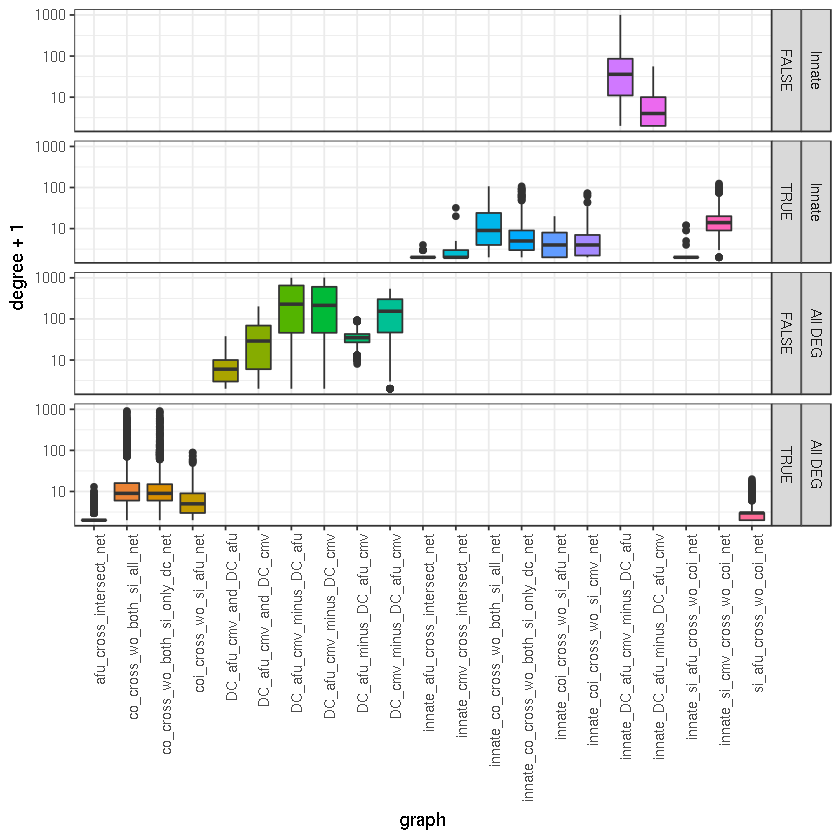

In [2426]:
# plot everything - hard to deal with
# Degree
g <- ggplot(node_properties, aes(x = graph, y = degree + 1, fill = graph)) +
    facet_grid(is_innate + is_cross ~ .) +
    geom_boxplot() +
    scale_fill_discrete(guide=FALSE) +
    scale_y_log10() +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
g

In [2428]:
dir.create("../results/correlation/plots", showWarnings = F)
ggsave("../results/correlation/plots/node_properties.all.pdf", g, dpi = 400)

Warning message in dir.create("../results/correlation/plots"):
“'../results/correlation/plots' already exists”Saving 6.67 x 6.67 in image


In [2448]:
node_properties %>% gather("measure", "value", -gene, -graph, -is_innate, -is_cross, -is_intersect) %>% head()

graph                   gene       is_innate is_cross is_intersect measure
1 afu_cross_intersect_net Afu3g07990 FALSE     TRUE     TRUE         degree 
2 afu_cross_intersect_net Afu4g12010 FALSE     TRUE     TRUE         degree 
3 afu_cross_intersect_net Afu4g14230 FALSE     TRUE     TRUE         degree 
4 afu_cross_intersect_net Afu5g02850 FALSE     TRUE     TRUE         degree 
5 afu_cross_intersect_net Afu7g04910 FALSE     TRUE     TRUE         degree 
6 afu_cross_intersect_net Afu2g04870 FALSE     TRUE     TRUE         degree 
  value
1 6    
2 1    
3 1    
4 1    
5 1    
6 1

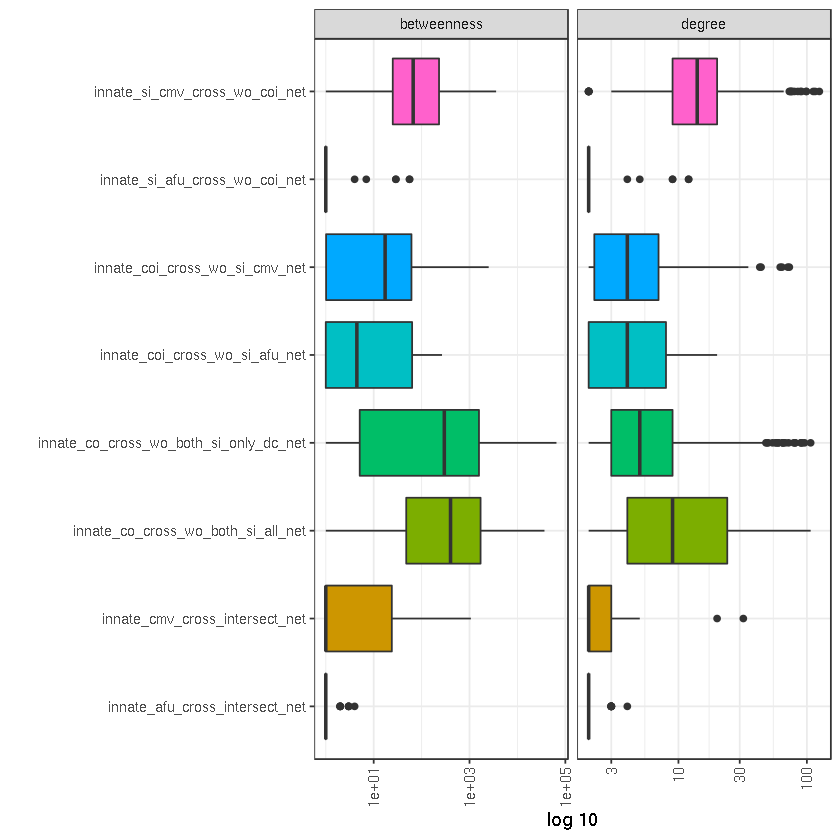

In [2599]:
# plot more specific subsets of the networks
g1 <- node_properties %>%
    gather("measure", "value", -gene, -graph, -is_innate, -is_cross, -is_intersect) %>%
    filter(is_cross & is_innate) %>%
    filter(measure != "transitivity") %>%
    ggplot(., aes(x = graph, y = value + 1, fill = graph)) +
    facet_grid( ~ measure, scales = "free_x") +
    geom_boxplot() +
    scale_fill_discrete(guide=FALSE) +
    scale_y_log10() +
    coord_flip() +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "", y = "log 10")
g1

In [2459]:
ggsave("../results/correlation/plots/node_properties.cross.innate.pdf", g1, dpi = 400)

Saving 6.67 x 6.67 in image


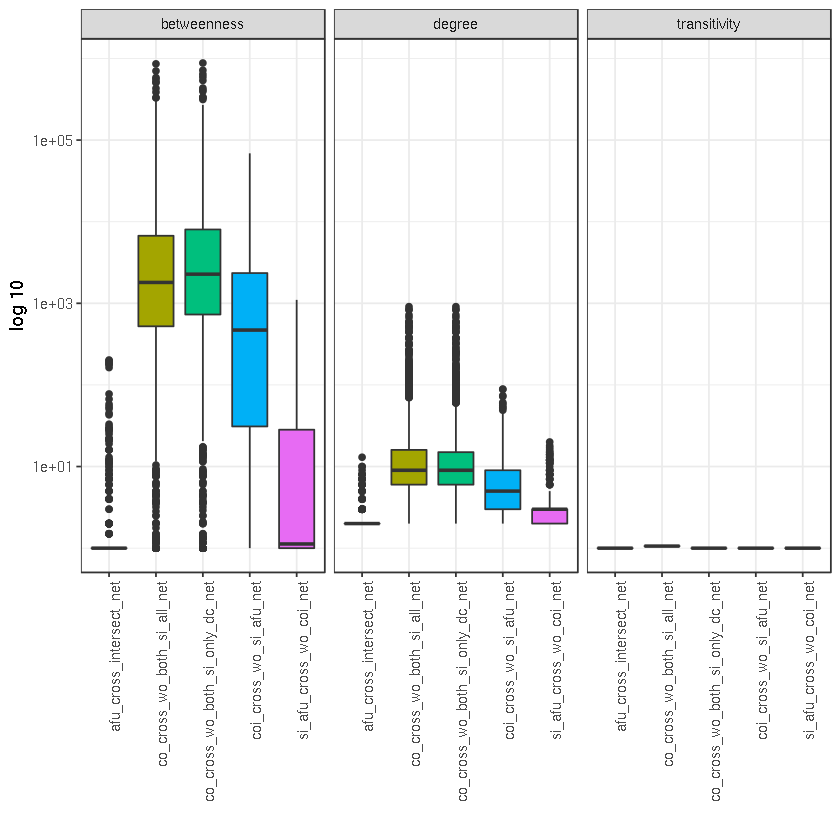

In [2594]:
# plot more specific subsets of the networks
g <- node_properties %>%
    gather("measure", "value", -gene, -graph, -is_innate, -is_cross, -is_intersect) %>%
    filter(is_cross & !is_innate) %>%
    ggplot(., aes(x = graph, y = value + 1, fill = graph)) +
    facet_grid( ~ measure, scales = "free_x") +
    geom_boxplot() +
    scale_fill_discrete(guide=FALSE) +
    scale_y_log10() +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(x = "", y = "log 10")
g

In [2461]:
ggsave("../results/correlation/plots/node_properties.cross.all_deg.pdf", g, dpi = 400)

Saving 6.67 x 6.67 in image


In [ ]:
# Network Properties
# Only Innate DB genes

In [2734]:
network_props <- read_xlsx("../results/correlation/network_stats_all.xlsx")

In [2735]:
network_props <- network_props %>% mutate(
    is_innate = grepl("innate", .$graph),
    is_cross = grepl("cross", .$graph),
    is_intersect = grepl("intersect", .$graph) | grepl("and", .$graph)
)

In [2736]:
head(network_props, 2)

graph                       num_vertices num_vertices_connected num_edges
1 afu_cross_intersect_net     3427          455                     343    
2 co_cross_wo_both_si_all_net 3882         3881                   39599    
  num_pos num_neg num_opp is_innate is_cross is_intersect
1   288      0    55      FALSE     TRUE      TRUE       
2 37657   1942     0      FALSE     TRUE     FALSE

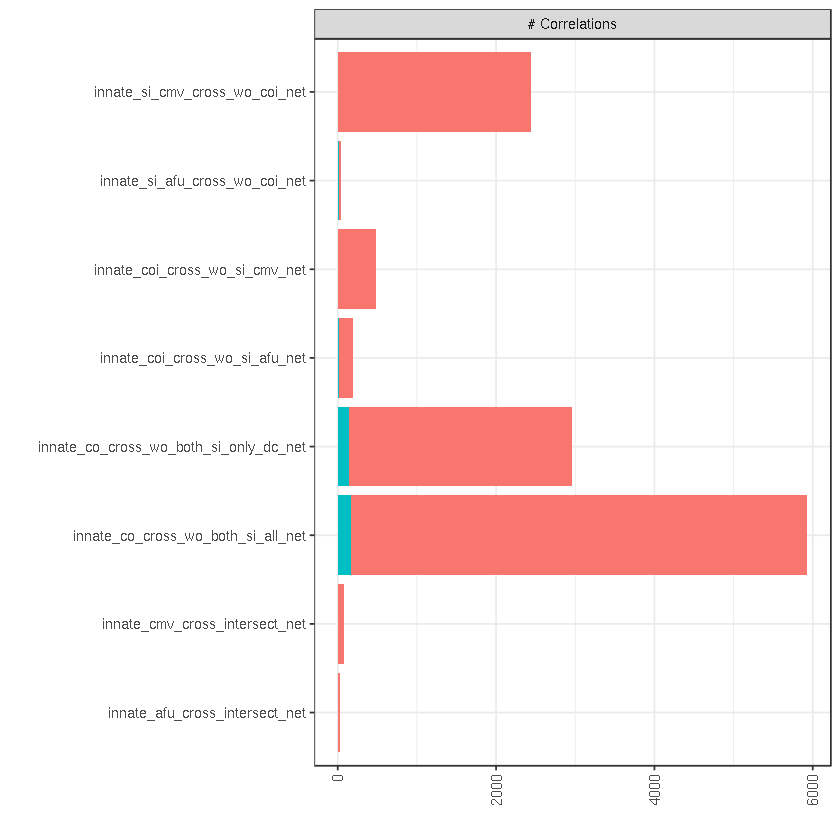

In [2710]:
g2 <- network_props %>%
    gather("measure", "value", -graph, -is_innate, -is_cross, -is_intersect) %>%
    filter(is_cross & is_innate & measure != "num_vertices") %>%
    filter(!(measure %in% c("num_opp", "num_vertices", "num_edges"))) %>%
    mutate(measure = factor(measure,
                            levels = c("num_pos", "num_neg"),
                            labels = c("# Positive", "# Negative"))) %>%
    mutate(label = "# Correlations") %>%
    ggplot(aes(x = graph, y = value, fill = measure)) +
    facet_grid(~ label) +
    geom_bar(stat = "identity") +
    scale_fill_discrete(guide = F) +
    coord_flip() +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "", y = "")
g2

In [2503]:
ggsave("../results/correlation/plots/network_properties.cross.innate.edges.pdf", g2, dpi = 300)

Saving 6.67 x 6.67 in image


In [2737]:
head(network_props)

graph                           num_vertices num_vertices_connected num_edges
1 afu_cross_intersect_net         3427          455                     343    
2 co_cross_wo_both_si_all_net     3882         3881                   39599    
3 co_cross_wo_both_si_only_dc_net 3882         3881                   36621    
4 coi_cross_wo_si_afu_net          706          706                    2405    
5 DC_afu_cmv_and_DC_afu           3977         2773                    9477    
6 DC_afu_cmv_and_DC_cmv           3975         2765                   61054    
  num_pos num_neg num_opp is_innate is_cross is_intersect
1   288      0     55     FALSE      TRUE     TRUE       
2 37657   1942      0     FALSE      TRUE    FALSE       
3 34700   1921      0     FALSE      TRUE    FALSE       
4  2223    182      0     FALSE      TRUE    FALSE       
5  8518      0    959     FALSE     FALSE     TRUE       
6 60983      0     71     FALSE     FALSE     TRUE

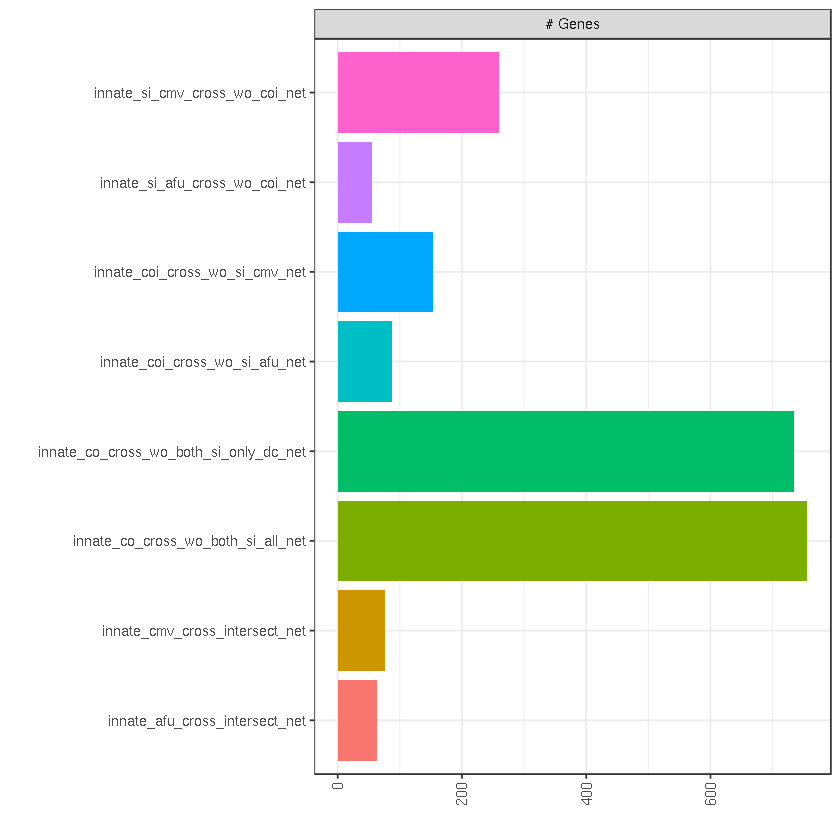

In [2740]:
g3 <- network_props %>%
    gather("measure", "value", -graph, -is_innate, -is_cross, -is_intersect) %>%
    filter(is_cross & is_innate & measure == "num_vertices_connected") %>%
    mutate(measure = factor(measure,
                            levels = c("num_vertices_connected"),
                            labels = c("# Genes"))) %>%
    ggplot(aes(x = graph, y = value, fill = graph)) +
    facet_grid(~ measure) +
    geom_bar(stat = "identity") +
    scale_fill_discrete(guide = F) +
    coord_flip() +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "", y = "")
g3

In [2742]:
ggsave("../results/correlation/plots/network_properties.cross.innate.vertices.pdf", g3, dpi = 300)

Saving 6.67 x 6.67 in image


In [ ]:
# combine all of them meaningfully

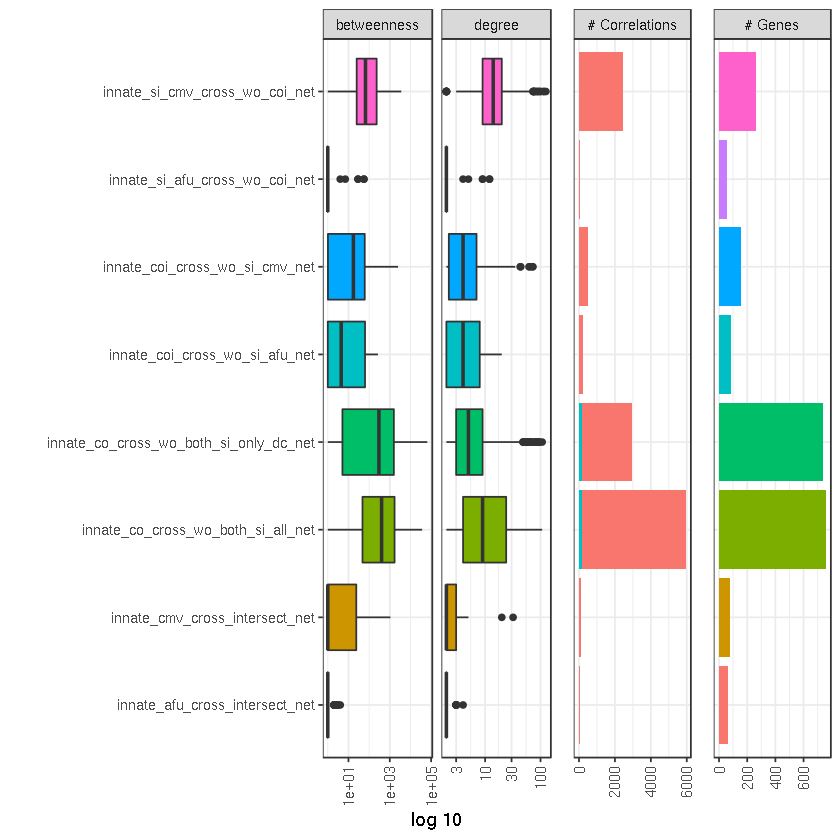

In [2743]:
v1 <- plot_grid(g1,
          g2 + theme(axis.title.y = element_blank(),
                     axis.text.y  = element_blank(),
                     axis.ticks.y = element_blank()),
          g3 + theme(axis.title.y = element_blank(),
                     axis.text.y  = element_blank(),
                     axis.ticks.y = element_blank()),
          nrow = 1,
          rel_widths = c(6,1.5,1.5),
          label_size = 6,
          align = "h")
v1

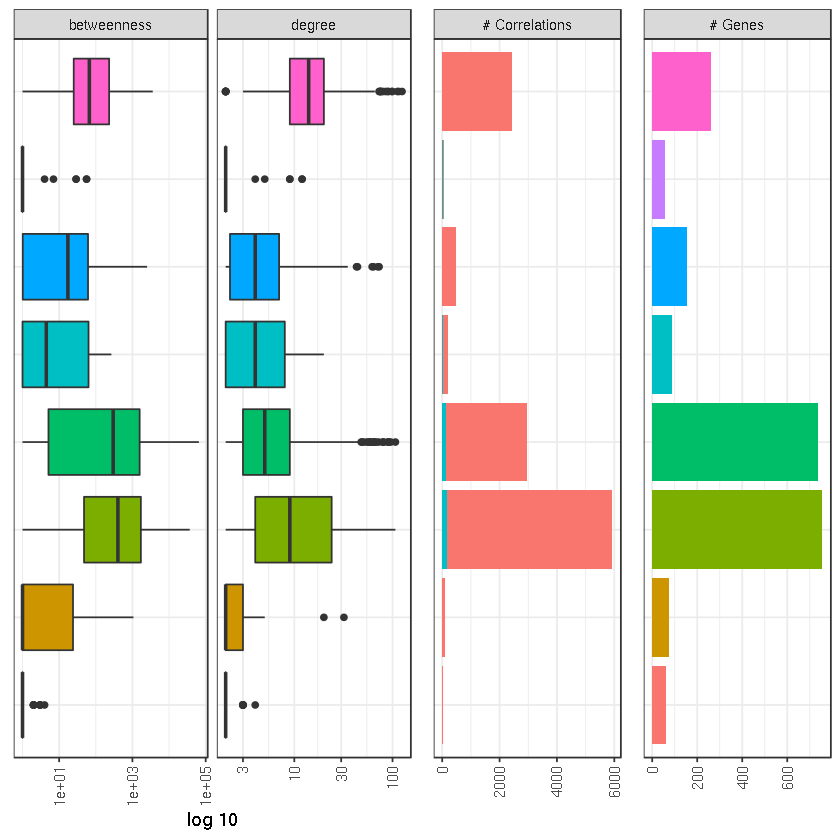

In [2744]:
v2 <- plot_grid(g1 + theme(axis.title.y = element_blank(),
                     axis.text.y  = element_blank(),
                     axis.ticks.y = element_blank()),
          g2 + theme(axis.title.y = element_blank(),
                     axis.text.y  = element_blank(),
                     axis.ticks.y = element_blank()),
          g3 + theme(axis.title.y = element_blank(),
                     axis.text.y  = element_blank(),
                     axis.ticks.y = element_blank()),
          nrow = 1,
          rel_widths = c(2,1,1),
          label_size = 6,
          align = "h")
v2

In [2745]:
ggsave("../results/correlation/plots/final_network_properties.v1.pdf", v1, width = 8, height = 12, dpi = 300)

In [2746]:
ggsave("../results/correlation/plots/final_network_properties.v2.pdf", v2, width = 8, height = 12, dpi = 300)

In [ ]:
# All_DEG

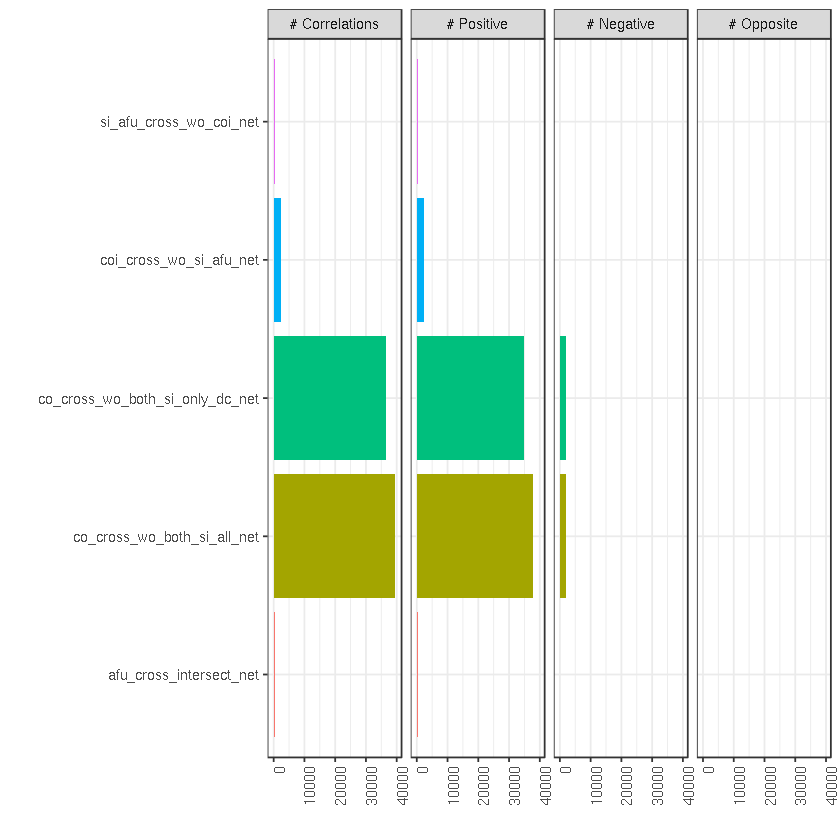

In [2506]:
g <- network_props %>%
    gather("measure", "value", -graph, -is_innate, -is_cross, -is_intersect) %>%
    filter(is_cross & !is_innate & measure != "num_vertices") %>%
    mutate(measure = factor(measure,
                            levels = c("num_vertices", "num_edges", "num_pos", "num_neg", "num_opp"),
                            labels = c("# Genes", "# Correlations", "# Positive", "# Negative", "# Opposite"))) %>%
    ggplot(aes(x = graph, y = value, fill = graph)) +
    facet_grid(~ measure) +
    geom_bar(stat = "identity") +
    scale_fill_discrete(guide = F) +
    coord_flip() +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(x = "", y = "")
g

In [2507]:
ggsave("../results/correlation/plots/network_properties.cross.all_deg.edges.pdf", g, dpi = 300)

Saving 6.67 x 6.67 in image


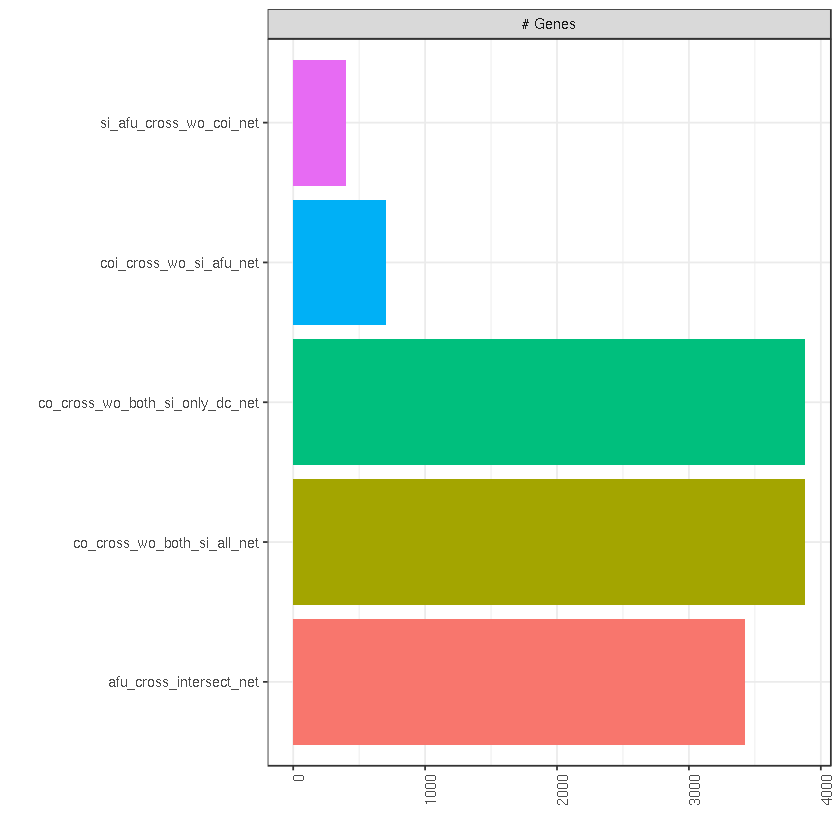

In [2508]:
g <- network_props %>%
    gather("measure", "value", -graph, -is_innate, -is_cross, -is_intersect) %>%
    filter(is_cross & !is_innate & measure == "num_vertices") %>%
    mutate(measure = factor(measure,
                            levels = c("num_vertices", "num_edges", "num_pos", "num_neg", "num_opp"),
                            labels = c("# Genes", "# Correlations", "# Positive", "# Negative", "# Opposite"))) %>%
    ggplot(aes(x = graph, y = value, fill = graph)) +
    facet_grid(~ measure) +
    geom_bar(stat = "identity") +
    scale_fill_discrete(guide = F) +
    coord_flip() +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(x = "", y = "")
g

In [2509]:
ggsave("../results/correlation/plots/network_properties.cross.all_deg.vertices.pdf", g, dpi = 300)

Saving 6.67 x 6.67 in image


### Gene Of Interest In Networks

In [2169]:
# exakt names
genes_of_interest1 <- c("CXCL11", "CXCL10", "IFNB1", "CXCL8", "IL1A", "TNF", "PTGS2")
# part of names
genes_of_interest2 <- c("REL", "CXCL", "IL", "AIM2", "ASC", "TNF", "RIG", "Dectin", "FAT", "ZBP", "STING", "IFN", "CCL", "GAS", "NFK")
pattern <- paste0("", paste(genes_of_interest2, collapse = "|"), "")
hub_files <- c(list.files(path = "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/", pattern = "\\.hubs\\.xlsx", full.names = T),
               list.files(path = "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster/", pattern = "\\.hubs\\.xlsx", full.names = T))


In [2170]:
# search hubs - specifically
interest_res <- list()

for (f in hub_files) {
    df <- readxl::read_xlsx(f)
    interest_res[[f]] <- data.frame(goi = genes_of_interest)
    interest_res[[f]]$found <- genes_of_interest %in% df$symbol # grepl(pattern = pattern, df$symbol)
}
res <- plyr::ldply(.data = interest_res, .id = "file")
writexl::write_xlsx(res, "../results/correlation/gene_of_interest_in_hubs.xlsx")

In [2171]:
# search hubs - extended version
interest_res <- list()

for (f in hub_files) {
    df <- readxl::read_xlsx(f)
    found1 <- genes_of_interest1 %in% df$symbol
    additional_genes <- grep(pattern = pattern, df$symbol, value = T)

    interest_res[[f]] <- data.frame(goi = c(genes_of_interest, additional_genes))
    interest_res[[f]]$found <- c(found1, rep(T, length(additional_genes)))
    interest_res[[f]] <- interest_res[[f]] %>% filter(!duplicated(goi))
}
res <- plyr::ldply(.data = interest_res, .id = "file")
writexl::write_xlsx(res, "../results/correlation/gene_of_interest_in_hubs.extended.xlsx")

In [2172]:
res %>% group_by(goi) %>% dplyr::summarize(n = sum(found))

res %>% filter(grepl("innate", file)) %>% group_by(goi) %>% dplyr::summarize(n = sum(found))

goi       n
1   AIM2      4
2   ASCL2     3
3   C1QTNF1   2
4   CCL15     1
5   CCL2      4
6   CCL20     2
7   CCL22     4
8   CCL3      2
9   CCL3L1    2
10  CCL4      2
11  CCL5      4
12  CCL7      2
13  CCL8      3
14  CGAS      5
15  CXCL1     2
16  CXCL10    4
17  CXCL11    8
18  CXCL2     4
19  CXCL3     2
20  CXCL8     2
21  CXCL9     5
22  FAT1      2
23  GAS2L3    3
24  GAS7      3
25  GASK1A    1
26  GASK1B    2
27  HILPDA    3
28  IFNA1     6
29  IFNA13    5
30  IFNA14    4
⋮   ⋮         ⋮
86  NFKBIZ    2
87  PIWIL4    3
88  PTGS2     2
89  REL       6
90  RELA      6
91  RELB      4
92  RILPL2    2
93  TBILA     5
94  TNF       4
95  TNFAIP2   2
96  TNFAIP3   6
97  TNFAIP6   2
98  TNFAIP8   3
99  TNFRSF10D 3
100 TNFRSF11B 2
101 TNFRSF12A 4
102 TNFRSF18  4
103 TNFRSF1A  6
104 TNFRSF1B  6
105 TNFRSF4   2
106 TNFRSF9   5
107 TNFSF10   9
108 TNFSF13B  3
109 TNFSF14   2
110 TNFSF15   2
111 TNFSF18   1
112 TNFSF9    6
113 TRIL      4
114 UMLILO    2
115 ZBP1      4

goi       n
1  AIM2      2
2  CCL2      2
3  CCL5      2
4  CXCL10    2
5  CXCL11    3
6  CXCL2     2
7  CXCL8     0
8  CXCL9     2
9  IFNA1     2
10 IFNB1     1
11 IFNG      2
12 IFNGR1    3
13 IFNGR2    3
14 IL10      1
15 IL12A     3
16 IL12B     2
17 IL15      2
18 IL18R1    2
19 IL1A      2
20 IL1B      3
21 IL1R1     2
22 IL2       2
23 IL23A     3
24 IL27      2
25 IL2RG     4
26 IL32      3
27 IL33      2
28 IL4R      3
29 IL7R      2
30 NFAT5     3
31 NFATC3    2
32 NFKB1     2
33 NFKB2     3
34 NFKBIA    2
35 NFKBIB    3
36 NFKBIE    3
37 PTGS2     1
38 REL       3
39 RELA      3
40 RELB      2
41 TNF       2
42 TNFAIP3   3
43 TNFRSF12A 2
44 TNFRSF18  2
45 TNFRSF1A  3
46 TNFRSF1B  3
47 TNFRSF9   2
48 TNFSF10   4
49 TNFSF9    3
50 ZBP1      2

#### Skim Through Genes Of Interest

In [2185]:
# Load annotation files to add even more information
afu_anno <- read.table("../other_data/AspGD_FeatureReferences.tab", sep = "\t", header = T, quote = "", check.names = F, stringsAsFactors = F, comment.char = "")
cmv_anno <- rtracklayer::readGFF("../other_data/EF999921.1.gtf")

In [2076]:
goi_file_df <- read_xlsx("../results/correlation/gene_of_interest_in_hubs.extended.xlsx")

In [2077]:
head(goi_file_df, 2)

file                                                                                               
1 ../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster//cmv_cross_intersect.hubs.xlsx
2 ../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster//cmv_cross_intersect.hubs.xlsx
  goi    found
1 CXCL11 FALSE
2 CXCL10 FALSE

In [ ]:
c("CXCL11", "CXCL10", "IFNB1", "CXCL8", "IL1A", "TNF", "PTGS2")

In [2177]:
filter_hub_files <- function(goi_sel) {
    goi_file_df %>% filter(goi == goi_sel & found == T) %>% ddply("file", function(x) {
        print(sub("\\.hubs", ".clusters", x$file))
        df <- read_xlsx(sub("\\.hubs", ".clusters", x$file)) # we want the edges file instead of the hub file
        df %>% filter(to_symbol_ == goi_sel | from_symbol == goi_sel)
    })
}

In [2209]:
annotate_filtered_hub_files <- function(s) {
    df <- filter_hub_files(s)
    # add AFU information
    idx <- match(df$from, afu_anno$FEATURE_NAME)
    use <- !is.na(idx)
    df <- cbind(df, afu_anno[idx, c("FEATURE_NAME", "GENE_NAME")])
    # add CMV information
    idx <- match(df$from, cmv_anno$ID)
    use <- !is.na(idx)
    df <- cbind(df, cmv_anno[idx, c("ID", "product")])
    writexl::write_xlsx(df, paste0("../results/correlation/genes_of_interest/", s, ".xlsx"))
}

In [2217]:
#annotate_filtered_hub_files("CGAS")
#annotate_filtered_hub_files("IFNB1")
#annotate_filtered_hub_files("CXCL10")
annotate_filtered_hub_files("PTGS2")
#annotate_filtered_hub_files("CXCL11")
#annotate_filtered_hub_files("TNF")
#annotate_filtered_hub_files("NFKB2")
#annotate_filtered_hub_files("IL32")

[1] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster//si_afu_cross_wo_CoI.clusters.xlsx"
[1] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster//si_afu_cross_wo_CoI.clusters.xlsx"


In [2206]:
head(cmv_anno)

seqid      source  type start end  score strand phase ID            
1 EF999921.1 Genbank CDS   331  1008 NA    -      0     cds-ABV71498.1
2 EF999921.1 Genbank CDS  1210  1890 NA    -      0     cds-ABV71499.1
3 EF999921.1 Genbank CDS  1905  2648 NA    -      0     cds-ABV71500.1
4 EF999921.1 Genbank CDS  3034  3591 NA    -      0     cds-ABV71501.1
5 EF999921.1 Genbank CDS  3667  4314 NA    -      0     cds-ABV71502.1
6 EF999921.1 Genbank CDS  4501  5346 NA    -      0     cds-ABV71503.1
  Dbxref             gbkey Name       product protein_id end_range partial
1 NCBI_GP:ABV71498.1 CDS   ABV71498.1 US7     ABV71498.1 NA        NA     
2 NCBI_GP:ABV71499.1 CDS   ABV71499.1 US8     ABV71499.1 NA        NA     
3 NCBI_GP:ABV71500.1 CDS   ABV71500.1 US9     ABV71500.1 NA        NA     
4 NCBI_GP:ABV71501.1 CDS   ABV71501.1 US10    ABV71501.1 NA        NA     
5 NCBI_GP:ABV71502.1 CDS   ABV71502.1 US11    ABV71502.1 NA        NA     
6 NCBI_GP:ABV71503.1 CDS   ABV71503.1 US12    ABV71503.1 NA        NA

In [1885]:
# seach enrich
enrich_files <- c(list.files(path = "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/enrichment/", pattern = "_enrich.*.xlsx", full.names = T),
                  list.files(path = "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/enrichment/", pattern = "_enrich.*.xlsx", full.names = T),
                  list.files(path = "../results/correlation/deg_genes/gene-wise/enrichment/", pattern = "_enrich.*.xlsx", full.names = T),
                  list.files(path = "../results/correlation/deg_genes/gene-wise/BetweenSpecies/Enrichment/", pattern = "_enrich.*.xlsx", full.names = T),
                  list.files(path = "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster/enrichment/", pattern = "_enrich.*.xlsx", full.names = T))

In [1929]:
enrich_files

[1] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/enrichment//coi_cross_org_wo_si_afu_enrich_sig.q005.xlsx"                 
 [2] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/enrichment//coi_cross_org_wo_si_cmv_enrich_sig.q005.xlsx"                 
 [3] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/enrichment//si_afu_cross_org_wo_CoI_enrich_sig.q005.xlsx"                 
 [4] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/enrichment//si_cmv_cross_org_wo_CoI_enrich_sig.q005.xlsx"                 
 [5] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/enrichment//coi_cross_wo_si_afu_enrich.clusters.sig.q005.xlsx"    
 [6] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/enrichment//coi_cross_wo_si_cmv_enrich.clusters.sig.q005.xlsx"    
 [7] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/enrichment//si_afu_cross_org_wo_CoI_enrich.clusters.sig.q005.xlsx"
 [8] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/enrichment//si_cmv_cross_wo_CoI_enrich.clusters.sig.q005.xlsx"    
 [9] "../results/correlation/deg_genes/gene-wise/enrichment//co_afu_wo_si_edges_dc_enrich_sig.q005.xlsx"                                     
[10] "../results/correlation/deg_genes/gene-wise/enrichment//co_afu_wo_si_edges_genes_enrich_sig.q005.xlsx"                                  
[11] "../results/correlation/deg_genes/gene-wise/enrichment//si_afu_wo_co_edges_dc_enrich_sig.q005.xlsx"                                     
[12] "../results/correlation/deg_genes/gene-wise/enrichment//si_afu_wo_Co_edges_genes_enrich_sig.q005.xlsx"                                  
[13] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/Enrichment//coi_cross_org_wo_si_afu_enrich_sig.q005.xlsx"                    
[14] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/Enrichment//coi_cross_org_wo_si_cmv_enrich_sig.q005.xlsx"                    
[15] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/Enrichment//si_afu_cross_org_wo_CoI_enrich_sig.q005.xlsx"                    
[16] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/Enrichment//si_cmv_cross_org_wo_CoI_enrich_sig.q005.xlsx"                    
[17] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster/enrichment//coi_cross_wo_si_afu_enrich.clusters.sig.q005.xlsx"       
[18] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster/enrichment//coi_cross_wo_si_cmv_enrich.clusters.sig.q005.xlsx"       
[19] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster/enrichment//si_afu_cross_org_wo_CoI_enrich.clusters.sig.q005.xlsx"   
[20] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster/enrichment//si_cmv_cross_wo_CoI_enrich.clusters.sig.q005.xlsx"

In [1889]:
for (f in enrich_files) {
    print(f)
    df <- readxl::read_xlsx(f)
    df$Genes <- strsplit(df$Genes, ";")
    df2 <- plyr::ddply(df, "Term", function(d) {
        inds <- which(genes_of_interest %in% unlist(d$Genes))
        if (length(inds) > 0) {
            d$contained <- T
            d$which <- paste(genes_of_interest[inds], collapse = ";")
        } else {
            d$contained <- F
            d$which <- ""
        }
        d$Genes <- paste(unlist(d$Genes), collapse = ";")
        return(d)
    })

    df2 <- filter(df2, contained)
    out_path <- gsub("\\.xlsx$", "\\.gene_of_manuscript\\.xlsx", f)
    writexl::write_xlsx(df2, out_path)
}

[1] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/enrichment//coi_cross_org_wo_si_afu_enrich_sig.q005.xlsx"
[1] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/enrichment//coi_cross_org_wo_si_cmv_enrich_sig.q005.xlsx"
[1] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/enrichment//si_afu_cross_org_wo_CoI_enrich_sig.q005.xlsx"
[1] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/enrichment//si_cmv_cross_org_wo_CoI_enrich_sig.q005.xlsx"
[1] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/enrichment//coi_cross_wo_si_afu_enrich.clusters.sig.q005.xlsx"
[1] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/enrichment//coi_cross_wo_si_cmv_enrich.clusters.sig.q005.xlsx"
[1] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/enrichment//si_afu_cross_org_wo_CoI_enrich.clusters.sig.q005.xlsx"
[1] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/enrichment//si_

In [1882]:
# cleanup
enrich_files <- c(list.files(path = "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/enrichment/", pattern = "\\.gene_of_manuscript\\.xlsx", full.names = T),
                  list.files(path = "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/enrichment/", pattern = "\\.gene_of_manuscript\\.xlsx", full.names = T),
                  list.files(path = "../results/correlation/deg_genes/gene-wise/enrichment/", pattern = "\\.gene_of_manuscript\\.xlsx", full.names = T),
                  list.files(path = "../results/correlation/deg_genes/gene-wise/BetweenSpecies/Enrichment/", pattern = "\\.gene_of_manuscript\\.xlsx", full.names = T),
                  list.files(path = "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster/enrichment/", pattern = "\\.gene_of_manuscript\\.xlsx", full.names = T))
file.remove(enrich_files)

#### Hub Plots

In [58]:
hub_files <- c(list.files(path = "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster/", pattern = "\\.hubs\\.xlsx", full.names = T),
               list.files(path = "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster/", pattern = "\\.hubs\\.xlsx", full.names = T))

In [59]:
hub_files

[1] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster//afu_cross_intersect.hubs.xlsx"        
 [2] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster//cmv_cross_intersect.hubs.xlsx"        
 [3] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster//co_cross_wo_both_si_all.hubs.xlsx"    
 [4] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster//co_cross_wo_both_si_only_dc.hubs.xlsx"
 [5] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster//coi_cross_wo_si_afu.hubs.xlsx"        
 [6] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster//coi_cross_wo_si_cmv.hubs.xlsx"        
 [7] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster//si_afu_cross_wo_CoI.hubs.xlsx"        
 [8] "../results/correlation/innateDB_deg/gene-wise/BetweenSpecies/cluster//si_cmv_cross_wo_CoI.hubs.xlsx"        
 [9] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster//afu_cross_intersect.hubs.xlsx"           
[10] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster//cmv_cross_intersect.hubs.xlsx"           
[11] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster//co_cross_wo_both_si_all.hubs.xlsx"       
[12] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster//co_cross_wo_both_si_only_dc.hubs.xlsx"   
[13] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster//coi_cross_wo_si_afu_net.hubs.xlsx"       
[14] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster//coi_cross_wo_si_afu.hubs.xlsx"           
[15] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster//coi_cross_wo_si_cmv.hubs.xlsx"           
[16] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster//si_afu_cross_intersect.hubs.xlsx"        
[17] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster//si_afu_cross_wo_CoI.hubs.xlsx"           
[18] "../results/correlation/deg_genes/gene-wise/BetweenSpecies/cluster//si_cmv_cross_wo_CoI.hubs.xlsx"

In [60]:
# Synonyms
#Dectin-1: CLEC7A
#RIG-1: DDX58
#STING: TMEM173
genes_of_interest <- c("IL1B", "IL10", "TNF", "CCL4", "NFAT", "NFAT5", "NFATC1", "NFATC3", "IL12A", "IL12B", "IL8", "IL6", "IL6R-AS1", "NFKB1", "RELA", "ASCL2", "CLEC7A", "AIM2", "CCL5", "TMEM173", "ZBP1", "TLR3", "CXCL11", "IFNA", "IFNB", "CGAS", "DDX58", "CXCL10")

genes_of_interest_template <- c("REL", "CXCL", "IL", "AIM2", "ASC", "TNF", "RIG", "Dectin", "FAT", "ZBP", "STING", "IFN", "CCL", "GAS", "NFK")
pattern <- paste(genes_of_interest_template, collapse="|")

In [61]:
for (f in hub_files) {
    df <- read_xlsx(f)
    # keep labels, if:
    # among the 5 highest in betweenness
    # among the 5 highest in degree
    # among the genes of interest
    df$topBetweenness <- df$betweenness >= sort(df$betweenness, decreasing = T)[5]
    df$topDegree <- df$degree >= sort(df$degree, decreasing = T)[5]
    df$ofInterest <- !is.na(df$symbol) & (df$symbol %in% genes_of_interest | grepl(pattern, df$symbol))
    keep_at <- which(df$topBetweenness | df$topDegree | df$ofInterest)
    keep_at <- keep_at[!is.na(df$symbol[keep_at])]
    df$label <- ""
    df$label[keep_at] <- df$symbol[keep_at]

    df$type = factor(ifelse(df$ofInterest, "goi", ifelse(df$topDegree, "deg", ifelse(df$topBetweenness, "bet", "none"))))
    
    g <- ggplot(df, aes(x = betweenness+1e-4, y = degree+1e-4, color = type, shape = ofInterest, label = label)) +
        geom_vline(xintercept = median(df$betweenness), linetype = 2) +
        geom_hline(yintercept = median(df$degree), linetype = 2) +
        scale_x_log10() +
        scale_y_log10() +
        geom_point() +
        #geom_text(nudge_y = 3, size = 2) +
        geom_text(nudge_y = log10(1.1), size = 2) +
        theme_bw()
    out_file <- file.path(dirname(f), "hub_plots", sub("\\.xlsx", ".pdf", basename(f)))
    dir.create(dirname(out_file), recursive = F, showWarnings = F)
    ggsave(filename = out_file, plot = g, dpi = 300)
}

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous x-axis”Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous x-axis”Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous x-axis”Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous x-axis”Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous x-axis”Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [62]:
names(hub_files) <- hub_files
names(hub_files) <- sub(".*/innateDB_deg/.*/", "innate_", names(hub_files)) %>% sub("\\.hubs\\.xlsx", "", .)
names(hub_files) <- sub(".*/", "deg_", names(hub_files)) %>% sub("\\.hubs\\.xlsx", "", .)

In [63]:
# calculate some stats
stats_df <- plyr::ldply(hub_files, .id = "network", function(f) {
    df <- read_xlsx(f)
    # keep labels, if:
    # among the 5 highest in betweenness
    # among the 5 highest in degree
    # among the genes of interest
    df$topBetweenness <- df$betweenness >= sort(df$betweenness, decreasing = T)[5]
    df$topDegree <- df$degree >= sort(df$degree, decreasing = T)[5]
    df$ofInterest <- !is.na(df$symbol) & (df$symbol %in% genes_of_interest | grepl(pattern, df$symbol))
    keep_at <- which(df$topBetweenness | df$topDegree | df$ofInterest)
    keep_at <- keep_at[!is.na(df$symbol[keep_at])]
    df$label <- ""
    df$label[keep_at] <- df$symbol[keep_at]

    df$type = factor(ifelse(df$ofInterest, "goi", ifelse(df$topDegree, "deg", ifelse(df$topBetweenness, "bet", "none"))))

    # some stats data
    df <- mutate(df, med_bet = median(df$betweenness))
    df <- mutate(df, med_deg = median(df$degree))
    df <- mutate(df, above_med_deg = degree > med_deg)
    df <- mutate(df, above_med_bet = betweenness > med_bet)
    df <- mutate(df, above_med_both = above_med_deg & above_med_bet)
    return(df)
})

In [66]:
writexl::write_xlsx(stats_df, "../results/correlation/hubs.gene_stats.all.xlsx")

In [160]:
writexl::write_xlsx(stats_df %>% filter(symbol %in% genes_of_interest),
                    "../results/correlation/hubs.gene_stats.goi.xlsx")

In [163]:
num_goi_above_med <- stats_df %>%
    filter(symbol %in% genes_of_interest) %>%
    group_by(network) %>% 
    summarise("above median degree" = sum(degree > med_deg),
              "above median betweenness" = sum(betweenness > med_bet),
              "above both" = sum(degree > med_deg & betweenness > med_bet),
              "# genes of interest" = n(),
              "pct. above median degree" = 100 * sum(degree > med_deg) / n(),
              "pct. above median betweenness" = 100 * sum(betweenness > med_bet) / n(),
              "pct. above both" = 100 * sum(degree > med_deg & betweenness > med_bet) / n())

In [ ]:
head(stats_df)

In [ ]:
# add information for networks were not goi is present
missing <- levels(num_goi_above_med$network)[!(levels(num_goi_above_med$network) %in% as.character(num_goi_above_med$network))]
len <- nrow(num_goi_above_med)
num_goi_above_med[(len+1):(len+2),] <- 0
num_goi_above_med[(len+1):(len+2), 1] <- missing

In [166]:
writexl::write_xlsx(num_goi_above_med,
                    "../results/correlation/hubs.stats.goi.above_median.xlsx")

# Other

In [24]:
g_coi <- readRDS("../results//correlation/innateDB_deg/DC_plus_CMV_0h_plus_Afu_0h.rds")
g_si_afu <- readRDS("../results//correlation/innateDB_deg/DC_plus_Afu_0h.rds")

In [27]:
pref_sp1 <- "ENS"
pref_sp2 <- "Afu"

In [34]:
edges <- g_coi %>%
    filter(xor(from_is_DC, to_is_DC)) %>%
    filter(xor(grepl(pref_sp2, to), grepl(pref_sp2, from)))
genes <- c(a$from, a$to) %>% unique %>% grep(pref_sp2, ., value = T)

In [37]:
write_tsv(as.data.frame(genes), "../results//correlation/innateDB_deg/afu_genes_in_CoI_but_not_SI.tsv")